https://github.com/EthicalSecurity-Agency/CyberBattleSim-CyberBattleSim/blob/main/notebooks/chainnetwork-optionwrapper.ipynb
https://github.com/EthicalSecurity-Agency/CyberBattleSim-CyberBattleSim/blob/main/notebooks/notebook_benchmark-toyctf.ipynb
https://www.cambridge.org/core/journals/knowledge-engineering-review/article/adversarial-agentlearning-for-cybersecurity-a-comparison-of-algorithms/99A6C4855B86E7F1A38FCB58ADCAFB56

research papers to study
:Towards Characterizing Divergence in Deep Q-Learning,
Deep Q-Learning based Reinforcement Learning Approach for Network Intrusion Detection 

Comparison of DQL,QL, Exploiting DQL, Exploiting QL and Random Policy + informed info about credentials over 10 episodes

In [1]:
import sys
import logging
from typing import cast
import gym
import numpy as np
import matplotlib.pyplot as plt  # type:ignore
from cyberbattle.agents.baseline.learner import TrainedLearner
import cyberbattle.agents.baseline.plotting as p
import cyberbattle.agents.baseline.agent_wrapper as w
import cyberbattle.agents.baseline.agent_tabularqlearning as a
from cyberbattle.agents.baseline.agent_wrapper import Verbosity
import cyberbattle.agents.baseline.learner as learner
import importlib
import cyberbattle.agents.baseline.agent_dql as dqla
import cyberbattle.agents.baseline.agent_randomcredlookup as rca
import cyberbattle.agents.baseline.agent_ppo as ppo
from cyberbattle._env.defender import ScanAndReimageCompromisedMachines
from cyberbattle._env.cyberbattle_env import AttackerGoal, DefenderConstraint
from typing import cast
from cyberbattle._env.cyberbattle_env import CyberBattleEnv
from cyberbattle._env.cyberbattle_toyctf import CyberBattleToyCtf
from stable_baselines3.a2c.a2c import A2C
from stable_baselines3.ppo.ppo import PPO
from cyberbattle._env.flatten_wrapper import FlattenObservationWrapper, FlattenActionWrapper
import os
from stable_baselines3 import PPO
logging.basicConfig(stream=sys.stdout, level=logging.ERROR, format="%(levelname)s: %(message)s")

In [2]:
import random
random.seed(120394016)
%matplotlib inline

In [3]:
importlib.reload(learner)
importlib.reload(p)

<module 'cyberbattle.agents.baseline.plotting' from '/home/gmod1/CyberBattleSim/cyberbattle/agents/baseline/plotting.py'>

In [4]:
# setting up environment
# create an instance of the CyberBattle simulation environment with specific parameters
cyberbattlechain_defender = gym.make('CyberBattleChain-v0',
                                     size=10,
                                     attacker_goal=AttackerGoal(
                                         own_atleast=0,
                                         own_atleast_percent=1.0
                                     ),
                                     defender_constraint=DefenderConstraint(
                                         maintain_sla=0.80
                                     ),
                                     defender_agent=ScanAndReimageCompromisedMachines(
                                         probability=0.6,
                                         scan_capacity=2,
                                         scan_frequency=5))

In [5]:
cyberbattlechain_defender.environment

Environment(network=<networkx.classes.digraph.DiGraph object at 0x7fa99106bd60>, vulnerability_library={}, identifiers=Identifiers(properties=['Windows', 'Linux', 'ApacheWebSite', 'IIS_2019', 'IIS_2020_patched', 'MySql', 'Ubuntu', 'nginx/1.10.3', 'SMB_vuln', 'SMB_vuln_patched', 'SQLServer', 'Win10', 'Win10Patched', 'FLAG:Linux'], ports=['HTTPS', 'GIT', 'SSH', 'RDP', 'PING', 'MySQL', 'SSH-key', 'su'], local_vulnerabilities=['ScanBashHistory', 'ScanExplorerRecentFiles', 'SudoAttempt', 'CrackKeepPassX', 'CrackKeepPass'], remote_vulnerabilities=['ProbeLinux', 'ProbeWindows']), creationTime=datetime.datetime(2024, 1, 12, 14, 59, 23, 694577), lastModified=datetime.datetime(2024, 1, 12, 14, 59, 23, 694579), version='0.1.0')

*   No predefined vulnerabilities in environment as seen by vulnerability_library.
*   list of identifiers used within the simulation environment: various properties (like operating systems, web services), ports (like HTTPS, SSH), and types of vulnerabilities (local and remote)







In [6]:
cyberbattlechain_defender.environment.network.nodes

NodeView(('start', '11_LinuxNode', '1_LinuxNode', '2_WindowsNode', '3_LinuxNode', '4_WindowsNode', '5_LinuxNode', '6_WindowsNode', '7_LinuxNode', '8_WindowsNode', '9_LinuxNode', '10_WindowsNode'))



*   start: initial position of the attacker
*   '11_LinuxNode', '1_LinuxNode', '2_WindowsNode', '3_LinuxNode', '4_WindowsNode', '5_LinuxNode', '6_WindowsNode', '7_LinuxNode', '8_WindowsNode', '9_LinuxNode', '10_WindowsNode': nodes in environment



In [7]:
cyberbattlechain_defender.action_space

DiscriminatedUnion(connect:MultiDiscrete([ 100  100    8 1000]), local_vulnerability:MultiDiscrete([100   5]), remote_vulnerability:MultiDiscrete([100 100   2]))

In [8]:
cyberbattlechain_defender.observation_space

Dict(_credential_cache:<cyberbattle._env.cyberbattle_env.DummySpace object at 0x7fa99108e490>, _discovered_nodes:<cyberbattle._env.cyberbattle_env.DummySpace object at 0x7fa99108e4f0>, _explored_network:<cyberbattle._env.cyberbattle_env.DummySpace object at 0x7fa99108e5b0>, action_mask:Dict(connect:MultiBinary([100, 100, 8, 1000]), local_vulnerability:MultiBinary([100, 5]), remote_vulnerability:MultiBinary([100, 100, 2])), credential_cache_length:Discrete(1000), credential_cache_matrix:Tuple(MultiDiscrete([100   8]), MultiDiscrete([100   8]), MultiDiscrete([100   8]), MultiDiscrete([100   8]), MultiDiscrete([100   8]), MultiDiscrete([100   8]), MultiDiscrete([100   8]), MultiDiscrete([100   8]), MultiDiscrete([100   8]), MultiDiscrete([100   8]), MultiDiscrete([100   8]), MultiDiscrete([100   8]), MultiDiscrete([100   8]), MultiDiscrete([100   8]), MultiDiscrete([100   8]), MultiDiscrete([100   8]), MultiDiscrete([100   8]), MultiDiscrete([100   8]), MultiDiscrete([100   8]), MultiDisc

In [9]:
cyberbattlechain_defender.observation_space['action_mask']

Dict(connect:MultiBinary([100, 100, 8, 1000]), local_vulnerability:MultiBinary([100, 5]), remote_vulnerability:MultiBinary([100, 100, 2]))

In [10]:
cyberbattlechain_defender.action_space.sample()

OrderedDict([('local_vulnerability', array([43,  4]))])

In [11]:
cyberbattlechain_defender.observation_space.sample()

OrderedDict([('_credential_cache',
              [CachedCredential(node='Sharepoint', port='HTTPS', credential='ADPrincipalCreds')]),
             ('_discovered_nodes', ['node1', 'node0', 'node2']),
             ('_explored_network',
              <networkx.classes.digraph.DiGraph at 0x7fa99108e550>),
             ('action_mask',
              OrderedDict([('connect',
                            array([[[[1, 0, 0, ..., 0, 0, 0],
                                     [0, 1, 0, ..., 1, 1, 0],
                                     [0, 1, 1, ..., 1, 0, 1],
                                     ...,
                                     [1, 1, 0, ..., 1, 1, 0],
                                     [1, 1, 0, ..., 0, 1, 0],
                                     [1, 0, 1, ..., 0, 0, 1]],
                            
                                    [[1, 0, 1, ..., 1, 0, 0],
                                     [0, 1, 1, ..., 1, 0, 1],
                                     [0, 1, 0, ..., 0, 1, 0],

In [12]:
''' simulation run for a reinforcement learning agent in CyberBattleSim
 
 cyberbattlechain_defender.render() method visualizes the current state of the environment after each rewarded action and at the end of the episode. '''

random.seed(120394016)
for i_episode in range(1):
    observation = cyberbattlechain_defender.reset()

    total_reward = 0

    for t in range(5600):
        action = cyberbattlechain_defender.sample_valid_action()

        observation, reward, done, info = cyberbattlechain_defender.step(action)

        total_reward += reward

        if reward>0:
            print('####### rewarded action: {action}')
            print(f'total_reward={total_reward} reward={reward}')
            cyberbattlechain_defender.render()

        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break

    cyberbattlechain_defender.render()

cyberbattlechain_defender.close()
print("simulation ended")

####### rewarded action: {action}
total_reward=14.0 reward=14.0


status properties              local_attacks  \
id                                                              
start             owned         []  [ScanExplorerRecentFiles]   
1_LinuxNode  discovered        NaN                       None   

                         remote_attacks  
id                                       
start                                []  
1_LinuxNode  [ProbeWindows, ProbeLinux]

####### rewarded action: {action}
total_reward=16.0 reward=2.0


status properties              local_attacks  \
id                                                              
start             owned         []  [ScanExplorerRecentFiles]   
1_LinuxNode  discovered        NaN                       None   

                         remote_attacks  
id                                       
start                                []  
1_LinuxNode  [ProbeWindows, ProbeLinux]

####### rewarded action: {action}
total_reward=20.0 reward=4.0


status properties              local_attacks  \
id                                                              
start             owned         []  [ScanExplorerRecentFiles]   
1_LinuxNode  discovered        NaN                       None   

                         remote_attacks  
id                                       
start                                []  
1_LinuxNode  [ProbeWindows, ProbeLinux]

####### rewarded action: {action}
total_reward=120.0 reward=100.0


status                     properties  \
id                                                  
start        owned                             []   
1_LinuxNode  owned  [MySql, Ubuntu, nginx/1.10.3]   

                                                 local_attacks  \
id                                                               
start                                [ScanExplorerRecentFiles]   
1_LinuxNode  [ScanBashHistory, SudoAttempt, CrackKeepPassX,...   

                         remote_attacks  
id                                       
start                                []  
1_LinuxNode  [ProbeWindows, ProbeLinux]

####### rewarded action: {action}
total_reward=131.0 reward=11.0


status                     properties  \
id                                                         
start               owned                             []   
1_LinuxNode         owned  [MySql, Ubuntu, nginx/1.10.3]   
2_WindowsNode  discovered                            NaN   

                                                   local_attacks  \
id                                                                 
start                                  [ScanExplorerRecentFiles]   
1_LinuxNode    [ScanBashHistory, SudoAttempt, CrackKeepPassX,...   
2_WindowsNode                                               None   

                           remote_attacks  
id                                         
start                                  []  
1_LinuxNode    [ProbeWindows, ProbeLinux]  
2_WindowsNode  [ProbeWindows, ProbeLinux]

####### rewarded action: {action}
total_reward=137.0 reward=6.0


status                     properties  \
id                                                         
start               owned                             []   
1_LinuxNode         owned  [MySql, Ubuntu, nginx/1.10.3]   
2_WindowsNode  discovered                            NaN   

                                                   local_attacks  \
id                                                                 
start                                  [ScanExplorerRecentFiles]   
1_LinuxNode    [ScanBashHistory, SudoAttempt, CrackKeepPassX,...   
2_WindowsNode                                               None   

                           remote_attacks  
id                                         
start                                  []  
1_LinuxNode    [ProbeWindows, ProbeLinux]  
2_WindowsNode  [ProbeWindows, ProbeLinux]

####### rewarded action: {action}
total_reward=146.0 reward=9.0


status                     properties  \
id                                                         
start               owned                             []   
1_LinuxNode         owned  [MySql, Ubuntu, nginx/1.10.3]   
2_WindowsNode  discovered                            NaN   

                                                   local_attacks  \
id                                                                 
start                                  [ScanExplorerRecentFiles]   
1_LinuxNode    [ScanBashHistory, SudoAttempt, CrackKeepPassX,...   
2_WindowsNode                                               None   

                           remote_attacks  
id                                         
start                                  []  
1_LinuxNode    [ProbeWindows, ProbeLinux]  
2_WindowsNode  [ProbeWindows, ProbeLinux]

####### rewarded action: {action}
total_reward=154.0 reward=8.0


status properties              local_attacks  \
id                                                                
start               owned         []  [ScanExplorerRecentFiles]   
1_LinuxNode    discovered        NaN                       None   
2_WindowsNode  discovered        NaN                       None   

                           remote_attacks  
id                                         
start                                  []  
1_LinuxNode    [ProbeWindows, ProbeLinux]  
2_WindowsNode  [ProbeWindows, ProbeLinux]

####### rewarded action: {action}
total_reward=254.0 reward=100.0


status                      properties  \
id                                                          
start               owned                              []   
2_WindowsNode       owned  [Windows, Win10, Win10Patched]   
1_LinuxNode    discovered                             NaN   

                                                   local_attacks  \
id                                                                 
start                                  [ScanExplorerRecentFiles]   
2_WindowsNode  [CrackKeepPassX, ScanExplorerRecentFiles, Crac...   
1_LinuxNode                                                 None   

                           remote_attacks  
id                                         
start                                  []  
2_WindowsNode  [ProbeWindows, ProbeLinux]  
1_LinuxNode    [ProbeWindows, ProbeLinux]

####### rewarded action: {action}
total_reward=268.0 reward=14.0


status                      properties  \
id                                                          
start               owned                              []   
2_WindowsNode       owned  [Windows, Win10, Win10Patched]   
1_LinuxNode    discovered                             NaN   
3_LinuxNode    discovered                             NaN   

                                                   local_attacks  \
id                                                                 
start                                  [ScanExplorerRecentFiles]   
2_WindowsNode  [CrackKeepPassX, ScanExplorerRecentFiles, Crac...   
1_LinuxNode                                                 None   
3_LinuxNode                                                 None   

                           remote_attacks  
id                                         
start                                  []  
2_WindowsNode  [ProbeWindows, ProbeLinux]  
1_LinuxNode    [ProbeWindows, ProbeLinux]  
3_LinuxNode    [ProbeWindows, ProbeLinux]

####### rewarded action: {action}
total_reward=272.0 reward=4.0


status                     properties  \
id                                                         
start               owned                             []   
1_LinuxNode         owned  [MySql, Ubuntu, nginx/1.10.3]   
2_WindowsNode  discovered                            NaN   
3_LinuxNode    discovered                            NaN   

                                                   local_attacks  \
id                                                                 
start                                  [ScanExplorerRecentFiles]   
1_LinuxNode    [ScanBashHistory, SudoAttempt, CrackKeepPassX,...   
2_WindowsNode                                               None   
3_LinuxNode                                                 None   

                           remote_attacks  
id                                         
start                                  []  
1_LinuxNode    [ProbeWindows, ProbeLinux]  
2_WindowsNode  [ProbeWindows, ProbeLinux]  
3_LinuxNode    [ProbeWindows, ProbeLinux]

####### rewarded action: {action}
total_reward=274.0 reward=2.0


status                     properties  \
id                                                         
start               owned                             []   
1_LinuxNode         owned  [MySql, Ubuntu, nginx/1.10.3]   
2_WindowsNode  discovered                            NaN   
3_LinuxNode    discovered                            NaN   

                                                   local_attacks  \
id                                                                 
start                                  [ScanExplorerRecentFiles]   
1_LinuxNode    [ScanBashHistory, SudoAttempt, CrackKeepPassX,...   
2_WindowsNode                                               None   
3_LinuxNode                                                 None   

                           remote_attacks  
id                                         
start                                  []  
1_LinuxNode    [ProbeWindows, ProbeLinux]  
2_WindowsNode  [ProbeWindows, ProbeLinux]  
3_LinuxNode    [ProbeWindows, ProbeLinux]

####### rewarded action: {action}
total_reward=374.0 reward=100.0


status                     properties  \
id                                                         
start               owned                             []   
3_LinuxNode         owned  [MySql, Ubuntu, nginx/1.10.3]   
1_LinuxNode    discovered                            NaN   
2_WindowsNode  discovered                            NaN   

                                                   local_attacks  \
id                                                                 
start                                  [ScanExplorerRecentFiles]   
3_LinuxNode    [ScanBashHistory, SudoAttempt, CrackKeepPassX,...   
1_LinuxNode                                                 None   
2_WindowsNode                                               None   

                           remote_attacks  
id                                         
start                                  []  
3_LinuxNode    [ProbeWindows, ProbeLinux]  
1_LinuxNode    [ProbeWindows, ProbeLinux]  
2_WindowsNode  [ProbeWindows, ProbeLinux]

####### rewarded action: {action}
total_reward=388.0 reward=14.0


status                     properties  \
id                                                         
start               owned                             []   
3_LinuxNode         owned  [MySql, Ubuntu, nginx/1.10.3]   
1_LinuxNode    discovered                            NaN   
2_WindowsNode  discovered                            NaN   
4_WindowsNode  discovered                            NaN   

                                                   local_attacks  \
id                                                                 
start                                  [ScanExplorerRecentFiles]   
3_LinuxNode    [ScanBashHistory, SudoAttempt, CrackKeepPassX,...   
1_LinuxNode                                                 None   
2_WindowsNode                                               None   
4_WindowsNode                                               None   

                           remote_attacks  
id                                         
start                                  []  
3_LinuxNode    [ProbeWindows, ProbeLinux]  
1_LinuxNode    [ProbeWindows, ProbeLinux]  
2_WindowsNode  [ProbeWindows, ProbeLinux]  
4_WindowsNode  [ProbeWindows, ProbeLinux]

####### rewarded action: {action}
total_reward=394.0 reward=6.0


status                     properties  \
id                                                         
start               owned                             []   
3_LinuxNode         owned  [MySql, Ubuntu, nginx/1.10.3]   
1_LinuxNode    discovered                            NaN   
2_WindowsNode  discovered                            NaN   
4_WindowsNode  discovered                            NaN   

                                                   local_attacks  \
id                                                                 
start                                  [ScanExplorerRecentFiles]   
3_LinuxNode    [ScanBashHistory, SudoAttempt, CrackKeepPassX,...   
1_LinuxNode                                                 None   
2_WindowsNode                                               None   
4_WindowsNode                                               None   

                           remote_attacks  
id                                         
start                                  []  
3_LinuxNode    [ProbeWindows, ProbeLinux]  
1_LinuxNode    [ProbeWindows, ProbeLinux]  
2_WindowsNode  [ProbeWindows, ProbeLinux]  
4_WindowsNode  [ProbeWindows, ProbeLinux]

####### rewarded action: {action}
total_reward=400.0 reward=6.0


status                     properties  \
id                                                         
start               owned                             []   
3_LinuxNode         owned  [MySql, Ubuntu, nginx/1.10.3]   
1_LinuxNode    discovered                            NaN   
2_WindowsNode  discovered                            NaN   
4_WindowsNode  discovered                            NaN   

                                                   local_attacks  \
id                                                                 
start                                  [ScanExplorerRecentFiles]   
3_LinuxNode    [ScanBashHistory, SudoAttempt, CrackKeepPassX,...   
1_LinuxNode                                                 None   
2_WindowsNode                                               None   
4_WindowsNode                                               None   

                           remote_attacks  
id                                         
start                                  []  
3_LinuxNode    [ProbeWindows, ProbeLinux]  
1_LinuxNode    [ProbeWindows, ProbeLinux]  
2_WindowsNode  [ProbeWindows, ProbeLinux]  
4_WindowsNode  [ProbeWindows, ProbeLinux]

####### rewarded action: {action}
total_reward=408.0 reward=8.0


status                     properties  \
id                                                         
start               owned                             []   
3_LinuxNode         owned  [MySql, Ubuntu, nginx/1.10.3]   
1_LinuxNode    discovered                            NaN   
2_WindowsNode  discovered                            NaN   
4_WindowsNode  discovered                            NaN   

                                                   local_attacks  \
id                                                                 
start                                  [ScanExplorerRecentFiles]   
3_LinuxNode    [ScanBashHistory, SudoAttempt, CrackKeepPassX,...   
1_LinuxNode                                                 None   
2_WindowsNode                                               None   
4_WindowsNode                                               None   

                           remote_attacks  
id                                         
start                                  []  
3_LinuxNode    [ProbeWindows, ProbeLinux]  
1_LinuxNode    [ProbeWindows, ProbeLinux]  
2_WindowsNode  [ProbeWindows, ProbeLinux]  
4_WindowsNode  [ProbeWindows, ProbeLinux]

####### rewarded action: {action}
total_reward=414.0 reward=6.0


status                      properties  \
id                                                          
start               owned                              []   
2_WindowsNode       owned  [Windows, Win10, Win10Patched]   
1_LinuxNode    discovered                             NaN   
3_LinuxNode    discovered                             NaN   
4_WindowsNode  discovered                             NaN   

                                                   local_attacks  \
id                                                                 
start                                  [ScanExplorerRecentFiles]   
2_WindowsNode  [CrackKeepPassX, ScanExplorerRecentFiles, Crac...   
1_LinuxNode                                                 None   
3_LinuxNode                                                 None   
4_WindowsNode                                               None   

                           remote_attacks  
id                                         
start                                  []  
2_WindowsNode  [ProbeWindows, ProbeLinux]  
1_LinuxNode    [ProbeWindows, ProbeLinux]  
3_LinuxNode    [ProbeWindows, ProbeLinux]  
4_WindowsNode  [ProbeWindows, ProbeLinux]

####### rewarded action: {action}
total_reward=514.0 reward=100.0


status                      properties  \
id                                                          
start               owned                              []   
4_WindowsNode       owned  [Windows, Win10, Win10Patched]   
1_LinuxNode    discovered                             NaN   
2_WindowsNode  discovered                             NaN   
3_LinuxNode    discovered                             NaN   

                                                   local_attacks  \
id                                                                 
start                                  [ScanExplorerRecentFiles]   
4_WindowsNode  [CrackKeepPassX, ScanExplorerRecentFiles, Crac...   
1_LinuxNode                                                 None   
2_WindowsNode                                               None   
3_LinuxNode                                                 None   

                           remote_attacks  
id                                         
start                                  []  
4_WindowsNode  [ProbeWindows, ProbeLinux]  
1_LinuxNode    [ProbeWindows, ProbeLinux]  
2_WindowsNode  [ProbeWindows, ProbeLinux]  
3_LinuxNode    [ProbeWindows, ProbeLinux]

####### rewarded action: {action}
total_reward=525.0 reward=11.0


status                     properties  \
id                                                         
start               owned                             []   
3_LinuxNode         owned  [MySql, Ubuntu, nginx/1.10.3]   
1_LinuxNode    discovered                            NaN   
2_WindowsNode  discovered                            NaN   
4_WindowsNode  discovered                            NaN   
5_LinuxNode    discovered                            NaN   

                                                   local_attacks  \
id                                                                 
start                                  [ScanExplorerRecentFiles]   
3_LinuxNode    [ScanBashHistory, SudoAttempt, CrackKeepPassX,...   
1_LinuxNode                                                 None   
2_WindowsNode                                               None   
4_WindowsNode                                               None   
5_LinuxNode                                                 None   

                           remote_attacks  
id                                         
start                                  []  
3_LinuxNode    [ProbeWindows, ProbeLinux]  
1_LinuxNode    [ProbeWindows, ProbeLinux]  
2_WindowsNode  [ProbeWindows, ProbeLinux]  
4_WindowsNode  [ProbeWindows, ProbeLinux]  
5_LinuxNode    [ProbeWindows, ProbeLinux]

####### rewarded action: {action}
total_reward=527.0 reward=2.0


status                     properties  \
id                                                         
start               owned                             []   
3_LinuxNode         owned  [MySql, Ubuntu, nginx/1.10.3]   
1_LinuxNode    discovered                            NaN   
2_WindowsNode  discovered                            NaN   
4_WindowsNode  discovered                            NaN   
5_LinuxNode    discovered                            NaN   

                                                   local_attacks  \
id                                                                 
start                                  [ScanExplorerRecentFiles]   
3_LinuxNode    [ScanBashHistory, SudoAttempt, CrackKeepPassX,...   
1_LinuxNode                                                 None   
2_WindowsNode                                               None   
4_WindowsNode                                               None   
5_LinuxNode                                                 None   

                           remote_attacks  
id                                         
start                                  []  
3_LinuxNode    [ProbeWindows, ProbeLinux]  
1_LinuxNode    [ProbeWindows, ProbeLinux]  
2_WindowsNode  [ProbeWindows, ProbeLinux]  
4_WindowsNode  [ProbeWindows, ProbeLinux]  
5_LinuxNode    [ProbeWindows, ProbeLinux]

####### rewarded action: {action}
total_reward=531.0 reward=4.0


status properties              local_attacks  \
id                                                                
start               owned         []  [ScanExplorerRecentFiles]   
1_LinuxNode    discovered        NaN                       None   
2_WindowsNode  discovered        NaN                       None   
3_LinuxNode    discovered        NaN                       None   
4_WindowsNode  discovered        NaN                       None   
5_LinuxNode    discovered        NaN                       None   

                           remote_attacks  
id                                         
start                                  []  
1_LinuxNode    [ProbeWindows, ProbeLinux]  
2_WindowsNode  [ProbeWindows, ProbeLinux]  
3_LinuxNode    [ProbeWindows, ProbeLinux]  
4_WindowsNode  [ProbeWindows, ProbeLinux]  
5_LinuxNode    [ProbeWindows, ProbeLinux]

####### rewarded action: {action}
total_reward=540.0 reward=9.0


status                      properties  \
id                                                          
start               owned                              []   
4_WindowsNode       owned  [Windows, Win10, Win10Patched]   
1_LinuxNode    discovered                             NaN   
2_WindowsNode  discovered                             NaN   
3_LinuxNode    discovered                             NaN   
5_LinuxNode    discovered                             NaN   

                                                   local_attacks  \
id                                                                 
start                                  [ScanExplorerRecentFiles]   
4_WindowsNode  [CrackKeepPassX, ScanExplorerRecentFiles, Crac...   
1_LinuxNode                                                 None   
2_WindowsNode                                               None   
3_LinuxNode                                                 None   
5_LinuxNode                                                 None   

                           remote_attacks  
id                                         
start                                  []  
4_WindowsNode  [ProbeWindows, ProbeLinux]  
1_LinuxNode    [ProbeWindows, ProbeLinux]  
2_WindowsNode  [ProbeWindows, ProbeLinux]  
3_LinuxNode    [ProbeWindows, ProbeLinux]  
5_LinuxNode    [ProbeWindows, ProbeLinux]

####### rewarded action: {action}
total_reward=640.0 reward=100.0


status                      properties  \
id                                                          
start               owned                              []   
2_WindowsNode       owned  [Windows, Win10, Win10Patched]   
5_LinuxNode         owned   [MySql, Ubuntu, nginx/1.10.3]   
1_LinuxNode    discovered                             NaN   
3_LinuxNode    discovered                             NaN   
4_WindowsNode  discovered                             NaN   

                                                   local_attacks  \
id                                                                 
start                                  [ScanExplorerRecentFiles]   
2_WindowsNode  [CrackKeepPassX, ScanExplorerRecentFiles, Crac...   
5_LinuxNode    [ScanBashHistory, SudoAttempt, CrackKeepPassX,...   
1_LinuxNode                                                 None   
3_LinuxNode                                                 None   
4_WindowsNode                                               None   

                           remote_attacks  
id                                         
start                                  []  
2_WindowsNode  [ProbeWindows, ProbeLinux]  
5_LinuxNode    [ProbeWindows, ProbeLinux]  
1_LinuxNode    [ProbeWindows, ProbeLinux]  
3_LinuxNode    [ProbeWindows, ProbeLinux]  
4_WindowsNode  [ProbeWindows, ProbeLinux]

####### rewarded action: {action}
total_reward=651.0 reward=11.0


status                     properties  \
id                                                         
start               owned                             []   
5_LinuxNode         owned  [MySql, Ubuntu, nginx/1.10.3]   
1_LinuxNode    discovered                            NaN   
2_WindowsNode  discovered                            NaN   
3_LinuxNode    discovered                            NaN   
4_WindowsNode  discovered                            NaN   
6_WindowsNode  discovered                            NaN   

                                                   local_attacks  \
id                                                                 
start                                  [ScanExplorerRecentFiles]   
5_LinuxNode    [ScanBashHistory, SudoAttempt, CrackKeepPassX,...   
1_LinuxNode                                                 None   
2_WindowsNode                                               None   
3_LinuxNode                                                 None   
4_WindowsNode                                               None   
6_WindowsNode                                               None   

                           remote_attacks  
id                                         
start                                  []  
5_LinuxNode    [ProbeWindows, ProbeLinux]  
1_LinuxNode    [ProbeWindows, ProbeLinux]  
2_WindowsNode  [ProbeWindows, ProbeLinux]  
3_LinuxNode    [ProbeWindows, ProbeLinux]  
4_WindowsNode  [ProbeWindows, ProbeLinux]  
6_WindowsNode  [ProbeWindows, ProbeLinux]

####### rewarded action: {action}
total_reward=660.0 reward=9.0


status                     properties  \
id                                                         
start               owned                             []   
5_LinuxNode         owned  [MySql, Ubuntu, nginx/1.10.3]   
1_LinuxNode    discovered                            NaN   
2_WindowsNode  discovered                            NaN   
3_LinuxNode    discovered                            NaN   
4_WindowsNode  discovered                            NaN   
6_WindowsNode  discovered                            NaN   

                                                   local_attacks  \
id                                                                 
start                                  [ScanExplorerRecentFiles]   
5_LinuxNode    [ScanBashHistory, SudoAttempt, CrackKeepPassX,...   
1_LinuxNode                                                 None   
2_WindowsNode                                               None   
3_LinuxNode                                                 None   
4_WindowsNode                                               None   
6_WindowsNode                                               None   

                           remote_attacks  
id                                         
start                                  []  
5_LinuxNode    [ProbeWindows, ProbeLinux]  
1_LinuxNode    [ProbeWindows, ProbeLinux]  
2_WindowsNode  [ProbeWindows, ProbeLinux]  
3_LinuxNode    [ProbeWindows, ProbeLinux]  
4_WindowsNode  [ProbeWindows, ProbeLinux]  
6_WindowsNode  [ProbeWindows, ProbeLinux]

####### rewarded action: {action}
total_reward=666.0 reward=6.0


status                     properties  \
id                                                         
start               owned                             []   
5_LinuxNode         owned  [MySql, Ubuntu, nginx/1.10.3]   
1_LinuxNode    discovered                            NaN   
2_WindowsNode  discovered                            NaN   
3_LinuxNode    discovered                            NaN   
4_WindowsNode  discovered                            NaN   
6_WindowsNode  discovered                            NaN   

                                                   local_attacks  \
id                                                                 
start                                  [ScanExplorerRecentFiles]   
5_LinuxNode    [ScanBashHistory, SudoAttempt, CrackKeepPassX,...   
1_LinuxNode                                                 None   
2_WindowsNode                                               None   
3_LinuxNode                                                 None   
4_WindowsNode                                               None   
6_WindowsNode                                               None   

                           remote_attacks  
id                                         
start                                  []  
5_LinuxNode    [ProbeWindows, ProbeLinux]  
1_LinuxNode    [ProbeWindows, ProbeLinux]  
2_WindowsNode  [ProbeWindows, ProbeLinux]  
3_LinuxNode    [ProbeWindows, ProbeLinux]  
4_WindowsNode  [ProbeWindows, ProbeLinux]  
6_WindowsNode  [ProbeWindows, ProbeLinux]

####### rewarded action: {action}
total_reward=674.0 reward=8.0


status                     properties  \
id                                                         
start               owned                             []   
5_LinuxNode         owned  [MySql, Ubuntu, nginx/1.10.3]   
1_LinuxNode    discovered                            NaN   
2_WindowsNode  discovered                            NaN   
3_LinuxNode    discovered                            NaN   
4_WindowsNode  discovered                            NaN   
6_WindowsNode  discovered                            NaN   

                                                   local_attacks  \
id                                                                 
start                                  [ScanExplorerRecentFiles]   
5_LinuxNode    [ScanBashHistory, SudoAttempt, CrackKeepPassX,...   
1_LinuxNode                                                 None   
2_WindowsNode                                               None   
3_LinuxNode                                                 None   
4_WindowsNode                                               None   
6_WindowsNode                                               None   

                           remote_attacks  
id                                         
start                                  []  
5_LinuxNode    [ProbeWindows, ProbeLinux]  
1_LinuxNode    [ProbeWindows, ProbeLinux]  
2_WindowsNode  [ProbeWindows, ProbeLinux]  
3_LinuxNode    [ProbeWindows, ProbeLinux]  
4_WindowsNode  [ProbeWindows, ProbeLinux]  
6_WindowsNode  [ProbeWindows, ProbeLinux]

status properties              local_attacks  \
id                                                                
start               owned         []  [ScanExplorerRecentFiles]   
1_LinuxNode    discovered        NaN                       None   
2_WindowsNode  discovered        NaN                       None   
3_LinuxNode    discovered        NaN                       None   
4_WindowsNode  discovered        NaN                       None   
5_LinuxNode    discovered        NaN                       None   
6_WindowsNode  discovered        NaN                       None   

                           remote_attacks  
id                                         
start                                  []  
1_LinuxNode    [ProbeWindows, ProbeLinux]  
2_WindowsNode  [ProbeWindows, ProbeLinux]  
3_LinuxNode    [ProbeWindows, ProbeLinux]  
4_WindowsNode  [ProbeWindows, ProbeLinux]  
5_LinuxNode    [ProbeWindows, ProbeLinux]  
6_WindowsNode  [ProbeWindows, ProbeLinux]

simulation ended


In [13]:
'''initial state of environment'''

random.seed(120394016)
# Render and visualize the environment
cyberbattlechain_defender.render()
ep = w.EnvironmentBounds.of_identifiers(
    maximum_total_credentials=22,
    maximum_node_count=22,
    identifiers=cyberbattlechain_defender.identifiers
)
#cyberbattlechain_defender.render_as_fig()


status properties              local_attacks  \
id                                                                
start               owned         []  [ScanExplorerRecentFiles]   
1_LinuxNode    discovered        NaN                       None   
2_WindowsNode  discovered        NaN                       None   
3_LinuxNode    discovered        NaN                       None   
4_WindowsNode  discovered        NaN                       None   
5_LinuxNode    discovered        NaN                       None   
6_WindowsNode  discovered        NaN                       None   

                           remote_attacks  
id                                         
start                                  []  
1_LinuxNode    [ProbeWindows, ProbeLinux]  
2_WindowsNode  [ProbeWindows, ProbeLinux]  
3_LinuxNode    [ProbeWindows, ProbeLinux]  
4_WindowsNode  [ProbeWindows, ProbeLinux]  
5_LinuxNode    [ProbeWindows, ProbeLinux]  
6_WindowsNode  [ProbeWindows, ProbeLinux]

In [14]:
'''agent needs detailed information about the state of the environment to make informed decisions about actions to take'''

observation = cyberbattlechain_defender.reset()
print("Keys in observation:", observation.keys())
for k,v in observation.items():
    print(k)


Keys in observation: dict_keys(['newly_discovered_nodes_count', 'leaked_credentials', 'lateral_move', 'customer_data_found', 'escalation', 'action_mask', 'probe_result', 'credential_cache_matrix', 'credential_cache_length', 'discovered_node_count', 'discovered_nodes_properties', 'nodes_privilegelevel', '_credential_cache', '_discovered_nodes', '_explored_network'])
newly_discovered_nodes_count
leaked_credentials
lateral_move
customer_data_found
escalation
action_mask
probe_result
credential_cache_matrix
credential_cache_length
discovered_node_count
discovered_nodes_properties
nodes_privilegelevel
_credential_cache
_discovered_nodes
_explored_network


In [15]:
privilege_levels = observation['nodes_privilegelevel']
privilege_levels

array([1], dtype=int32)

In [16]:
random.seed(120394016)
iteration_count = 90000
training_episode_count = 100
eval_episode_count = 100
gamma_sweep = [
    0.015,  # about right
]

###### DQL
Learning with: episode_count=100,iteration_count=90000,ϵ=0.9,ϵ_min=0.1, ϵ_multdecay=0.75,ϵ_expdecay=5000,γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5
  ## Episode: 1/100 'DQL' ϵ=0.9000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 1|Iteration 17|reward:  120.0|last_reward_at:   17|Elapsed Time: 0:00:00||/home/gmod1/CyberBattleSim/cyberbattle/agents/baseline/agent_dql.py:382: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)

Episode 1|Iteration 1851|reward: 5912.0|last_reward_at: 1851|Elapsed Time: 0:00:08||


  Episode 1 ended at t=1851 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 13/288 (0.04)
    explore-remote: 14/569 (0.02)
    explore-connect: 3/593 (0.01)
    exploit-local: 1/114 (0.01)
    exploit-remote: 0/58 (0.00)
    exploit-connect: 5/193 (0.03)
  exploit deflected to exploration: 38
  ## Episode: 2/100 'DQL' ϵ=0.4894, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 2|Iteration 606|reward: 5790.0|last_reward_at:  606|Elapsed Time: 0:00:03||


  Episode 2 ended at t=606 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 7/69 (0.09)
    explore-remote: 8/140 (0.05)
    explore-connect: 0/146 (0.00)
    exploit-local: 5/64 (0.07)
    exploit-remote: 5/45 (0.10)
    exploit-connect: 7/110 (0.06)
  exploit deflected to exploration: 16
  ## Episode: 3/100 'DQL' ϵ=0.4421, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 3|Iteration 836|reward: 5674.0|last_reward_at:  836|Elapsed Time: 0:00:05||


  Episode 3 ended at t=836 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/101 (0.04)
    explore-remote: 11/168 (0.06)
    explore-connect: 1/219 (0.00)
    exploit-local: 8/113 (0.07)
    exploit-remote: 1/57 (0.02)
    exploit-connect: 4/149 (0.03)
  exploit deflected to exploration: 50
  ## Episode: 4/100 'DQL' ϵ=0.3856, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 4|Iteration 606|reward: 6030.0|last_reward_at:  606|Elapsed Time: 0:00:03||


  Episode 4 ended at t=606 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/66 (0.06)
    explore-remote: 15/148 (0.09)
    explore-connect: 2/108 (0.02)
    exploit-local: 12/75 (0.14)
    exploit-remote: 1/40 (0.02)
    exploit-connect: 6/129 (0.04)
  exploit deflected to exploration: 39
  ## Episode: 5/100 'DQL' ϵ=0.3502, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 5|Iteration 361|reward: 5888.0|last_reward_at:  361|Elapsed Time: 0:00:02||


  Episode 5 ended at t=361 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 7/46 (0.13)
    explore-remote: 8/64 (0.11)
    explore-connect: 0/56 (0.00)
    exploit-local: 6/58 (0.09)
    exploit-remote: 5/25 (0.17)
    exploit-connect: 7/79 (0.08)
  exploit deflected to exploration: 15
  ## Episode: 6/100 'DQL' ϵ=0.3310, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 6|Iteration 541|reward: 5790.0|last_reward_at:  541|Elapsed Time: 0:00:03||


  Episode 6 ended at t=541 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/38 (0.12)
    explore-remote: 6/102 (0.06)
    explore-connect: 1/97 (0.01)
    exploit-local: 8/83 (0.09)
    exploit-remote: 7/32 (0.18)
    exploit-connect: 5/157 (0.03)
  exploit deflected to exploration: 20
  ## Episode: 7/100 'DQL' ϵ=0.3047, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 7|Iteration 446|reward: 5664.0|last_reward_at:  446|Elapsed Time: 0:00:03||


  Episode 7 ended at t=446 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/50 (0.09)
    explore-remote: 9/79 (0.10)
    explore-connect: 0/79 (0.00)
    exploit-local: 7/79 (0.08)
    exploit-remote: 2/26 (0.07)
    exploit-connect: 5/105 (0.05)
  exploit deflected to exploration: 49
  ## Episode: 8/100 'DQL' ϵ=0.2851, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 8|Iteration 381|reward: 5634.0|last_reward_at:  381|Elapsed Time: 0:00:02||


  Episode 8 ended at t=381 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/26 (0.10)
    explore-remote: 4/74 (0.05)
    explore-connect: 0/83 (0.00)
    exploit-local: 6/59 (0.09)
    exploit-remote: 6/26 (0.19)
    exploit-connect: 6/88 (0.06)
  exploit deflected to exploration: 37
  ## Episode: 9/100 'DQL' ϵ=0.2697, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 9|Iteration 391|reward: 5878.0|last_reward_at:  391|Elapsed Time: 0:00:02||


  Episode 9 ended at t=391 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/30 (0.12)
    explore-remote: 7/51 (0.12)
    explore-connect: 1/67 (0.01)
    exploit-local: 8/67 (0.11)
    exploit-remote: 5/27 (0.16)
    exploit-connect: 7/117 (0.06)
  exploit deflected to exploration: 30
  ## Episode: 10/100 'DQL' ϵ=0.2551, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 10|Iteration 486|reward: 5894.0|last_reward_at:  486|Elapsed Time: 0:00:03||


  Episode 10 ended at t=486 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 6/42 (0.12)
    explore-remote: 10/54 (0.16)
    explore-connect: 1/71 (0.01)
    exploit-local: 7/95 (0.07)
    exploit-remote: 4/37 (0.10)
    exploit-connect: 7/152 (0.04)
  exploit deflected to exploration: 17
  ## Episode: 11/100 'DQL' ϵ=0.2384, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 11|Iteration 306|reward: 5668.0|last_reward_at:  306|Elapsed Time: 0:00:02||


  Episode 11 ended at t=306 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/27 (0.16)
    explore-remote: 9/43 (0.17)
    explore-connect: 0/46 (0.00)
    exploit-local: 7/54 (0.11)
    exploit-remote: 3/28 (0.10)
    exploit-connect: 5/79 (0.06)
  exploit deflected to exploration: 35
  ## Episode: 12/100 'DQL' ϵ=0.2287, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 12|Iteration 401|reward: 5884.0|last_reward_at:  401|Elapsed Time: 0:00:02||


  Episode 12 ended at t=401 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/25 (0.11)
    explore-remote: 7/63 (0.10)
    explore-connect: 1/61 (0.02)
    exploit-local: 9/75 (0.11)
    exploit-remote: 6/36 (0.14)
    exploit-connect: 7/108 (0.06)
  exploit deflected to exploration: 30
  ## Episode: 13/100 'DQL' ϵ=0.2168, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 13|Iteration 616|reward: 6026.0|last_reward_at:  616|Elapsed Time: 0:00:03||


  Episode 13 ended at t=616 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/47 (0.10)
    explore-remote: 8/76 (0.10)
    explore-connect: 0/68 (0.00)
    exploit-local: 10/116 (0.08)
    exploit-remote: 8/60 (0.12)
    exploit-connect: 9/209 (0.04)
  exploit deflected to exploration: 18
  ## Episode: 14/100 'DQL' ϵ=0.2004, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 14|Iteration 491|reward: 6132.0|last_reward_at:  491|Elapsed Time: 0:00:03||


  Episode 14 ended at t=491 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/26 (0.04)
    explore-remote: 6/48 (0.11)
    explore-connect: 1/52 (0.02)
    exploit-local: 14/96 (0.13)
    exploit-remote: 10/60 (0.14)
    exploit-connect: 9/168 (0.05)
  exploit deflected to exploration: 18
  ## Episode: 15/100 'DQL' ϵ=0.1887, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 15|Iteration 376|reward: 5527.0|last_reward_at:  376|Elapsed Time: 0:00:02||


  Episode 15 ended at t=376 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/35 (0.08)
    explore-remote: 8/53 (0.13)
    explore-connect: 1/44 (0.02)
    exploit-local: 6/81 (0.07)
    exploit-remote: 2/40 (0.05)
    exploit-connect: 3/100 (0.03)
  exploit deflected to exploration: 59
  ## Episode: 16/100 'DQL' ϵ=0.1804, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 16|Iteration 181|reward: 5403.0|last_reward_at:  181|Elapsed Time: 0:00:01||


  Episode 16 ended at t=181 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/14 (0.12)
    explore-remote: 5/38 (0.12)
    explore-connect: 0/22 (0.00)
    exploit-local: 5/30 (0.14)
    exploit-remote: 3/16 (0.16)
    exploit-connect: 3/43 (0.07)
  exploit deflected to exploration: 40
  ## Episode: 17/100 'DQL' ϵ=0.1767, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 17|Iteration 311|reward: 5664.0|last_reward_at:  311|Elapsed Time: 0:00:01||


  Episode 17 ended at t=311 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/17 (0.19)
    explore-remote: 4/39 (0.09)
    explore-connect: 0/24 (0.00)
    exploit-local: 8/73 (0.10)
    exploit-remote: 7/34 (0.17)
    exploit-connect: 5/96 (0.05)
  exploit deflected to exploration: 19
  ## Episode: 18/100 'DQL' ϵ=0.1706, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 18|Iteration 661|reward: 5896.0|last_reward_at:  661|Elapsed Time: 0:00:04||


  Episode 18 ended at t=661 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/29 (0.12)
    explore-remote: 7/56 (0.11)
    explore-connect: 0/55 (0.00)
    exploit-local: 9/154 (0.06)
    exploit-remote: 7/72 (0.09)
    exploit-connect: 8/260 (0.03)
  exploit deflected to exploration: 35
  ## Episode: 19/100 'DQL' ϵ=0.1587, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 19|Iteration 451|reward: 6038.0|last_reward_at:  451|Elapsed Time: 0:00:02||


  Episode 19 ended at t=451 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/22 (0.15)
    explore-remote: 7/28 (0.20)
    explore-connect: 0/46 (0.00)
    exploit-local: 13/110 (0.11)
    exploit-remote: 9/67 (0.12)
    exploit-connect: 9/136 (0.06)
  exploit deflected to exploration: 5
  ## Episode: 20/100 'DQL' ϵ=0.1515, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 20|Iteration 621|reward: 5770.0|last_reward_at:  621|Elapsed Time: 0:00:04||


  Episode 20 ended at t=621 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/38 (0.10)
    explore-remote: 6/44 (0.12)
    explore-connect: 0/63 (0.00)
    exploit-local: 8/170 (0.04)
    exploit-remote: 6/82 (0.07)
    exploit-connect: 6/194 (0.03)
  exploit deflected to exploration: 43
  ## Episode: 21/100 'DQL' ϵ=0.1426, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 21|Iteration 701|reward: 6026.0|last_reward_at:  701|Elapsed Time: 0:00:04||


  Episode 21 ended at t=701 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/37 (0.10)
    explore-remote: 5/65 (0.07)
    explore-connect: 0/60 (0.00)
    exploit-local: 12/157 (0.07)
    exploit-remote: 9/76 (0.11)
    exploit-connect: 8/268 (0.03)
  exploit deflected to exploration: 36
  ## Episode: 22/100 'DQL' ϵ=0.1337, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 22|Iteration 336|reward: 5778.0|last_reward_at:  336|Elapsed Time: 0:00:02||


  Episode 22 ended at t=336 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/18 (0.10)
    explore-remote: 5/30 (0.14)
    explore-connect: 0/35 (0.00)
    exploit-local: 9/77 (0.10)
    exploit-remote: 8/39 (0.17)
    exploit-connect: 6/107 (0.05)
  exploit deflected to exploration: 42
  ## Episode: 23/100 'DQL' ϵ=0.1299, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 23|Iteration 391|reward: 5760.0|last_reward_at:  391|Elapsed Time: 0:00:02||


  Episode 23 ended at t=391 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/17 (0.11)
    explore-remote: 5/44 (0.10)
    explore-connect: 0/51 (0.00)
    exploit-local: 9/88 (0.09)
    exploit-remote: 5/51 (0.09)
    exploit-connect: 7/112 (0.06)
  exploit deflected to exploration: 54
  ## Episode: 24/100 'DQL' ϵ=0.1258, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 24|Iteration 506|reward: 5794.0|last_reward_at:  506|Elapsed Time: 0:00:03||


  Episode 24 ended at t=506 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/24 (0.17)
    explore-remote: 5/38 (0.12)
    explore-connect: 0/34 (0.00)
    exploit-local: 8/134 (0.06)
    exploit-remote: 8/62 (0.11)
    exploit-connect: 7/181 (0.04)
  exploit deflected to exploration: 19
  ## Episode: 25/100 'DQL' ϵ=0.1209, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 25|Iteration 551|reward: 6135.0|last_reward_at:  551|Elapsed Time: 0:00:03||


  Episode 25 ended at t=551 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/22 (0.15)
    explore-remote: 3/43 (0.07)
    explore-connect: 0/57 (0.00)
    exploit-local: 12/130 (0.08)
    exploit-remote: 14/66 (0.17)
    exploit-connect: 9/191 (0.04)
  exploit deflected to exploration: 31
  ## Episode: 26/100 'DQL' ϵ=0.1161, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 26|Iteration 181|reward: 5498.0|last_reward_at:  181|Elapsed Time: 0:00:01||


  Episode 26 ended at t=181 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/3 (0.25)
    explore-remote: 3/28 (0.10)
    explore-connect: 0/24 (0.00)
    exploit-local: 4/25 (0.14)
    exploit-remote: 6/28 (0.18)
    exploit-connect: 4/55 (0.07)
  exploit deflected to exploration: 39
  ## Episode: 27/100 'DQL' ϵ=0.1146, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 27|Iteration 466|reward: 6013.0|last_reward_at:  466|Elapsed Time: 0:00:03||


  Episode 27 ended at t=466 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/27 (0.10)
    explore-remote: 3/38 (0.07)
    explore-connect: 0/37 (0.00)
    exploit-local: 12/100 (0.11)
    exploit-remote: 11/71 (0.13)
    exploit-connect: 8/156 (0.05)
  exploit deflected to exploration: 24
  ## Episode: 28/100 'DQL' ϵ=0.1111, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 28|Iteration 466|reward: 6141.0|last_reward_at:  466|Elapsed Time: 0:00:03||


  Episode 28 ended at t=466 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/19 (0.21)
    explore-remote: 8/30 (0.21)
    explore-connect: 0/32 (0.00)
    exploit-local: 11/121 (0.08)
    exploit-remote: 8/55 (0.13)
    exploit-connect: 10/167 (0.06)
  exploit deflected to exploration: 32
  ## Episode: 29/100 'DQL' ϵ=0.1079, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 29|Iteration 201|reward: 5512.0|last_reward_at:  201|Elapsed Time: 0:00:01||


  Episode 29 ended at t=201 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/4 (0.20)
    explore-remote: 2/14 (0.12)
    explore-connect: 1/9 (0.10)
    exploit-local: 7/46 (0.13)
    exploit-remote: 6/26 (0.19)
    exploit-connect: 3/82 (0.04)
  exploit deflected to exploration: 5
  ## Episode: 30/100 'DQL' ϵ=0.1066, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 30|Iteration 321|reward: 5886.0|last_reward_at:  321|Elapsed Time: 0:00:02||


  Episode 30 ended at t=321 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/13 (0.19)
    explore-remote: 6/24 (0.20)
    explore-connect: 0/21 (0.00)
    exploit-local: 11/84 (0.12)
    exploit-remote: 7/35 (0.17)
    exploit-connect: 7/110 (0.06)
  exploit deflected to exploration: 23
  ## Episode: 31/100 'DQL' ϵ=0.1046, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 31|Iteration 451|reward: 5653.0|last_reward_at:  451|Elapsed Time: 0:00:02||


  Episode 31 ended at t=451 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/19 (0.17)
    explore-remote: 4/49 (0.08)
    explore-connect: 0/48 (0.00)
    exploit-local: 6/112 (0.05)
    exploit-remote: 8/62 (0.11)
    exploit-connect: 5/134 (0.04)
  exploit deflected to exploration: 57
  ## Episode: 32/100 'DQL' ϵ=0.1021, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 32|Iteration 821|reward: 5920.0|last_reward_at:  821|Elapsed Time: 0:00:05||


  Episode 32 ended at t=821 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/29 (0.09)
    explore-remote: 6/49 (0.11)
    explore-connect: 1/63 (0.02)
    exploit-local: 11/202 (0.05)
    exploit-remote: 9/122 (0.07)
    exploit-connect: 7/319 (0.02)
  exploit deflected to exploration: 48
  ## Episode: 33/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 33|Iteration 356|reward: 5876.0|last_reward_at:  356|Elapsed Time: 0:00:02||


  Episode 33 ended at t=356 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/12 (0.08)
    explore-remote: 4/48 (0.08)
    explore-connect: 0/31 (0.00)
    exploit-local: 11/61 (0.15)
    exploit-remote: 9/55 (0.14)
    exploit-connect: 7/117 (0.06)
  exploit deflected to exploration: 46
  ## Episode: 34/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 34|Iteration 246|reward: 5649.0|last_reward_at:  246|Elapsed Time: 0:00:01||


  Episode 34 ended at t=246 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/9 (0.18)
    explore-remote: 3/26 (0.10)
    explore-connect: 0/27 (0.00)
    exploit-local: 8/45 (0.15)
    exploit-remote: 6/28 (0.18)
    exploit-connect: 6/86 (0.07)
  exploit deflected to exploration: 30
  ## Episode: 35/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 35|Iteration 271|reward: 5880.0|last_reward_at:  271|Elapsed Time: 0:00:01||


  Episode 35 ended at t=271 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/7 (0.22)
    explore-remote: 1/18 (0.05)
    explore-connect: 0/16 (0.00)
    exploit-local: 11/64 (0.15)
    exploit-remote: 12/33 (0.27)
    exploit-connect: 7/100 (0.07)
  exploit deflected to exploration: 13
  ## Episode: 36/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 36|Iteration 171|reward: 5620.0|last_reward_at:  171|Elapsed Time: 0:00:01||


  Episode 36 ended at t=171 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/2 (0.50)
    explore-remote: 2/12 (0.14)
    explore-connect: 1/12 (0.08)
    exploit-local: 5/44 (0.10)
    exploit-remote: 7/16 (0.30)
    exploit-connect: 5/63 (0.07)
  exploit deflected to exploration: 13
  ## Episode: 37/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 37|Iteration 396|reward: 5766.0|last_reward_at:  396|Elapsed Time: 0:00:02||


  Episode 37 ended at t=396 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/15 (0.17)
    explore-remote: 3/43 (0.07)
    explore-connect: 0/28 (0.00)
    exploit-local: 8/73 (0.10)
    exploit-remote: 8/63 (0.11)
    exploit-connect: 6/146 (0.04)
  exploit deflected to exploration: 50
  ## Episode: 38/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 38|Iteration 301|reward: 5624.0|last_reward_at:  301|Elapsed Time: 0:00:02||


  Episode 38 ended at t=301 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/11 (0.15)
    explore-remote: 3/38 (0.07)
    explore-connect: 0/22 (0.00)
    exploit-local: 6/81 (0.07)
    exploit-remote: 5/40 (0.11)
    exploit-connect: 6/87 (0.06)
  exploit deflected to exploration: 37
  ## Episode: 39/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 39|Iteration 346|reward: 5785.0|last_reward_at:  346|Elapsed Time: 0:00:02||


  Episode 39 ended at t=346 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/18 (0.18)
    explore-remote: 2/48 (0.04)
    explore-connect: 0/33 (0.00)
    exploit-local: 8/76 (0.10)
    exploit-remote: 12/33 (0.27)
    exploit-connect: 7/105 (0.06)
  exploit deflected to exploration: 54
  ## Episode: 40/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 40|Iteration 181|reward: 5510.0|last_reward_at:  181|Elapsed Time: 0:00:01||


  Episode 40 ended at t=181 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/13 (0.24)
    explore-remote: 3/13 (0.19)
    explore-connect: 1/19 (0.05)
    exploit-local: 3/56 (0.05)
    exploit-remote: 5/19 (0.21)
    exploit-connect: 4/41 (0.09)
  exploit deflected to exploration: 32
  ## Episode: 41/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 41|Iteration 301|reward: 5655.0|last_reward_at:  301|Elapsed Time: 0:00:02||


  Episode 41 ended at t=301 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/21 (0.09)
    explore-remote: 7/36 (0.16)
    explore-connect: 0/43 (0.00)
    exploit-local: 7/71 (0.09)
    exploit-remote: 5/49 (0.09)
    exploit-connect: 6/54 (0.10)
  exploit deflected to exploration: 62
  ## Episode: 42/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 42|Iteration 646|reward: 5655.0|last_reward_at:  646|Elapsed Time: 0:00:04||


  Episode 42 ended at t=646 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/19 (0.14)
    explore-remote: 3/42 (0.07)
    explore-connect: 1/41 (0.02)
    exploit-local: 7/192 (0.04)
    exploit-remote: 8/99 (0.07)
    exploit-connect: 5/226 (0.02)
  exploit deflected to exploration: 38
  ## Episode: 43/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 43|Iteration 406|reward: 5780.0|last_reward_at:  406|Elapsed Time: 0:00:03||


  Episode 43 ended at t=406 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/13 (0.19)
    explore-remote: 4/38 (0.10)
    explore-connect: 1/30 (0.03)
    exploit-local: 8/97 (0.08)
    exploit-remote: 9/61 (0.13)
    exploit-connect: 6/136 (0.04)
  exploit deflected to exploration: 46
  ## Episode: 44/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 44|Iteration 431|reward: 6052.0|last_reward_at:  431|Elapsed Time: 0:00:03||


  Episode 44 ended at t=431 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/24 (0.17)
    explore-remote: 4/30 (0.12)
    explore-connect: 1/31 (0.03)
    exploit-local: 12/122 (0.09)
    exploit-remote: 14/55 (0.20)
    exploit-connect: 8/125 (0.06)
  exploit deflected to exploration: 51
  ## Episode: 45/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 45|Iteration 376|reward: 5901.0|last_reward_at:  376|Elapsed Time: 0:00:02||


  Episode 45 ended at t=376 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/17 (0.11)
    explore-remote: 5/28 (0.15)
    explore-connect: 0/25 (0.00)
    exploit-local: 13/105 (0.11)
    exploit-remote: 8/46 (0.15)
    exploit-connect: 7/120 (0.06)
  exploit deflected to exploration: 37
  ## Episode: 46/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 46|Iteration 331|reward: 5664.0|last_reward_at:  331|Elapsed Time: 0:00:02||


  Episode 46 ended at t=331 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/13 (0.13)
    explore-remote: 5/28 (0.15)
    explore-connect: 0/27 (0.00)
    exploit-local: 9/93 (0.09)
    exploit-remote: 6/47 (0.11)
    exploit-connect: 6/95 (0.06)
  exploit deflected to exploration: 40
  ## Episode: 47/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 47|Iteration 246|reward: 5664.0|last_reward_at:  246|Elapsed Time: 0:00:01||


  Episode 47 ended at t=246 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/11 (0.08)
    explore-remote: 3/16 (0.16)
    explore-connect: 0/16 (0.00)
    exploit-local: 10/46 (0.18)
    exploit-remote: 9/30 (0.23)
    exploit-connect: 5/99 (0.05)
  exploit deflected to exploration: 10
  ## Episode: 48/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 48|Iteration 436|reward: 5766.0|last_reward_at:  436|Elapsed Time: 0:00:02||


  Episode 48 ended at t=436 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/13 (0.13)
    explore-remote: 5/18 (0.22)
    explore-connect: 1/17 (0.06)
    exploit-local: 9/123 (0.07)
    exploit-remote: 7/62 (0.10)
    exploit-connect: 6/173 (0.03)
  exploit deflected to exploration: 17
  ## Episode: 49/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 49|Iteration 316|reward: 5630.0|last_reward_at:  316|Elapsed Time: 0:00:01||


  Episode 49 ended at t=316 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/12 (0.00)
    explore-remote: 3/40 (0.07)
    explore-connect: 0/26 (0.00)
    exploit-local: 8/66 (0.11)
    exploit-remote: 6/42 (0.12)
    exploit-connect: 6/107 (0.05)
  exploit deflected to exploration: 44
  ## Episode: 50/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 50|Iteration 166|reward: 5760.0|last_reward_at:  166|Elapsed Time: 0:00:01||


  Episode 50 ended at t=166 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/10 (0.29)
    explore-remote: 6/7 (0.46)
    explore-connect: 0/17 (0.00)
    exploit-local: 7/43 (0.14)
    exploit-remote: 6/17 (0.26)
    exploit-connect: 6/43 (0.12)
  exploit deflected to exploration: 27
  ## Episode: 51/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 51|Iteration 401|reward: 5651.0|last_reward_at:  401|Elapsed Time: 0:00:02||


  Episode 51 ended at t=401 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/18 (0.10)
    explore-remote: 3/29 (0.09)
    explore-connect: 1/34 (0.03)
    exploit-local: 8/97 (0.08)
    exploit-remote: 8/47 (0.15)
    exploit-connect: 5/149 (0.03)
  exploit deflected to exploration: 28
  ## Episode: 52/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 52|Iteration 426|reward: 5788.0|last_reward_at:  426|Elapsed Time: 0:00:03||


  Episode 52 ended at t=426 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/20 (0.09)
    explore-remote: 1/37 (0.03)
    explore-connect: 0/27 (0.00)
    exploit-local: 10/122 (0.08)
    exploit-remote: 13/56 (0.19)
    exploit-connect: 6/132 (0.04)
  exploit deflected to exploration: 46
  ## Episode: 53/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 53|Iteration 461|reward: 6019.0|last_reward_at:  461|Elapsed Time: 0:00:03||


  Episode 53 ended at t=461 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/14 (0.12)
    explore-remote: 3/21 (0.12)
    explore-connect: 0/30 (0.00)
    exploit-local: 13/118 (0.10)
    exploit-remote: 11/67 (0.14)
    exploit-connect: 9/173 (0.05)
  exploit deflected to exploration: 29
  ## Episode: 54/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 54|Iteration 501|reward: 5884.0|last_reward_at:  501|Elapsed Time: 0:00:03||


  Episode 54 ended at t=501 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/16 (0.11)
    explore-remote: 1/38 (0.03)
    explore-connect: 0/31 (0.00)
    exploit-local: 10/120 (0.08)
    exploit-remote: 12/77 (0.13)
    exploit-connect: 8/186 (0.04)
  exploit deflected to exploration: 42
  ## Episode: 55/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 55|Iteration 141|reward: 5506.0|last_reward_at:  141|Elapsed Time: 0:00:01||


  Episode 55 ended at t=141 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/10 (0.23)
    explore-remote: 2/19 (0.10)
    explore-connect: 0/10 (0.00)
    exploit-local: 4/23 (0.15)
    exploit-remote: 6/20 (0.23)
    exploit-connect: 4/40 (0.09)
  exploit deflected to exploration: 27
  ## Episode: 56/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 56|Iteration 431|reward: 5886.0|last_reward_at:  431|Elapsed Time: 0:00:03||


  Episode 56 ended at t=431 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/17 (0.11)
    explore-remote: 6/27 (0.18)
    explore-connect: 0/32 (0.00)
    exploit-local: 10/117 (0.08)
    exploit-remote: 8/58 (0.12)
    exploit-connect: 8/146 (0.05)
  exploit deflected to exploration: 30
  ## Episode: 57/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 57|Iteration 411|reward: 5657.0|last_reward_at:  411|Elapsed Time: 0:00:02||


  Episode 57 ended at t=411 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/7 (0.22)
    explore-remote: 2/33 (0.06)
    explore-connect: 1/29 (0.03)
    exploit-local: 9/99 (0.08)
    exploit-remote: 9/54 (0.14)
    exploit-connect: 4/162 (0.02)
  exploit deflected to exploration: 26
  ## Episode: 58/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 58|Iteration 281|reward: 5754.0|last_reward_at:  281|Elapsed Time: 0:00:02||


  Episode 58 ended at t=281 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/12 (0.25)
    explore-remote: 2/18 (0.10)
    explore-connect: 0/24 (0.00)
    exploit-local: 6/86 (0.07)
    exploit-remote: 9/31 (0.23)
    exploit-connect: 7/82 (0.08)
  exploit deflected to exploration: 32
  ## Episode: 59/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 59|Iteration 146|reward: 5401.0|last_reward_at:  146|Elapsed Time: 0:00:01||


  Episode 59 ended at t=146 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/8 (0.20)
    explore-remote: 2/21 (0.09)
    explore-connect: 0/17 (0.00)
    exploit-local: 4/27 (0.13)
    exploit-remote: 6/15 (0.29)
    exploit-connect: 4/40 (0.09)
  exploit deflected to exploration: 35
  ## Episode: 60/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 60|Iteration 576|reward: 5773.0|last_reward_at:  576|Elapsed Time: 0:00:03||


  Episode 60 ended at t=576 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/19 (0.17)
    explore-remote: 5/41 (0.11)
    explore-connect: 0/34 (0.00)
    exploit-local: 7/134 (0.05)
    exploit-remote: 8/80 (0.09)
    exploit-connect: 7/237 (0.03)
  exploit deflected to exploration: 42
  ## Episode: 61/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 61|Iteration 931|reward: 5898.0|last_reward_at:  931|Elapsed Time: 0:00:05||


  Episode 61 ended at t=931 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/30 (0.03)
    explore-remote: 2/45 (0.04)
    explore-connect: 0/55 (0.00)
    exploit-local: 12/250 (0.05)
    exploit-remote: 12/150 (0.07)
    exploit-connect: 8/366 (0.02)
  exploit deflected to exploration: 39
  ## Episode: 62/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 62|Iteration 386|reward: 5632.0|last_reward_at:  386|Elapsed Time: 0:00:02||


  Episode 62 ended at t=386 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/13 (0.07)
    explore-remote: 3/36 (0.08)
    explore-connect: 0/35 (0.00)
    exploit-local: 7/95 (0.07)
    exploit-remote: 7/57 (0.11)
    exploit-connect: 5/127 (0.04)
  exploit deflected to exploration: 48
  ## Episode: 63/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 63|Iteration 316|reward: 5626.0|last_reward_at:  316|Elapsed Time: 0:00:02||


  Episode 63 ended at t=316 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/10 (0.23)
    explore-remote: 1/43 (0.02)
    explore-connect: 0/28 (0.00)
    exploit-local: 5/71 (0.07)
    exploit-remote: 7/44 (0.14)
    exploit-connect: 6/98 (0.06)
  exploit deflected to exploration: 49
  ## Episode: 64/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 64|Iteration 566|reward: 6012.0|last_reward_at:  566|Elapsed Time: 0:00:03||


  Episode 64 ended at t=566 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/14 (0.00)
    explore-remote: 6/26 (0.19)
    explore-connect: 0/28 (0.00)
    exploit-local: 14/156 (0.08)
    exploit-remote: 10/71 (0.12)
    exploit-connect: 8/233 (0.03)
  exploit deflected to exploration: 27
  ## Episode: 65/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 65|Iteration 511|reward: 5784.0|last_reward_at:  511|Elapsed Time: 0:00:03||


  Episode 65 ended at t=511 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/21 (0.05)
    explore-remote: 5/33 (0.13)
    explore-connect: 0/34 (0.00)
    exploit-local: 12/120 (0.09)
    exploit-remote: 8/81 (0.09)
    exploit-connect: 6/190 (0.03)
  exploit deflected to exploration: 32
  ## Episode: 66/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 66|Iteration 631|reward: 5796.0|last_reward_at:  631|Elapsed Time: 0:00:04||


  Episode 66 ended at t=631 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/22 (0.15)
    explore-remote: 2/28 (0.07)
    explore-connect: 1/43 (0.02)
    exploit-local: 9/174 (0.05)
    exploit-remote: 11/83 (0.12)
    exploit-connect: 6/248 (0.02)
  exploit deflected to exploration: 29
  ## Episode: 67/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 67|Iteration 336|reward: 5760.0|last_reward_at:  336|Elapsed Time: 0:00:02||


  Episode 67 ended at t=336 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/11 (0.15)
    explore-remote: 0/21 (0.00)
    explore-connect: 0/23 (0.00)
    exploit-local: 10/98 (0.09)
    exploit-remote: 11/50 (0.18)
    exploit-connect: 6/104 (0.05)
  exploit deflected to exploration: 32
  ## Episode: 68/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 68|Iteration 366|reward: 5781.0|last_reward_at:  366|Elapsed Time: 0:00:02||


  Episode 68 ended at t=366 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/10 (0.17)
    explore-remote: 3/32 (0.09)
    explore-connect: 0/24 (0.00)
    exploit-local: 10/94 (0.10)
    exploit-remote: 9/48 (0.16)
    exploit-connect: 7/127 (0.05)
  exploit deflected to exploration: 40
  ## Episode: 69/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 69|Iteration 401|reward: 5785.0|last_reward_at:  401|Elapsed Time: 0:00:02||


  Episode 69 ended at t=401 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/5 (0.29)
    explore-remote: 1/39 (0.03)
    explore-connect: 1/23 (0.04)
    exploit-local: 10/116 (0.08)
    exploit-remote: 13/52 (0.20)
    exploit-connect: 6/133 (0.04)
  exploit deflected to exploration: 39
  ## Episode: 70/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 70|Iteration 301|reward: 5888.0|last_reward_at:  301|Elapsed Time: 0:00:01||


  Episode 70 ended at t=301 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/5 (0.17)
    explore-remote: 1/17 (0.06)
    explore-connect: 0/17 (0.00)
    exploit-local: 12/86 (0.12)
    exploit-remote: 12/35 (0.26)
    exploit-connect: 8/107 (0.07)
  exploit deflected to exploration: 12
  ## Episode: 71/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 71|Iteration 306|reward: 5870.0|last_reward_at:  306|Elapsed Time: 0:00:01||


  Episode 71 ended at t=306 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/8 (0.20)
    explore-remote: 6/17 (0.26)
    explore-connect: 1/27 (0.04)
    exploit-local: 11/67 (0.14)
    exploit-remote: 5/31 (0.14)
    exploit-connect: 6/125 (0.05)
  exploit deflected to exploration: 25
  ## Episode: 72/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 72|Iteration 446|reward: 6125.0|last_reward_at:  446|Elapsed Time: 0:00:02||


  Episode 72 ended at t=446 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/12 (0.25)
    explore-remote: 2/25 (0.07)
    explore-connect: 0/40 (0.00)
    exploit-local: 13/91 (0.12)
    exploit-remote: 10/68 (0.13)
    exploit-connect: 9/172 (0.05)
  exploit deflected to exploration: 44
  ## Episode: 73/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 73|Iteration 341|reward: 5644.0|last_reward_at:  341|Elapsed Time: 0:00:02||


  Episode 73 ended at t=341 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/18 (0.14)
    explore-remote: 3/35 (0.08)
    explore-connect: 0/33 (0.00)
    exploit-local: 8/68 (0.11)
    exploit-remote: 5/41 (0.11)
    exploit-connect: 5/122 (0.04)
  exploit deflected to exploration: 56
  ## Episode: 74/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 74|Iteration 296|reward: 5907.0|last_reward_at:  296|Elapsed Time: 0:00:02||


  Episode 74 ended at t=296 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/8 (0.20)
    explore-remote: 5/10 (0.33)
    explore-connect: 0/12 (0.00)
    exploit-local: 12/79 (0.13)
    exploit-remote: 8/40 (0.17)
    exploit-connect: 8/112 (0.07)
  exploit deflected to exploration: 16
  ## Episode: 75/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 75|Iteration 146|reward: 5618.0|last_reward_at:  146|Elapsed Time: 0:00:01||


  Episode 75 ended at t=146 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/6 (0.33)
    explore-remote: 3/17 (0.15)
    explore-connect: 0/13 (0.00)
    exploit-local: 5/33 (0.13)
    exploit-remote: 4/24 (0.14)
    exploit-connect: 5/33 (0.13)
  exploit deflected to exploration: 25
  ## Episode: 76/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 76|Iteration 281|reward: 5870.0|last_reward_at:  281|Elapsed Time: 0:00:02||


  Episode 76 ended at t=281 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/9 (0.18)
    explore-remote: 2/23 (0.08)
    explore-connect: 0/31 (0.00)
    exploit-local: 10/70 (0.12)
    exploit-remote: 10/31 (0.24)
    exploit-connect: 7/86 (0.08)
  exploit deflected to exploration: 39
  ## Episode: 77/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 77|Iteration 286|reward: 5907.0|last_reward_at:  286|Elapsed Time: 0:00:02||


  Episode 77 ended at t=286 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/12 (0.00)
    explore-remote: 4/44 (0.08)
    explore-connect: 0/16 (0.00)
    exploit-local: 14/65 (0.18)
    exploit-remote: 10/36 (0.22)
    exploit-connect: 8/77 (0.09)
  exploit deflected to exploration: 41
  ## Episode: 78/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 78|Iteration 251|reward: 5515.0|last_reward_at:  251|Elapsed Time: 0:00:01||


  Episode 78 ended at t=251 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/11 (0.15)
    explore-remote: 3/37 (0.07)
    explore-connect: 1/34 (0.03)
    exploit-local: 5/64 (0.07)
    exploit-remote: 7/32 (0.18)
    exploit-connect: 3/52 (0.05)
  exploit deflected to exploration: 56
  ## Episode: 79/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 79|Iteration 241|reward: 5635.0|last_reward_at:  241|Elapsed Time: 0:00:02||


  Episode 79 ended at t=241 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/11 (0.08)
    explore-remote: 3/27 (0.10)
    explore-connect: 0/23 (0.00)
    exploit-local: 9/54 (0.14)
    exploit-remote: 5/27 (0.16)
    exploit-connect: 5/76 (0.06)
  exploit deflected to exploration: 34
  ## Episode: 80/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 80|Iteration 191|reward: 5626.0|last_reward_at:  191|Elapsed Time: 0:00:01||


  Episode 80 ended at t=191 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/5 (0.00)
    explore-remote: 3/12 (0.20)
    explore-connect: 0/16 (0.00)
    exploit-local: 8/47 (0.15)
    exploit-remote: 5/22 (0.19)
    exploit-connect: 6/67 (0.08)
  exploit deflected to exploration: 18
  ## Episode: 81/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 81|Iteration 211|reward: 5508.0|last_reward_at:  211|Elapsed Time: 0:00:01||


  Episode 81 ended at t=211 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/7 (0.22)
    explore-remote: 3/34 (0.08)
    explore-connect: 0/22 (0.00)
    exploit-local: 5/39 (0.11)
    exploit-remote: 5/20 (0.20)
    exploit-connect: 4/70 (0.05)
  exploit deflected to exploration: 43
  ## Episode: 82/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 82|Iteration 561|reward: 5909.0|last_reward_at:  561|Elapsed Time: 0:00:03||


  Episode 82 ended at t=561 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/19 (0.10)
    explore-remote: 5/37 (0.12)
    explore-connect: 1/33 (0.03)
    exploit-local: 11/158 (0.07)
    exploit-remote: 10/69 (0.13)
    exploit-connect: 7/209 (0.03)
  exploit deflected to exploration: 29
  ## Episode: 83/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 83|Iteration 301|reward: 5888.0|last_reward_at:  301|Elapsed Time: 0:00:02||


  Episode 83 ended at t=301 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/13 (0.13)
    explore-remote: 4/16 (0.20)
    explore-connect: 0/16 (0.00)
    exploit-local: 11/64 (0.15)
    exploit-remote: 9/28 (0.24)
    exploit-connect: 7/131 (0.05)
  exploit deflected to exploration: 15
  ## Episode: 84/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 84|Iteration 256|reward: 5638.0|last_reward_at:  256|Elapsed Time: 0:00:01||


  Episode 84 ended at t=256 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/8 (0.11)
    explore-remote: 3/11 (0.21)
    explore-connect: 0/21 (0.00)
    exploit-local: 8/68 (0.11)
    exploit-remote: 7/46 (0.13)
    exploit-connect: 6/77 (0.07)
  exploit deflected to exploration: 17
  ## Episode: 85/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 85|Iteration 116|reward: 5528.0|last_reward_at:  116|Elapsed Time: 0:00:01||


  Episode 85 ended at t=116 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/11 (0.15)
    explore-remote: 2/12 (0.14)
    explore-connect: 0/8 (0.00)
    exploit-local: 8/25 (0.24)
    exploit-remote: 7/15 (0.32)
    exploit-connect: 4/22 (0.15)
  exploit deflected to exploration: 24
  ## Episode: 86/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 86|Iteration 206|reward: 5662.0|last_reward_at:  206|Elapsed Time: 0:00:01||


  Episode 86 ended at t=206 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/7 (0.42)
    explore-remote: 5/14 (0.26)
    explore-connect: 1/20 (0.05)
    exploit-local: 6/52 (0.10)
    exploit-remote: 6/22 (0.21)
    exploit-connect: 5/63 (0.07)
  exploit deflected to exploration: 29
  ## Episode: 87/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 87|Iteration 656|reward: 6028.0|last_reward_at:  656|Elapsed Time: 0:00:04||


  Episode 87 ended at t=656 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/27 (0.07)
    explore-remote: 6/35 (0.15)
    explore-connect: 0/43 (0.00)
    exploit-local: 13/172 (0.07)
    exploit-remote: 10/113 (0.08)
    exploit-connect: 9/226 (0.04)
  exploit deflected to exploration: 38
  ## Episode: 88/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 88|Iteration 261|reward: 5634.0|last_reward_at:  261|Elapsed Time: 0:00:02||


  Episode 88 ended at t=261 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/12 (0.25)
    explore-remote: 6/24 (0.20)
    explore-connect: 0/25 (0.00)
    exploit-local: 5/68 (0.07)
    exploit-remote: 3/38 (0.07)
    exploit-connect: 5/71 (0.07)
  exploit deflected to exploration: 42
  ## Episode: 89/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 89|Iteration 481|reward: 5930.0|last_reward_at:  481|Elapsed Time: 0:00:02||


  Episode 89 ended at t=481 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/14 (0.12)
    explore-remote: 2/30 (0.06)
    explore-connect: 0/33 (0.00)
    exploit-local: 13/140 (0.08)
    exploit-remote: 14/59 (0.19)
    exploit-connect: 8/166 (0.05)
  exploit deflected to exploration: 34
  ## Episode: 90/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 90|Iteration 411|reward: 5872.0|last_reward_at:  411|Elapsed Time: 0:00:02||


  Episode 90 ended at t=411 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/22 (0.08)
    explore-remote: 2/24 (0.08)
    explore-connect: 0/21 (0.00)
    exploit-local: 10/118 (0.08)
    exploit-remote: 9/69 (0.12)
    exploit-connect: 7/127 (0.05)
  exploit deflected to exploration: 31
  ## Episode: 91/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 91|Iteration 211|reward: 5521.0|last_reward_at:  211|Elapsed Time: 0:00:01||


  Episode 91 ended at t=211 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/10 (0.17)
    explore-remote: 3/27 (0.10)
    explore-connect: 0/25 (0.00)
    exploit-local: 6/36 (0.14)
    exploit-remote: 6/24 (0.20)
    exploit-connect: 5/67 (0.07)
  exploit deflected to exploration: 47
  ## Episode: 92/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 92|Iteration 441|reward: 5634.0|last_reward_at:  441|Elapsed Time: 0:00:03||


  Episode 92 ended at t=441 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/14 (0.18)
    explore-remote: 5/51 (0.09)
    explore-connect: 0/36 (0.00)
    exploit-local: 6/107 (0.05)
    exploit-remote: 5/79 (0.06)
    exploit-connect: 5/130 (0.04)
  exploit deflected to exploration: 66
  ## Episode: 93/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 93|Iteration 606|reward: 6156.0|last_reward_at:  606|Elapsed Time: 0:00:04||


  Episode 93 ended at t=606 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/27 (0.07)
    explore-remote: 3/43 (0.07)
    explore-connect: 1/37 (0.03)
    exploit-local: 17/147 (0.10)
    exploit-remote: 13/96 (0.12)
    exploit-connect: 8/212 (0.04)
  exploit deflected to exploration: 43
  ## Episode: 94/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 94|Iteration 451|reward: 5911.0|last_reward_at:  451|Elapsed Time: 0:00:02||


  Episode 94 ended at t=451 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/13 (0.07)
    explore-remote: 3/13 (0.19)
    explore-connect: 0/19 (0.00)
    exploit-local: 14/131 (0.10)
    exploit-remote: 12/56 (0.18)
    exploit-connect: 7/182 (0.04)
  exploit deflected to exploration: 9
  ## Episode: 95/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 95|Iteration 366|reward: 5890.0|last_reward_at:  366|Elapsed Time: 0:00:02||


  Episode 95 ended at t=366 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/10 (0.09)
    explore-remote: 3/26 (0.10)
    explore-connect: 1/27 (0.04)
    exploit-local: 13/100 (0.12)
    exploit-remote: 10/47 (0.18)
    exploit-connect: 6/122 (0.05)
  exploit deflected to exploration: 33
  ## Episode: 96/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 96|Iteration 406|reward: 6018.0|last_reward_at:  406|Elapsed Time: 0:00:03||


  Episode 96 ended at t=406 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/14 (0.07)
    explore-remote: 2/25 (0.07)
    explore-connect: 1/25 (0.04)
    exploit-local: 15/92 (0.14)
    exploit-remote: 12/55 (0.18)
    exploit-connect: 7/157 (0.04)
  exploit deflected to exploration: 27
  ## Episode: 97/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 97|Iteration 451|reward: 6004.0|last_reward_at:  451|Elapsed Time: 0:00:03||


  Episode 97 ended at t=451 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/19 (0.05)
    explore-remote: 5/49 (0.09)
    explore-connect: 0/36 (0.00)
    exploit-local: 15/109 (0.12)
    exploit-remote: 8/67 (0.11)
    exploit-connect: 8/134 (0.06)
  exploit deflected to exploration: 62
  ## Episode: 98/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 98|Iteration 416|reward: 5884.0|last_reward_at:  416|Elapsed Time: 0:00:02||


  Episode 98 ended at t=416 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/17 (0.06)
    explore-remote: 3/27 (0.10)
    explore-connect: 0/23 (0.00)
    exploit-local: 12/96 (0.11)
    exploit-remote: 9/55 (0.14)
    exploit-connect: 8/165 (0.05)
  exploit deflected to exploration: 29
  ## Episode: 99/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 99|Iteration 301|reward: 5767.0|last_reward_at:  301|Elapsed Time: 0:00:02||


  Episode 99 ended at t=301 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/11 (0.27)
    explore-remote: 2/30 (0.06)
    explore-connect: 0/20 (0.00)
    exploit-local: 8/85 (0.09)
    exploit-remote: 10/38 (0.21)
    exploit-connect: 6/87 (0.06)
  exploit deflected to exploration: 28
  ## Episode: 100/100 'DQL' ϵ=0.1000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 100|Iteration 401|reward: 5884.0|last_reward_at:  401|Elapsed Time: 0:00:02||


  Episode 100 ended at t=401 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/7 (0.30)
    explore-remote: 3/16 (0.16)
    explore-connect: 0/20 (0.00)
    exploit-local: 9/121 (0.07)
    exploit-remote: 10/54 (0.16)
    exploit-connect: 7/151 (0.04)
  exploit deflected to exploration: 16
simulation ended


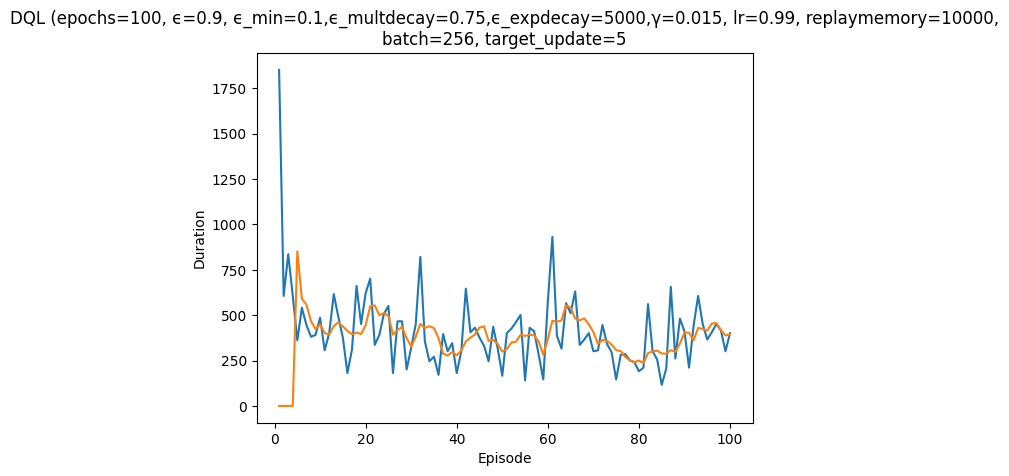

In [17]:
#dql
%matplotlib inline
random.seed(120394016)
dqn_with_defender = learner.epsilon_greedy_search(
    cyberbattle_gym_env=cyberbattlechain_defender,
    environment_properties=ep,
    learner=dqla.DeepQLearnerPolicy(
        ep=ep,
        gamma=0.015,
        replay_memory_size=10000,
        target_update=5,
        batch_size=256,
        learning_rate=0.99),
    episode_count=training_episode_count,
    iteration_count=iteration_count,
    epsilon=0.90,
    render=False,
    epsilon_multdecay=0.75,  # 0.999,
    epsilon_exponential_decay=5000,
    epsilon_minimum=0.10,
    verbosity=Verbosity.Quiet,
    title="DQL"
)

The average overall reward for the provided simulation episodes is approximately 5782.49.

Each episode represents a complete run of the simulation from start to finish.

The y-axis (Duration) indicates the length of each episode in terms of the number of iterations.

The x-axis represents each episode.

The duration appears to fluctuate, suggesting variability in how quickly the agent is learning or exploring the environment.

The printed output details the progress at each episode, showing the total reward accumulated and the types of actions taken. The agent receives rewards for successful exploration and exploitation actions within the environment, and the 'exploit deflected to exploration' count indicates instances where the agent's attempt to exploit was turned into an exploration step.

###### Q-learning
Learning with: episode_count=100,iteration_count=90000,ϵ=0.9,ϵ_min=0.1, ϵ_multdecay=0.75,ϵ_expdecay=5000,γ=0.015,learning_rate=0.99,Q%=100
  ## Episode: 1/100 'Q-learning' ϵ=0.9000, γ=0.015,learning_rate=0.99,Q%=100


Episode 1|Iteration 246|reward: 5620.0|last_reward_at:  246|Elapsed Time: 0:00:00||


  Episode 1 ended at t=246 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 7/41 (0.15)
    explore-remote: 8/77 (0.09)
    explore-connect: 2/87 (0.02)
    exploit-local: 1/1 (0.50)
    exploit-remote: 0/3 (0.00)
    exploit-connect: 4/15 (0.21)
  exploit deflected to exploration: 8
  ## Episode: 2/100 'Q-learning' ϵ=0.6463, γ=0.015,learning_rate=0.99,Q%=100


Episode 2|Iteration 101|reward: 5515.0|last_reward_at:  101|Elapsed Time: 0:00:00||


  Episode 2 ended at t=101 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 6/10 (0.38)
    explore-remote: 7/33 (0.17)
    explore-connect: 1/33 (0.03)
    exploit-local: 1/0 (1.00)
    exploit-remote: 1/1 (0.50)
    exploit-connect: 4/4 (0.50)
  exploit deflected to exploration: 5
  ## Episode: 3/100 'Q-learning' ϵ=0.6349, γ=0.015,learning_rate=0.99,Q%=100


Episode 3|Iteration 426|reward: 5639.0|last_reward_at:  426|Elapsed Time: 0:00:00||


  Episode 3 ended at t=426 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 8/69 (0.10)
    explore-remote: 10/113 (0.08)
    explore-connect: 0/141 (0.00)
    exploit-local: 2/2 (0.50)
    exploit-remote: 0/3 (0.00)
    exploit-connect: 5/73 (0.06)
  exploit deflected to exploration: 13
  ## Episode: 4/100 'Q-learning' ϵ=0.5892, γ=0.015,learning_rate=0.99,Q%=100


Episode 4|Iteration 226|reward: 5527.0|last_reward_at:  226|Elapsed Time: 0:00:00||


  Episode 4 ended at t=226 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 7/45 (0.13)
    explore-remote: 9/67 (0.12)
    explore-connect: 0/54 (0.00)
    exploit-local: 2/2 (0.50)
    exploit-remote: 1/3 (0.25)
    exploit-connect: 4/32 (0.11)
  exploit deflected to exploration: 3
  ## Episode: 5/100 'Q-learning' ϵ=0.5664, γ=0.015,learning_rate=0.99,Q%=100


Episode 5|Iteration 291|reward: 5746.0|last_reward_at:  291|Elapsed Time: 0:00:00||


  Episode 5 ended at t=291 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/42 (0.18)
    explore-remote: 9/75 (0.11)
    explore-connect: 0/74 (0.00)
    exploit-local: 2/2 (0.50)
    exploit-remote: 1/7 (0.12)
    exploit-connect: 6/64 (0.09)
  exploit deflected to exploration: 8
  ## Episode: 6/100 'Q-learning' ϵ=0.5386, γ=0.015,learning_rate=0.99,Q%=100


Episode 6|Iteration 276|reward: 5759.0|last_reward_at:  276|Elapsed Time: 0:00:00||


  Episode 6 ended at t=276 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 8/49 (0.14)
    explore-remote: 10/77 (0.11)
    explore-connect: 0/69 (0.00)
    exploit-local: 3/1 (0.75)
    exploit-remote: 1/6 (0.14)
    exploit-connect: 6/46 (0.12)
  exploit deflected to exploration: 7
  ## Episode: 7/100 'Q-learning' ϵ=0.5137, γ=0.015,learning_rate=0.99,Q%=100


Episode 7|Iteration 81|reward: 5510.0|last_reward_at:   81|Elapsed Time: 0:00:00||


  Episode 7 ended at t=81 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/8 (0.33)
    explore-remote: 8/13 (0.38)
    explore-connect: 0/24 (0.00)
    exploit-local: 3/5 (0.38)
    exploit-remote: 1/3 (0.25)
    exploit-connect: 4/8 (0.33)
  exploit deflected to exploration: 5
  ## Episode: 8/100 'Q-learning' ϵ=0.5067, γ=0.015,learning_rate=0.99,Q%=100


Episode 8|Iteration 261|reward: 5896.0|last_reward_at:  261|Elapsed Time: 0:00:00||


  Episode 8 ended at t=261 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 8/38 (0.17)
    explore-remote: 12/65 (0.16)
    explore-connect: 0/61 (0.00)
    exploit-local: 5/1 (0.83)
    exploit-remote: 1/8 (0.11)
    exploit-connect: 7/55 (0.11)
  exploit deflected to exploration: 15
  ## Episode: 9/100 'Q-learning' ϵ=0.4847, γ=0.015,learning_rate=0.99,Q%=100


Episode 9|Iteration 61|reward: 5490.0|last_reward_at:   61|Elapsed Time: 0:00:00||


  Episode 9 ended at t=61 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/9 (0.25)
    explore-remote: 6/8 (0.43)
    explore-connect: 1/16 (0.06)
    exploit-local: 3/3 (0.50)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 4/8 (0.33)
  exploit deflected to exploration: 1
  ## Episode: 10/100 'Q-learning' ϵ=0.4798, γ=0.015,learning_rate=0.99,Q%=100


Episode 10|Iteration 156|reward: 5612.0|last_reward_at:  156|Elapsed Time: 0:00:00||


  Episode 10 ended at t=156 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/24 (0.14)
    explore-remote: 8/27 (0.23)
    explore-connect: 1/45 (0.02)
    exploit-local: 3/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 4/40 (0.09)
  exploit deflected to exploration: 4
  ## Episode: 11/100 'Q-learning' ϵ=0.4673, γ=0.015,learning_rate=0.99,Q%=100


Episode 11|Iteration 156|reward: 5616.0|last_reward_at:  156|Elapsed Time: 0:00:00||


  Episode 11 ended at t=156 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/26 (0.13)
    explore-remote: 8/36 (0.18)
    explore-connect: 1/37 (0.03)
    exploit-local: 3/2 (0.60)
    exploit-remote: 1/5 (0.17)
    exploit-connect: 5/28 (0.15)
  exploit deflected to exploration: 10
  ## Episode: 12/100 'Q-learning' ϵ=0.4553, γ=0.015,learning_rate=0.99,Q%=100


Episode 12|Iteration 166|reward: 5624.0|last_reward_at:  166|Elapsed Time: 0:00:00||


  Episode 12 ended at t=166 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 6/27 (0.18)
    explore-remote: 10/31 (0.24)
    explore-connect: 0/37 (0.00)
    exploit-local: 3/2 (0.60)
    exploit-remote: 0/2 (0.00)
    exploit-connect: 5/43 (0.10)
  exploit deflected to exploration: 8
  ## Episode: 13/100 'Q-learning' ϵ=0.4429, γ=0.015,learning_rate=0.99,Q%=100


Episode 13|Iteration 51|reward: 5472.0|last_reward_at:   51|Elapsed Time: 0:00:00||


  Episode 13 ended at t=51 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/4 (0.20)
    explore-remote: 4/8 (0.33)
    explore-connect: 0/11 (0.00)
    exploit-local: 3/1 (0.75)
    exploit-remote: 0/1 (0.00)
    exploit-connect: 5/13 (0.28)
  exploit deflected to exploration: 0
  ## Episode: 14/100 'Q-learning' ϵ=0.4391, γ=0.015,learning_rate=0.99,Q%=100


Episode 14|Iteration 241|reward: 5874.0|last_reward_at:  241|Elapsed Time: 0:00:00||


  Episode 14 ended at t=241 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 7/44 (0.14)
    explore-remote: 12/47 (0.20)
    explore-connect: 0/42 (0.00)
    exploit-local: 4/6 (0.40)
    exploit-remote: 0/8 (0.00)
    exploit-connect: 8/63 (0.11)
  exploit deflected to exploration: 21
  ## Episode: 15/100 'Q-learning' ϵ=0.4220, γ=0.015,learning_rate=0.99,Q%=100


Episode 15|Iteration 371|reward: 5760.0|last_reward_at:  371|Elapsed Time: 0:00:00||


  Episode 15 ended at t=371 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 6/51 (0.11)
    explore-remote: 9/83 (0.10)
    explore-connect: 0/91 (0.00)
    exploit-local: 4/5 (0.44)
    exploit-remote: 4/9 (0.31)
    exploit-connect: 6/103 (0.06)
  exploit deflected to exploration: 24
  ## Episode: 16/100 'Q-learning' ϵ=0.3972, γ=0.015,learning_rate=0.99,Q%=100


Episode 16|Iteration 146|reward: 5742.0|last_reward_at:  146|Elapsed Time: 0:00:00||


  Episode 16 ended at t=146 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/15 (0.06)
    explore-remote: 9/25 (0.26)
    explore-connect: 0/43 (0.00)
    exploit-local: 7/2 (0.78)
    exploit-remote: 2/3 (0.40)
    exploit-connect: 7/32 (0.18)
  exploit deflected to exploration: 8
  ## Episode: 17/100 'Q-learning' ϵ=0.3879, γ=0.015,learning_rate=0.99,Q%=100


Episode 17|Iteration 296|reward: 5897.0|last_reward_at:  296|Elapsed Time: 0:00:00||


  Episode 17 ended at t=296 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 10/36 (0.22)
    explore-remote: 11/43 (0.20)
    explore-connect: 0/61 (0.00)
    exploit-local: 3/7 (0.30)
    exploit-remote: 1/13 (0.07)
    exploit-connect: 8/103 (0.07)
  exploit deflected to exploration: 19
  ## Episode: 18/100 'Q-learning' ϵ=0.3699, γ=0.015,learning_rate=0.99,Q%=100


Episode 18|Iteration 141|reward: 5622.0|last_reward_at:  141|Elapsed Time: 0:00:00||


  Episode 18 ended at t=141 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/10 (0.23)
    explore-remote: 8/17 (0.32)
    explore-connect: 1/47 (0.02)
    exploit-local: 5/2 (0.71)
    exploit-remote: 1/4 (0.20)
    exploit-connect: 5/38 (0.12)
  exploit deflected to exploration: 12
  ## Episode: 19/100 'Q-learning' ϵ=0.3617, γ=0.015,learning_rate=0.99,Q%=100


Episode 19|Iteration 16|reward: 5458.0|last_reward_at:   16|Elapsed Time: 0:00:00||


  Episode 19 ended at t=16 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/1 (0.50)
    explore-remote: 1/0 (1.00)
    explore-connect: 1/2 (0.33)
    exploit-local: 3/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 4/3 (0.57)
  exploit deflected to exploration: 2
  ## Episode: 20/100 'Q-learning' ϵ=0.3608, γ=0.015,learning_rate=0.99,Q%=100


Episode 20|Iteration 286|reward: 5740.0|last_reward_at:  286|Elapsed Time: 0:00:00||


  Episode 20 ended at t=286 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/40 (0.09)
    explore-remote: 9/59 (0.13)
    explore-connect: 0/55 (0.00)
    exploit-local: 5/7 (0.42)
    exploit-remote: 0/10 (0.00)
    exploit-connect: 7/90 (0.07)
  exploit deflected to exploration: 23
  ## Episode: 21/100 'Q-learning' ϵ=0.3449, γ=0.015,learning_rate=0.99,Q%=100


Episode 21|Iteration 186|reward: 5748.0|last_reward_at:  186|Elapsed Time: 0:00:00||


  Episode 21 ended at t=186 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/21 (0.19)
    explore-remote: 7/19 (0.27)
    explore-connect: 1/35 (0.03)
    exploit-local: 6/1 (0.86)
    exploit-remote: 2/5 (0.29)
    exploit-connect: 6/78 (0.07)
  exploit deflected to exploration: 8
  ## Episode: 22/100 'Q-learning' ϵ=0.3351, γ=0.015,learning_rate=0.99,Q%=100


Episode 22|Iteration 211|reward: 5632.0|last_reward_at:  211|Elapsed Time: 0:00:00||


  Episode 22 ended at t=211 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/30 (0.09)
    explore-remote: 9/36 (0.20)
    explore-connect: 1/36 (0.03)
    exploit-local: 6/5 (0.55)
    exploit-remote: 1/9 (0.10)
    exploit-connect: 5/70 (0.07)
  exploit deflected to exploration: 14
  ## Episode: 23/100 'Q-learning' ϵ=0.3243, γ=0.015,learning_rate=0.99,Q%=100


Episode 23|Iteration 36|reward: 5488.0|last_reward_at:   36|Elapsed Time: 0:00:00||


  Episode 23 ended at t=36 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/4 (0.20)
    explore-remote: 5/3 (0.62)
    explore-connect: 0/4 (0.00)
    exploit-local: 5/1 (0.83)
    exploit-remote: 1/1 (0.50)
    exploit-connect: 4/7 (0.36)
  exploit deflected to exploration: 7
  ## Episode: 24/100 'Q-learning' ϵ=0.3225, γ=0.015,learning_rate=0.99,Q%=100


Episode 24|Iteration 111|reward: 5859.0|last_reward_at:  111|Elapsed Time: 0:00:00||


  Episode 24 ended at t=111 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/12 (0.14)
    explore-remote: 10/12 (0.45)
    explore-connect: 0/17 (0.00)
    exploit-local: 7/0 (1.00)
    exploit-remote: 0/3 (0.00)
    exploit-connect: 8/40 (0.17)
  exploit deflected to exploration: 6
  ## Episode: 25/100 'Q-learning' ϵ=0.3171, γ=0.015,learning_rate=0.99,Q%=100


Episode 25|Iteration 531|reward: 5760.0|last_reward_at:  531|Elapsed Time: 0:00:00||


  Episode 25 ended at t=531 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/55 (0.05)
    explore-remote: 9/76 (0.11)
    explore-connect: 0/90 (0.00)
    exploit-local: 8/9 (0.47)
    exploit-remote: 2/13 (0.13)
    exploit-connect: 7/259 (0.03)
  exploit deflected to exploration: 19
  ## Episode: 26/100 'Q-learning' ϵ=0.2927, γ=0.015,learning_rate=0.99,Q%=100


Episode 26|Iteration 241|reward: 5762.0|last_reward_at:  241|Elapsed Time: 0:00:00||


  Episode 26 ended at t=241 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/23 (0.08)
    explore-remote: 10/33 (0.23)
    explore-connect: 1/38 (0.03)
    exploit-local: 9/2 (0.82)
    exploit-remote: 2/6 (0.25)
    exploit-connect: 6/109 (0.05)
  exploit deflected to exploration: 13
  ## Episode: 27/100 'Q-learning' ϵ=0.2825, γ=0.015,learning_rate=0.99,Q%=100


Episode 27|Iteration 321|reward: 5765.0|last_reward_at:  321|Elapsed Time: 0:00:00||


  Episode 27 ended at t=321 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/36 (0.10)
    explore-remote: 6/53 (0.10)
    explore-connect: 0/38 (0.00)
    exploit-local: 8/14 (0.36)
    exploit-remote: 6/17 (0.26)
    exploit-connect: 6/133 (0.04)
  exploit deflected to exploration: 28
  ## Episode: 28/100 'Q-learning' ϵ=0.2696, γ=0.015,learning_rate=0.99,Q%=100


Episode 28|Iteration 261|reward: 5759.0|last_reward_at:  261|Elapsed Time: 0:00:00||


  Episode 28 ended at t=261 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/24 (0.17)
    explore-remote: 7/35 (0.17)
    explore-connect: 0/45 (0.00)
    exploit-local: 6/5 (0.55)
    exploit-remote: 4/8 (0.33)
    exploit-connect: 7/115 (0.06)
  exploit deflected to exploration: 22
  ## Episode: 29/100 'Q-learning' ϵ=0.2597, γ=0.015,learning_rate=0.99,Q%=100


Episode 29|Iteration 231|reward: 5761.0|last_reward_at:  231|Elapsed Time: 0:00:00||


  Episode 29 ended at t=231 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/17 (0.11)
    explore-remote: 10/32 (0.24)
    explore-connect: 0/39 (0.00)
    exploit-local: 9/9 (0.50)
    exploit-remote: 2/8 (0.20)
    exploit-connect: 6/97 (0.06)
  exploit deflected to exploration: 24
  ## Episode: 30/100 'Q-learning' ϵ=0.2513, γ=0.015,learning_rate=0.99,Q%=100


Episode 30|Iteration 201|reward: 5624.0|last_reward_at:  201|Elapsed Time: 0:00:00||


  Episode 30 ended at t=201 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/12 (0.20)
    explore-remote: 5/19 (0.21)
    explore-connect: 1/32 (0.03)
    exploit-local: 5/4 (0.56)
    exploit-remote: 4/7 (0.36)
    exploit-connect: 5/104 (0.05)
  exploit deflected to exploration: 9
  ## Episode: 31/100 'Q-learning' ϵ=0.2444, γ=0.015,learning_rate=0.99,Q%=100


Episode 31|Iteration 51|reward: 5488.0|last_reward_at:   51|Elapsed Time: 0:00:00||


  Episode 31 ended at t=51 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/5 (0.44)
    explore-remote: 2/7 (0.22)
    explore-connect: 0/8 (0.00)
    exploit-local: 2/3 (0.40)
    exploit-remote: 4/5 (0.44)
    exploit-connect: 5/6 (0.45)
  exploit deflected to exploration: 8
  ## Episode: 32/100 'Q-learning' ϵ=0.2427, γ=0.015,learning_rate=0.99,Q%=100


Episode 32|Iteration 196|reward: 5745.0|last_reward_at:  196|Elapsed Time: 0:00:00||


  Episode 32 ended at t=196 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/11 (0.08)
    explore-remote: 8/21 (0.28)
    explore-connect: 0/30 (0.00)
    exploit-local: 10/4 (0.71)
    exploit-remote: 0/1 (0.00)
    exploit-connect: 7/103 (0.06)
  exploit deflected to exploration: 12
  ## Episode: 33/100 'Q-learning' ϵ=0.2362, γ=0.015,learning_rate=0.99,Q%=100


Episode 33|Iteration 46|reward: 5362.0|last_reward_at:   46|Elapsed Time: 0:00:00||


  Episode 33 ended at t=46 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/3 (0.00)
    explore-remote: 2/6 (0.25)
    explore-connect: 0/9 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 1/2 (0.33)
    exploit-connect: 4/15 (0.21)
  exploit deflected to exploration: 4
  ## Episode: 34/100 'Q-learning' ϵ=0.2347, γ=0.015,learning_rate=0.99,Q%=100


Episode 34|Iteration 71|reward: 5718.0|last_reward_at:   71|Elapsed Time: 0:00:00||


  Episode 34 ended at t=71 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/7 (0.22)
    explore-remote: 6/8 (0.43)
    explore-connect: 0/14 (0.00)
    exploit-local: 5/3 (0.62)
    exploit-remote: 2/2 (0.50)
    exploit-connect: 7/15 (0.32)
  exploit deflected to exploration: 14
  ## Episode: 35/100 'Q-learning' ϵ=0.2325, γ=0.015,learning_rate=0.99,Q%=100


Episode 35|Iteration 256|reward: 5752.0|last_reward_at:  256|Elapsed Time: 0:00:00||


  Episode 35 ended at t=256 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/20 (0.13)
    explore-remote: 8/33 (0.20)
    explore-connect: 0/29 (0.00)
    exploit-local: 7/7 (0.50)
    exploit-remote: 3/9 (0.25)
    exploit-connect: 7/130 (0.05)
  exploit deflected to exploration: 12
  ## Episode: 36/100 'Q-learning' ϵ=0.2246, γ=0.015,learning_rate=0.99,Q%=100


Episode 36|Iteration 101|reward: 5974.0|last_reward_at:  101|Elapsed Time: 0:00:00||


  Episode 36 ended at t=101 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/12 (0.25)
    explore-remote: 5/4 (0.56)
    explore-connect: 0/12 (0.00)
    exploit-local: 7/1 (0.88)
    exploit-remote: 7/7 (0.50)
    exploit-connect: 9/33 (0.21)
  exploit deflected to exploration: 9
  ## Episode: 37/100 'Q-learning' ϵ=0.2216, γ=0.015,learning_rate=0.99,Q%=100


Episode 37|Iteration 46|reward: 5704.0|last_reward_at:   46|Elapsed Time: 0:00:00||


  Episode 37 ended at t=46 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/3 (0.25)
    explore-remote: 1/3 (0.25)
    explore-connect: 1/5 (0.17)
    exploit-local: 7/3 (0.70)
    exploit-remote: 1/1 (0.50)
    exploit-connect: 6/14 (0.30)
  exploit deflected to exploration: 5
  ## Episode: 38/100 'Q-learning' ϵ=0.2203, γ=0.015,learning_rate=0.99,Q%=100


Episode 38|Iteration 106|reward: 5600.0|last_reward_at:  106|Elapsed Time: 0:00:00||


  Episode 38 ended at t=106 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/8 (0.11)
    explore-remote: 6/10 (0.38)
    explore-connect: 0/23 (0.00)
    exploit-local: 5/2 (0.71)
    exploit-remote: 2/7 (0.22)
    exploit-connect: 6/36 (0.14)
  exploit deflected to exploration: 12
  ## Episode: 39/100 'Q-learning' ϵ=0.2172, γ=0.015,learning_rate=0.99,Q%=100


Episode 39|Iteration 61|reward: 5714.0|last_reward_at:   61|Elapsed Time: 0:00:00||


  Episode 39 ended at t=61 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/1 (0.50)
    explore-remote: 5/7 (0.42)
    explore-connect: 0/9 (0.00)
    exploit-local: 6/4 (0.60)
    exploit-remote: 1/4 (0.20)
    exploit-connect: 7/16 (0.30)
  exploit deflected to exploration: 7
  ## Episode: 40/100 'Q-learning' ϵ=0.2155, γ=0.015,learning_rate=0.99,Q%=100


Episode 40|Iteration 61|reward: 5580.0|last_reward_at:   61|Elapsed Time: 0:00:00||


  Episode 40 ended at t=61 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/4 (0.00)
    explore-remote: 2/3 (0.40)
    explore-connect: 0/10 (0.00)
    exploit-local: 6/1 (0.86)
    exploit-remote: 1/1 (0.50)
    exploit-connect: 5/28 (0.15)
  exploit deflected to exploration: 3
  ## Episode: 41/100 'Q-learning' ϵ=0.2138, γ=0.015,learning_rate=0.99,Q%=100


Episode 41|Iteration 291|reward: 5636.0|last_reward_at:  291|Elapsed Time: 0:00:00||


  Episode 41 ended at t=291 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/28 (0.12)
    explore-remote: 4/28 (0.12)
    explore-connect: 0/38 (0.00)
    exploit-local: 5/14 (0.26)
    exploit-remote: 6/18 (0.25)
    exploit-connect: 6/140 (0.04)
  exploit deflected to exploration: 27
  ## Episode: 42/100 'Q-learning' ϵ=0.2060, γ=0.015,learning_rate=0.99,Q%=100


Episode 42|Iteration 141|reward: 5507.0|last_reward_at:  141|Elapsed Time: 0:00:00||


  Episode 42 ended at t=141 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/12 (0.08)
    explore-remote: 6/14 (0.30)
    explore-connect: 0/18 (0.00)
    exploit-local: 5/3 (0.62)
    exploit-remote: 3/10 (0.23)
    exploit-connect: 5/64 (0.07)
  exploit deflected to exploration: 15
  ## Episode: 43/100 'Q-learning' ϵ=0.2023, γ=0.015,learning_rate=0.99,Q%=100


Episode 43|Iteration 106|reward: 5622.0|last_reward_at:  106|Elapsed Time: 0:00:00||


  Episode 43 ended at t=106 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/6 (0.14)
    explore-remote: 6/18 (0.25)
    explore-connect: 0/15 (0.00)
    exploit-local: 7/6 (0.54)
    exploit-remote: 2/9 (0.18)
    exploit-connect: 6/30 (0.17)
  exploit deflected to exploration: 15
  ## Episode: 44/100 'Q-learning' ϵ=0.1997, γ=0.015,learning_rate=0.99,Q%=100


Episode 44|Iteration 61|reward: 5596.0|last_reward_at:   61|Elapsed Time: 0:00:00||


  Episode 44 ended at t=61 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/2 (0.50)
    explore-remote: 3/8 (0.27)
    explore-connect: 0/9 (0.00)
    exploit-local: 5/1 (0.83)
    exploit-remote: 2/9 (0.18)
    exploit-connect: 5/15 (0.25)
  exploit deflected to exploration: 10
  ## Episode: 45/100 'Q-learning' ϵ=0.1981, γ=0.015,learning_rate=0.99,Q%=100


Episode 45|Iteration 276|reward: 5864.0|last_reward_at:  276|Elapsed Time: 0:00:00||


  Episode 45 ended at t=276 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/30 (0.14)
    explore-remote: 6/26 (0.19)
    explore-connect: 1/33 (0.03)
    exploit-local: 7/7 (0.50)
    exploit-remote: 4/14 (0.22)
    exploit-connect: 7/136 (0.05)
  exploit deflected to exploration: 26
  ## Episode: 46/100 'Q-learning' ϵ=0.1915, γ=0.015,learning_rate=0.99,Q%=100


Episode 46|Iteration 186|reward: 5523.0|last_reward_at:  186|Elapsed Time: 0:00:00||


  Episode 46 ended at t=186 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 6/17 (0.26)
    explore-remote: 4/20 (0.17)
    explore-connect: 0/26 (0.00)
    exploit-local: 3/10 (0.23)
    exploit-remote: 6/22 (0.21)
    exploit-connect: 4/68 (0.06)
  exploit deflected to exploration: 19
  ## Episode: 47/100 'Q-learning' ϵ=0.1873, γ=0.015,learning_rate=0.99,Q%=100


Episode 47|Iteration 61|reward: 5592.0|last_reward_at:   61|Elapsed Time: 0:00:00||


  Episode 47 ended at t=61 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/1 (0.50)
    explore-remote: 2/3 (0.40)
    explore-connect: 0/10 (0.00)
    exploit-local: 5/7 (0.42)
    exploit-remote: 2/1 (0.67)
    exploit-connect: 6/23 (0.21)
  exploit deflected to exploration: 11
  ## Episode: 48/100 'Q-learning' ϵ=0.1859, γ=0.015,learning_rate=0.99,Q%=100


Episode 48|Iteration 86|reward: 5608.0|last_reward_at:   86|Elapsed Time: 0:00:00||


  Episode 48 ended at t=86 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/5 (0.29)
    explore-remote: 7/7 (0.50)
    explore-connect: 0/12 (0.00)
    exploit-local: 5/3 (0.62)
    exploit-remote: 0/5 (0.00)
    exploit-connect: 6/34 (0.15)
  exploit deflected to exploration: 9
  ## Episode: 49/100 'Q-learning' ϵ=0.1840, γ=0.015,learning_rate=0.99,Q%=100


Episode 49|Iteration 66|reward: 5470.0|last_reward_at:   66|Elapsed Time: 0:00:00||


  Episode 49 ended at t=66 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/4 (0.00)
    explore-remote: 3/6 (0.33)
    explore-connect: 0/17 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 0/5 (0.00)
    exploit-connect: 5/22 (0.19)
  exploit deflected to exploration: 6
  ## Episode: 50/100 'Q-learning' ϵ=0.1826, γ=0.015,learning_rate=0.99,Q%=100


Episode 50|Iteration 366|reward: 6128.0|last_reward_at:  366|Elapsed Time: 0:00:00||


  Episode 50 ended at t=366 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 6/26 (0.19)
    explore-remote: 11/36 (0.23)
    explore-connect: 0/42 (0.00)
    exploit-local: 10/16 (0.38)
    exploit-remote: 4/19 (0.17)
    exploit-connect: 9/187 (0.05)
  exploit deflected to exploration: 37
  ## Episode: 51/100 'Q-learning' ϵ=0.1750, γ=0.015,learning_rate=0.99,Q%=100


Episode 51|Iteration 46|reward: 5593.0|last_reward_at:   46|Elapsed Time: 0:00:00||


  Episode 51 ended at t=46 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/5 (0.17)
    explore-remote: 2/2 (0.50)
    explore-connect: 0/8 (0.00)
    exploit-local: 6/3 (0.67)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/14 (0.26)
  exploit deflected to exploration: 7
  ## Episode: 52/100 'Q-learning' ϵ=0.1741, γ=0.015,learning_rate=0.99,Q%=100


Episode 52|Iteration 171|reward: 5944.0|last_reward_at:  171|Elapsed Time: 0:00:00||


  Episode 52 ended at t=171 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/15 (0.12)
    explore-remote: 3/16 (0.16)
    explore-connect: 0/20 (0.00)
    exploit-local: 8/9 (0.47)
    exploit-remote: 3/13 (0.19)
    exploit-connect: 9/73 (0.11)
  exploit deflected to exploration: 23
  ## Episode: 53/100 'Q-learning' ϵ=0.1707, γ=0.015,learning_rate=0.99,Q%=100


Episode 53|Iteration 146|reward: 5604.0|last_reward_at:  146|Elapsed Time: 0:00:00||


  Episode 53 ended at t=146 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/14 (0.07)
    explore-remote: 6/9 (0.40)
    explore-connect: 0/12 (0.00)
    exploit-local: 7/6 (0.54)
    exploit-remote: 1/5 (0.17)
    exploit-connect: 5/80 (0.06)
  exploit deflected to exploration: 16
  ## Episode: 54/100 'Q-learning' ϵ=0.1680, γ=0.015,learning_rate=0.99,Q%=100


Episode 54|Iteration 101|reward: 5716.0|last_reward_at:  101|Elapsed Time: 0:00:00||


  Episode 54 ended at t=101 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/5 (0.44)
    explore-remote: 2/6 (0.25)
    explore-connect: 0/12 (0.00)
    exploit-local: 4/6 (0.40)
    exploit-remote: 2/6 (0.25)
    exploit-connect: 7/47 (0.13)
  exploit deflected to exploration: 6
  ## Episode: 55/100 'Q-learning' ϵ=0.1661, γ=0.015,learning_rate=0.99,Q%=100


Episode 55|Iteration 136|reward: 5602.0|last_reward_at:  136|Elapsed Time: 0:00:00||


  Episode 55 ended at t=136 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/8 (0.27)
    explore-remote: 4/11 (0.27)
    explore-connect: 0/16 (0.00)
    exploit-local: 4/7 (0.36)
    exploit-remote: 2/7 (0.22)
    exploit-connect: 6/68 (0.08)
  exploit deflected to exploration: 19
  ## Episode: 56/100 'Q-learning' ϵ=0.1637, γ=0.015,learning_rate=0.99,Q%=100


Episode 56|Iteration 141|reward: 5606.0|last_reward_at:  141|Elapsed Time: 0:00:00||


  Episode 56 ended at t=141 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/12 (0.00)
    explore-remote: 6/9 (0.40)
    explore-connect: 0/20 (0.00)
    exploit-local: 5/2 (0.71)
    exploit-remote: 3/10 (0.23)
    exploit-connect: 6/68 (0.08)
  exploit deflected to exploration: 7
  ## Episode: 57/100 'Q-learning' ϵ=0.1612, γ=0.015,learning_rate=0.99,Q%=100


Episode 57|Iteration 206|reward: 5850.0|last_reward_at:  206|Elapsed Time: 0:00:00||


  Episode 57 ended at t=206 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/12 (0.14)
    explore-remote: 4/13 (0.24)
    explore-connect: 0/15 (0.00)
    exploit-local: 8/3 (0.73)
    exploit-remote: 5/6 (0.45)
    exploit-connect: 8/130 (0.06)
  exploit deflected to exploration: 7
  ## Episode: 58/100 'Q-learning' ϵ=0.1577, γ=0.015,learning_rate=0.99,Q%=100


Episode 58|Iteration 231|reward: 5728.0|last_reward_at:  231|Elapsed Time: 0:00:00||


  Episode 58 ended at t=231 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/11 (0.15)
    explore-remote: 4/19 (0.17)
    explore-connect: 0/27 (0.00)
    exploit-local: 6/5 (0.55)
    exploit-remote: 4/13 (0.24)
    exploit-connect: 7/133 (0.05)
  exploit deflected to exploration: 23
  ## Episode: 59/100 'Q-learning' ϵ=0.1540, γ=0.015,learning_rate=0.99,Q%=100


Episode 59|Iteration 86|reward: 5854.0|last_reward_at:   86|Elapsed Time: 0:00:00||


  Episode 59 ended at t=86 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/10 (0.23)
    explore-remote: 7/3 (0.70)
    explore-connect: 0/14 (0.00)
    exploit-local: 9/8 (0.53)
    exploit-remote: 0/4 (0.00)
    exploit-connect: 8/20 (0.29)
  exploit deflected to exploration: 13
  ## Episode: 60/100 'Q-learning' ϵ=0.1527, γ=0.015,learning_rate=0.99,Q%=100


Episode 60|Iteration 31|reward: 5576.0|last_reward_at:   31|Elapsed Time: 0:00:00||


  Episode 60 ended at t=31 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/5 (0.00)
    explore-remote: 0/3 (0.00)
    explore-connect: 0/2 (0.00)
    exploit-local: 6/2 (0.75)
    exploit-remote: 0/1 (0.00)
    exploit-connect: 6/6 (0.50)
  exploit deflected to exploration: 4
  ## Episode: 61/100 'Q-learning' ϵ=0.1522, γ=0.015,learning_rate=0.99,Q%=100


Episode 61|Iteration 371|reward: 5758.0|last_reward_at:  371|Elapsed Time: 0:00:00||


  Episode 61 ended at t=371 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/37 (0.10)
    explore-remote: 8/32 (0.20)
    explore-connect: 0/42 (0.00)
    exploit-local: 7/23 (0.23)
    exploit-remote: 3/26 (0.10)
    exploit-connect: 7/182 (0.04)
  exploit deflected to exploration: 55
  ## Episode: 62/100 'Q-learning' ϵ=0.1467, γ=0.015,learning_rate=0.99,Q%=100


Episode 62|Iteration 21|reward: 5476.0|last_reward_at:   21|Elapsed Time: 0:00:00||


  Episode 62 ended at t=21 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/1 (0.50)
    explore-remote: 3/1 (0.75)
    explore-connect: 0/3 (0.00)
    exploit-local: 5/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 4/3 (0.57)
  exploit deflected to exploration: 5
  ## Episode: 63/100 'Q-learning' ϵ=0.1464, γ=0.015,learning_rate=0.99,Q%=100


Episode 63|Iteration 121|reward: 5523.0|last_reward_at:  121|Elapsed Time: 0:00:00||


  Episode 63 ended at t=121 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/7 (0.22)
    explore-remote: 5/8 (0.38)
    explore-connect: 0/14 (0.00)
    exploit-local: 6/6 (0.50)
    exploit-remote: 4/19 (0.17)
    exploit-connect: 5/45 (0.10)
  exploit deflected to exploration: 10
  ## Episode: 64/100 'Q-learning' ϵ=0.1447, γ=0.015,learning_rate=0.99,Q%=100


Episode 64|Iteration 76|reward: 5740.0|last_reward_at:   76|Elapsed Time: 0:00:00||


  Episode 64 ended at t=76 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/4 (0.20)
    explore-remote: 6/6 (0.50)
    explore-connect: 0/9 (0.00)
    exploit-local: 9/3 (0.75)
    exploit-remote: 1/5 (0.17)
    exploit-connect: 7/25 (0.22)
  exploit deflected to exploration: 12
  ## Episode: 65/100 'Q-learning' ϵ=0.1436, γ=0.015,learning_rate=0.99,Q%=100


Episode 65|Iteration 126|reward: 5505.0|last_reward_at:  126|Elapsed Time: 0:00:00||


  Episode 65 ended at t=126 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/5 (0.17)
    explore-remote: 4/8 (0.33)
    explore-connect: 0/21 (0.00)
    exploit-local: 7/5 (0.58)
    exploit-remote: 2/2 (0.50)
    exploit-connect: 5/66 (0.07)
  exploit deflected to exploration: 12
  ## Episode: 66/100 'Q-learning' ϵ=0.1419, γ=0.015,learning_rate=0.99,Q%=100


Episode 66|Iteration 151|reward: 5748.0|last_reward_at:  151|Elapsed Time: 0:00:00||


  Episode 66 ended at t=151 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/13 (0.00)
    explore-remote: 6/18 (0.25)
    explore-connect: 0/17 (0.00)
    exploit-local: 10/9 (0.53)
    exploit-remote: 4/8 (0.33)
    exploit-connect: 7/59 (0.11)
  exploit deflected to exploration: 26
  ## Episode: 67/100 'Q-learning' ϵ=0.1399, γ=0.015,learning_rate=0.99,Q%=100


Episode 67|Iteration 186|reward: 5630.0|last_reward_at:  186|Elapsed Time: 0:00:00||


  Episode 67 ended at t=186 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/14 (0.12)
    explore-remote: 7/17 (0.29)
    explore-connect: 0/22 (0.00)
    exploit-local: 7/12 (0.37)
    exploit-remote: 1/14 (0.07)
    exploit-connect: 6/84 (0.07)
  exploit deflected to exploration: 21
  ## Episode: 68/100 'Q-learning' ϵ=0.1375, γ=0.015,learning_rate=0.99,Q%=100


Episode 68|Iteration 206|reward: 5749.0|last_reward_at:  206|Elapsed Time: 0:00:00||


  Episode 68 ended at t=206 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/18 (0.05)
    explore-remote: 7/15 (0.32)
    explore-connect: 0/28 (0.00)
    exploit-local: 8/6 (0.57)
    exploit-remote: 5/17 (0.23)
    exploit-connect: 6/95 (0.06)
  exploit deflected to exploration: 26
  ## Episode: 69/100 'Q-learning' ϵ=0.1350, γ=0.015,learning_rate=0.99,Q%=100


Episode 69|Iteration 81|reward: 5730.0|last_reward_at:   81|Elapsed Time: 0:00:00||


  Episode 69 ended at t=81 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/4 (0.43)
    explore-remote: 2/1 (0.67)
    explore-connect: 0/13 (0.00)
    exploit-local: 8/2 (0.80)
    exploit-remote: 3/4 (0.43)
    exploit-connect: 6/35 (0.15)
  exploit deflected to exploration: 8
  ## Episode: 70/100 'Q-learning' ϵ=0.1340, γ=0.015,learning_rate=0.99,Q%=100


Episode 70|Iteration 116|reward: 5614.0|last_reward_at:  116|Elapsed Time: 0:00:00||


  Episode 70 ended at t=116 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/6 (0.25)
    explore-remote: 6/11 (0.35)
    explore-connect: 0/10 (0.00)
    exploit-local: 6/4 (0.60)
    exploit-remote: 1/13 (0.07)
    exploit-connect: 5/52 (0.09)
  exploit deflected to exploration: 13
  ## Episode: 71/100 'Q-learning' ϵ=0.1327, γ=0.015,learning_rate=0.99,Q%=100


Episode 71|Iteration 191|reward: 5399.0|last_reward_at:  191|Elapsed Time: 0:00:00||


  Episode 71 ended at t=191 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/9 (0.18)
    explore-remote: 7/22 (0.24)
    explore-connect: 0/19 (0.00)
    exploit-local: 4/13 (0.24)
    exploit-remote: 2/10 (0.17)
    exploit-connect: 3/100 (0.03)
  exploit deflected to exploration: 27
  ## Episode: 72/100 'Q-learning' ϵ=0.1305, γ=0.015,learning_rate=0.99,Q%=100


Episode 72|Iteration 151|reward: 5775.0|last_reward_at:  151|Elapsed Time: 0:00:00||


  Episode 72 ended at t=151 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/12 (0.25)
    explore-remote: 7/16 (0.30)
    explore-connect: 0/19 (0.00)
    exploit-local: 8/9 (0.47)
    exploit-remote: 5/20 (0.20)
    exploit-connect: 7/44 (0.14)
  exploit deflected to exploration: 34
  ## Episode: 73/100 'Q-learning' ϵ=0.1289, γ=0.015,learning_rate=0.99,Q%=100


Episode 73|Iteration 56|reward: 5617.0|last_reward_at:   56|Elapsed Time: 0:00:00||


  Episode 73 ended at t=56 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/4 (0.50)
    explore-remote: 5/3 (0.62)
    explore-connect: 0/6 (0.00)
    exploit-local: 5/4 (0.56)
    exploit-remote: 0/1 (0.00)
    exploit-connect: 5/19 (0.21)
  exploit deflected to exploration: 9
  ## Episode: 74/100 'Q-learning' ϵ=0.1283, γ=0.015,learning_rate=0.99,Q%=100


Episode 74|Iteration 96|reward: 5600.0|last_reward_at:   96|Elapsed Time: 0:00:00||


  Episode 74 ended at t=96 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/5 (0.17)
    explore-remote: 2/10 (0.17)
    explore-connect: 0/8 (0.00)
    exploit-local: 6/4 (0.60)
    exploit-remote: 3/8 (0.27)
    exploit-connect: 6/43 (0.12)
  exploit deflected to exploration: 9
  ## Episode: 75/100 'Q-learning' ϵ=0.1273, γ=0.015,learning_rate=0.99,Q%=100


Episode 75|Iteration 206|reward: 5866.0|last_reward_at:  206|Elapsed Time: 0:00:00||


  Episode 75 ended at t=206 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/10 (0.33)
    explore-remote: 6/6 (0.50)
    explore-connect: 0/25 (0.00)
    exploit-local: 6/14 (0.30)
    exploit-remote: 5/17 (0.23)
    exploit-connect: 8/104 (0.07)
  exploit deflected to exploration: 19
  ## Episode: 76/100 'Q-learning' ϵ=0.1252, γ=0.015,learning_rate=0.99,Q%=100


Episode 76|Iteration 126|reward: 5846.0|last_reward_at:  126|Elapsed Time: 0:00:00||


  Episode 76 ended at t=126 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/7 (0.12)
    explore-remote: 8/7 (0.53)
    explore-connect: 0/20 (0.00)
    exploit-local: 8/0 (1.00)
    exploit-remote: 3/5 (0.38)
    exploit-connect: 7/60 (0.10)
  exploit deflected to exploration: 22
  ## Episode: 77/100 'Q-learning' ϵ=0.1239, γ=0.015,learning_rate=0.99,Q%=100


Episode 77|Iteration 81|reward: 5613.0|last_reward_at:   81|Elapsed Time: 0:00:00||


  Episode 77 ended at t=81 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/4 (0.33)
    explore-remote: 1/5 (0.17)
    explore-connect: 0/6 (0.00)
    exploit-local: 6/5 (0.55)
    exploit-remote: 5/6 (0.45)
    exploit-connect: 6/35 (0.15)
  exploit deflected to exploration: 9
  ## Episode: 78/100 'Q-learning' ϵ=0.1231, γ=0.015,learning_rate=0.99,Q%=100


Episode 78|Iteration 76|reward: 5706.0|last_reward_at:   76|Elapsed Time: 0:00:00||


  Episode 78 ended at t=76 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/5 (0.00)
    explore-remote: 3/6 (0.33)
    explore-connect: 0/8 (0.00)
    exploit-local: 6/0 (1.00)
    exploit-remote: 3/0 (1.00)
    exploit-connect: 6/39 (0.13)
  exploit deflected to exploration: 8
  ## Episode: 79/100 'Q-learning' ϵ=0.1224, γ=0.015,learning_rate=0.99,Q%=100


Episode 79|Iteration 196|reward: 5495.0|last_reward_at:  196|Elapsed Time: 0:00:00||


  Episode 79 ended at t=196 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/4 (0.00)
    explore-remote: 6/16 (0.27)
    explore-connect: 1/20 (0.05)
    exploit-local: 6/6 (0.50)
    exploit-remote: 1/11 (0.08)
    exploit-connect: 4/121 (0.03)
  exploit deflected to exploration: 17
  ## Episode: 80/100 'Q-learning' ϵ=0.1206, γ=0.015,learning_rate=0.99,Q%=100


Episode 80|Iteration 186|reward: 5736.0|last_reward_at:  186|Elapsed Time: 0:00:00||


  Episode 80 ended at t=186 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/8 (0.33)
    explore-remote: 3/9 (0.25)
    explore-connect: 0/17 (0.00)
    exploit-local: 5/6 (0.45)
    exploit-remote: 5/16 (0.24)
    exploit-connect: 7/106 (0.06)
  exploit deflected to exploration: 16
  ## Episode: 81/100 'Q-learning' ϵ=0.1189, γ=0.015,learning_rate=0.99,Q%=100


Episode 81|Iteration 136|reward: 5604.0|last_reward_at:  136|Elapsed Time: 0:00:00||


  Episode 81 ended at t=136 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/8 (0.27)
    explore-remote: 2/5 (0.29)
    explore-connect: 0/13 (0.00)
    exploit-local: 5/5 (0.50)
    exploit-remote: 4/4 (0.50)
    exploit-connect: 6/81 (0.07)
  exploit deflected to exploration: 7
  ## Episode: 82/100 'Q-learning' ϵ=0.1177, γ=0.015,learning_rate=0.99,Q%=100


Episode 82|Iteration 146|reward: 5716.0|last_reward_at:  146|Elapsed Time: 0:00:00||


  Episode 82 ended at t=146 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/7 (0.30)
    explore-remote: 5/8 (0.38)
    explore-connect: 0/11 (0.00)
    exploit-local: 5/1 (0.83)
    exploit-remote: 0/5 (0.00)
    exploit-connect: 7/94 (0.07)
  exploit deflected to exploration: 11
  ## Episode: 83/100 'Q-learning' ϵ=0.1165, γ=0.015,learning_rate=0.99,Q%=100


Episode 83|Iteration 251|reward: 5881.0|last_reward_at:  251|Elapsed Time: 0:00:00||


  Episode 83 ended at t=251 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 6/18 (0.25)
    explore-remote: 11/9 (0.55)
    explore-connect: 0/18 (0.00)
    exploit-local: 7/3 (0.70)
    exploit-remote: 1/14 (0.07)
    exploit-connect: 7/157 (0.04)
  exploit deflected to exploration: 21
  ## Episode: 84/100 'Q-learning' ϵ=0.1145, γ=0.015,learning_rate=0.99,Q%=100


Episode 84|Iteration 146|reward: 5515.0|last_reward_at:  146|Elapsed Time: 0:00:00||


  Episode 84 ended at t=146 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/5 (0.38)
    explore-remote: 5/3 (0.62)
    explore-connect: 0/10 (0.00)
    exploit-local: 5/7 (0.42)
    exploit-remote: 3/16 (0.16)
    exploit-connect: 5/84 (0.06)
  exploit deflected to exploration: 11
  ## Episode: 85/100 'Q-learning' ϵ=0.1133, γ=0.015,learning_rate=0.99,Q%=100


Episode 85|Iteration 71|reward: 5482.0|last_reward_at:   71|Elapsed Time: 0:00:00||


  Episode 85 ended at t=71 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/1 (0.00)
    explore-remote: 3/10 (0.23)
    explore-connect: 0/11 (0.00)
    exploit-local: 5/1 (0.83)
    exploit-remote: 4/10 (0.29)
    exploit-connect: 4/22 (0.15)
  exploit deflected to exploration: 11
  ## Episode: 86/100 'Q-learning' ϵ=0.1128, γ=0.015,learning_rate=0.99,Q%=100


Episode 86|Iteration 186|reward: 5970.0|last_reward_at:  186|Elapsed Time: 0:00:00||


  Episode 86 ended at t=186 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/6 (0.33)
    explore-remote: 7/9 (0.44)
    explore-connect: 0/14 (0.00)
    exploit-local: 8/1 (0.89)
    exploit-remote: 3/4 (0.43)
    exploit-connect: 9/122 (0.07)
  exploit deflected to exploration: 9
  ## Episode: 87/100 'Q-learning' ϵ=0.1114, γ=0.015,learning_rate=0.99,Q%=100


Episode 87|Iteration 101|reward: 5856.0|last_reward_at:  101|Elapsed Time: 0:00:00||


  Episode 87 ended at t=101 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/3 (0.50)
    explore-remote: 5/4 (0.56)
    explore-connect: 0/12 (0.00)
    exploit-local: 9/3 (0.75)
    exploit-remote: 3/4 (0.43)
    exploit-connect: 7/48 (0.13)
  exploit deflected to exploration: 11
  ## Episode: 88/100 'Q-learning' ϵ=0.1107, γ=0.015,learning_rate=0.99,Q%=100


Episode 88|Iteration 546|reward: 5866.0|last_reward_at:  546|Elapsed Time: 0:00:01||


  Episode 88 ended at t=546 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/27 (0.13)
    explore-remote: 8/37 (0.18)
    explore-connect: 0/41 (0.00)
    exploit-local: 7/18 (0.28)
    exploit-remote: 4/17 (0.19)
    exploit-connect: 8/375 (0.02)
  exploit deflected to exploration: 28
  ## Episode: 89/100 'Q-learning' ϵ=0.1070, γ=0.015,learning_rate=0.99,Q%=100


Episode 89|Iteration 141|reward: 5496.0|last_reward_at:  141|Elapsed Time: 0:00:00||


  Episode 89 ended at t=141 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/4 (0.20)
    explore-remote: 1/18 (0.05)
    explore-connect: 0/10 (0.00)
    exploit-local: 6/9 (0.40)
    exploit-remote: 5/13 (0.28)
    exploit-connect: 5/69 (0.07)
  exploit deflected to exploration: 16
  ## Episode: 90/100 'Q-learning' ϵ=0.1061, γ=0.015,learning_rate=0.99,Q%=100


Episode 90|Iteration 441|reward: 5632.0|last_reward_at:  441|Elapsed Time: 0:00:00||


  Episode 90 ended at t=441 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/27 (0.04)
    explore-remote: 2/31 (0.06)
    explore-connect: 0/42 (0.00)
    exploit-local: 8/19 (0.30)
    exploit-remote: 8/25 (0.24)
    exploit-connect: 6/272 (0.02)
  exploit deflected to exploration: 33
  ## Episode: 91/100 'Q-learning' ϵ=0.1035, γ=0.015,learning_rate=0.99,Q%=100


Episode 91|Iteration 226|reward: 5722.0|last_reward_at:  226|Elapsed Time: 0:00:00||


  Episode 91 ended at t=226 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/10 (0.17)
    explore-remote: 4/7 (0.36)
    explore-connect: 0/20 (0.00)
    exploit-local: 6/10 (0.38)
    exploit-remote: 3/5 (0.38)
    exploit-connect: 7/152 (0.04)
  exploit deflected to exploration: 19
  ## Episode: 92/100 'Q-learning' ϵ=0.1022, γ=0.015,learning_rate=0.99,Q%=100


Episode 92|Iteration 61|reward: 5828.0|last_reward_at:   61|Elapsed Time: 0:00:00||


  Episode 92 ended at t=61 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/3 (0.00)
    explore-remote: 3/5 (0.38)
    explore-connect: 0/4 (0.00)
    exploit-local: 7/3 (0.70)
    exploit-remote: 6/4 (0.60)
    exploit-connect: 8/18 (0.31)
  exploit deflected to exploration: 8
  ## Episode: 93/100 'Q-learning' ϵ=0.1019, γ=0.015,learning_rate=0.99,Q%=100


Episode 93|Iteration 131|reward: 5497.0|last_reward_at:  131|Elapsed Time: 0:00:00||


  Episode 93 ended at t=131 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/3 (0.40)
    explore-remote: 3/6 (0.33)
    explore-connect: 1/8 (0.11)
    exploit-local: 4/1 (0.80)
    exploit-remote: 3/7 (0.30)
    exploit-connect: 4/89 (0.04)
  exploit deflected to exploration: 11
  ## Episode: 94/100 'Q-learning' ϵ=0.1012, γ=0.015,learning_rate=0.99,Q%=100


Episode 94|Iteration 86|reward: 5466.0|last_reward_at:   86|Elapsed Time: 0:00:00||


  Episode 94 ended at t=86 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/5 (0.17)
    explore-remote: 2/2 (0.50)
    explore-connect: 0/9 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 1/2 (0.33)
    exploit-connect: 5/56 (0.08)
  exploit deflected to exploration: 4
  ## Episode: 95/100 'Q-learning' ϵ=0.1007, γ=0.015,learning_rate=0.99,Q%=100


Episode 95|Iteration 106|reward: 5730.0|last_reward_at:  106|Elapsed Time: 0:00:00||


  Episode 95 ended at t=106 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/5 (0.44)
    explore-remote: 5/8 (0.38)
    explore-connect: 0/11 (0.00)
    exploit-local: 5/6 (0.45)
    exploit-remote: 3/9 (0.25)
    exploit-connect: 7/43 (0.14)
  exploit deflected to exploration: 20
  ## Episode: 96/100 'Q-learning' ϵ=0.1002, γ=0.015,learning_rate=0.99,Q%=100


Episode 96|Iteration 216|reward: 5523.0|last_reward_at:  216|Elapsed Time: 0:00:00||


  Episode 96 ended at t=216 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/12 (0.20)
    explore-remote: 7/23 (0.23)
    explore-connect: 0/20 (0.00)
    exploit-local: 5/11 (0.31)
    exploit-remote: 3/19 (0.14)
    exploit-connect: 5/108 (0.04)
  exploit deflected to exploration: 24
  ## Episode: 97/100 'Q-learning' ϵ=0.1000, γ=0.015,learning_rate=0.99,Q%=100


Episode 97|Iteration 191|reward: 6084.0|last_reward_at:  191|Elapsed Time: 0:00:00||


  Episode 97 ended at t=191 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/8 (0.11)
    explore-remote: 5/7 (0.42)
    explore-connect: 0/22 (0.00)
    exploit-local: 12/8 (0.60)
    exploit-remote: 5/14 (0.26)
    exploit-connect: 9/100 (0.08)
  exploit deflected to exploration: 20
  ## Episode: 98/100 'Q-learning' ϵ=0.1000, γ=0.015,learning_rate=0.99,Q%=100


Episode 98|Iteration 106|reward: 5612.0|last_reward_at:  106|Elapsed Time: 0:00:00||


  Episode 98 ended at t=106 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/7 (0.22)
    explore-remote: 4/10 (0.29)
    explore-connect: 0/12 (0.00)
    exploit-local: 6/3 (0.67)
    exploit-remote: 2/12 (0.14)
    exploit-connect: 6/42 (0.12)
  exploit deflected to exploration: 18
  ## Episode: 99/100 'Q-learning' ϵ=0.1000, γ=0.015,learning_rate=0.99,Q%=100


Episode 99|Iteration 116|reward: 5608.0|last_reward_at:  116|Elapsed Time: 0:00:00||


  Episode 99 ended at t=116 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/12 (0.08)
    explore-remote: 3/5 (0.38)
    explore-connect: 0/13 (0.00)
    exploit-local: 7/13 (0.35)
    exploit-remote: 3/9 (0.25)
    exploit-connect: 6/44 (0.12)
  exploit deflected to exploration: 19
  ## Episode: 100/100 'Q-learning' ϵ=0.1000, γ=0.015,learning_rate=0.99,Q%=100


Episode 100|Iteration 36|reward: 5462.0|last_reward_at:   36|Elapsed Time: 0:00:00||


  Episode 100 ended at t=36 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/2 (0.00)
    explore-remote: 1/0 (1.00)
    explore-connect: 0/2 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/22 (0.19)
  exploit deflected to exploration: 3
simulation ended


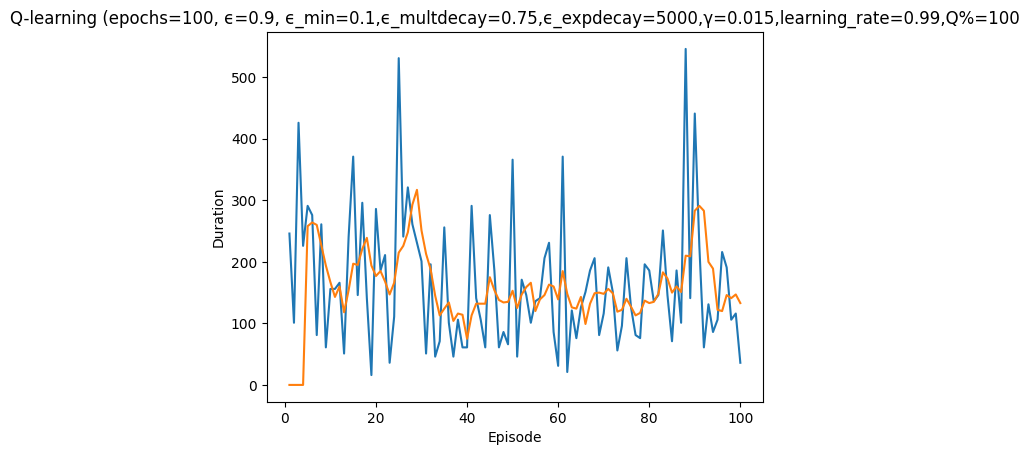

In [18]:
#ql
%matplotlib inline
random.seed(120394016)
def qlearning_run(gamma, gym_env):
    """Execute one run of the q-learning algorithm for the
    specified gamma value"""
    return learner.epsilon_greedy_search(
        gym_env,
        ep,
        a.QTabularLearner(ep, gamma=gamma, learning_rate=0.99, exploit_percentile=100),
        episode_count=training_episode_count,
        iteration_count=iteration_count,
        epsilon=0.90,
        render=False,
        epsilon_multdecay=0.75,  # 0.999,
        epsilon_exponential_decay=5000,
        epsilon_minimum=0.1,
        verbosity=Verbosity.Quiet,
        title="Q-learning"
    )

qlearning_results = [qlearning_run(gamma, cyberbattlechain_defender) for gamma in gamma_sweep]

qlearning_bestrun_10 = qlearning_results[0]

The average overall reward for this simulation is approximately 5672.09.

###### Exploiting DQL
Learning with: episode_count=100,iteration_count=90000,ϵ=0.0,ϵ_min=0.0, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5
  ## Episode: 1/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 1|Iteration 676|reward: 5909.0|last_reward_at:  676|Elapsed Time: 0:00:04||


  Episode 1 ended at t=676 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/5 (0.29)
    explore-remote: 5/22 (0.19)
    explore-connect: 0/7 (0.00)
    exploit-local: 13/200 (0.06)
    exploit-remote: 10/112 (0.08)
    exploit-connect: 7/293 (0.02)
  exploit deflected to exploration: 41
  ## Episode: 2/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 2|Iteration 191|reward: 5772.0|last_reward_at:  191|Elapsed Time: 0:00:01||


  Episode 2 ended at t=191 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/5 (0.38)
    explore-remote: 0/14 (0.00)
    explore-connect: 1/10 (0.09)
    exploit-local: 9/47 (0.16)
    exploit-remote: 10/17 (0.37)
    exploit-connect: 6/69 (0.08)
  exploit deflected to exploration: 33
  ## Episode: 3/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 3|Iteration 161|reward: 5628.0|last_reward_at:  161|Elapsed Time: 0:00:01||


  Episode 3 ended at t=161 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/5 (0.29)
    explore-remote: 3/8 (0.27)
    explore-connect: 0/14 (0.00)
    exploit-local: 7/47 (0.13)
    exploit-remote: 5/19 (0.21)
    exploit-connect: 6/45 (0.12)
  exploit deflected to exploration: 32
  ## Episode: 4/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 4|Iteration 246|reward: 5616.0|last_reward_at:  246|Elapsed Time: 0:00:01||


  Episode 4 ended at t=246 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/5 (0.17)
    explore-remote: 2/22 (0.08)
    explore-connect: 0/12 (0.00)
    exploit-local: 7/59 (0.11)
    exploit-remote: 4/43 (0.09)
    exploit-connect: 6/85 (0.07)
  exploit deflected to exploration: 42
  ## Episode: 5/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 5|Iteration 251|reward: 5612.0|last_reward_at:  251|Elapsed Time: 0:00:02||


  Episode 5 ended at t=251 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/16 (0.16)
    explore-remote: 1/33 (0.03)
    explore-connect: 0/20 (0.00)
    exploit-local: 4/51 (0.07)
    exploit-remote: 7/40 (0.15)
    exploit-connect: 6/70 (0.08)
  exploit deflected to exploration: 73
  ## Episode: 6/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 6|Iteration 431|reward: 5776.0|last_reward_at:  431|Elapsed Time: 0:00:02||


  Episode 6 ended at t=431 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/9 (0.18)
    explore-remote: 3/20 (0.13)
    explore-connect: 1/15 (0.06)
    exploit-local: 8/101 (0.07)
    exploit-remote: 10/82 (0.11)
    exploit-connect: 6/174 (0.03)
  exploit deflected to exploration: 50
  ## Episode: 7/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 7|Iteration 286|reward: 5762.0|last_reward_at:  286|Elapsed Time: 0:00:01||


  Episode 7 ended at t=286 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/3 (0.25)
    explore-remote: 1/9 (0.10)
    explore-connect: 1/8 (0.11)
    exploit-local: 9/75 (0.11)
    exploit-remote: 11/36 (0.23)
    exploit-connect: 5/127 (0.04)
  exploit deflected to exploration: 23
  ## Episode: 8/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 8|Iteration 351|reward: 5772.0|last_reward_at:  351|Elapsed Time: 0:00:02||


  Episode 8 ended at t=351 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/9 (0.25)
    explore-remote: 2/17 (0.11)
    explore-connect: 0/17 (0.00)
    exploit-local: 9/106 (0.08)
    exploit-remote: 10/52 (0.16)
    exploit-connect: 6/120 (0.05)
  exploit deflected to exploration: 48
  ## Episode: 9/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 9|Iteration 196|reward: 5374.0|last_reward_at:  196|Elapsed Time: 0:00:01||


  Episode 9 ended at t=196 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/6 (0.25)
    explore-remote: 2/16 (0.11)
    explore-connect: 1/17 (0.06)
    exploit-local: 2/38 (0.05)
    exploit-remote: 4/28 (0.12)
    exploit-connect: 3/77 (0.04)
  exploit deflected to exploration: 44
  ## Episode: 10/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 10|Iteration 121|reward: 5387.0|last_reward_at:  121|Elapsed Time: 0:00:01||


  Episode 10 ended at t=121 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/6 (0.14)
    explore-remote: 1/9 (0.10)
    explore-connect: 1/16 (0.06)
    exploit-local: 5/34 (0.13)
    exploit-remote: 5/16 (0.24)
    exploit-connect: 3/24 (0.11)
  exploit deflected to exploration: 34
  ## Episode: 11/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 11|Iteration 446|reward: 5647.0|last_reward_at:  446|Elapsed Time: 0:00:02||


  Episode 11 ended at t=446 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/4 (0.33)
    explore-remote: 3/16 (0.16)
    explore-connect: 1/10 (0.09)
    exploit-local: 9/134 (0.06)
    exploit-remote: 7/76 (0.08)
    exploit-connect: 4/180 (0.02)
  exploit deflected to exploration: 36
  ## Episode: 12/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 12|Iteration 206|reward: 5634.0|last_reward_at:  206|Elapsed Time: 0:00:01||


  Episode 12 ended at t=206 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/6 (0.33)
    explore-remote: 4/12 (0.25)
    explore-connect: 0/18 (0.00)
    exploit-local: 7/55 (0.11)
    exploit-remote: 5/28 (0.15)
    exploit-connect: 5/63 (0.07)
  exploit deflected to exploration: 43
  ## Episode: 13/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 13|Iteration 481|reward: 6013.0|last_reward_at:  481|Elapsed Time: 0:00:03||


  Episode 13 ended at t=481 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/3 (0.25)
    explore-remote: 4/26 (0.13)
    explore-connect: 1/14 (0.07)
    exploit-local: 13/131 (0.09)
    exploit-remote: 8/81 (0.09)
    exploit-connect: 8/191 (0.04)
  exploit deflected to exploration: 49
  ## Episode: 14/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 14|Iteration 366|reward: 5902.0|last_reward_at:  366|Elapsed Time: 0:00:02||


  Episode 14 ended at t=366 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/5 (0.00)
    explore-remote: 2/10 (0.17)
    explore-connect: 0/14 (0.00)
    exploit-local: 13/101 (0.11)
    exploit-remote: 11/48 (0.19)
    exploit-connect: 8/154 (0.05)
  exploit deflected to exploration: 31
  ## Episode: 15/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 15|Iteration 321|reward: 5773.0|last_reward_at:  321|Elapsed Time: 0:00:02||


  Episode 15 ended at t=321 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/6 (0.00)
    explore-remote: 0/17 (0.00)
    explore-connect: 0/17 (0.00)
    exploit-local: 12/101 (0.11)
    exploit-remote: 11/45 (0.20)
    exploit-connect: 6/106 (0.05)
  exploit deflected to exploration: 40
  ## Episode: 16/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 16|Iteration 281|reward: 5655.0|last_reward_at:  281|Elapsed Time: 0:00:02||


  Episode 16 ended at t=281 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/5 (0.17)
    explore-remote: 4/16 (0.20)
    explore-connect: 1/8 (0.11)
    exploit-local: 10/89 (0.10)
    exploit-remote: 7/37 (0.16)
    exploit-connect: 4/99 (0.04)
  exploit deflected to exploration: 35
  ## Episode: 17/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 17|Iteration 161|reward: 5618.0|last_reward_at:  161|Elapsed Time: 0:00:01||


  Episode 17 ended at t=161 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/5 (0.17)
    explore-remote: 1/19 (0.05)
    explore-connect: 0/10 (0.00)
    exploit-local: 7/29 (0.19)
    exploit-remote: 7/17 (0.29)
    exploit-connect: 6/59 (0.09)
  exploit deflected to exploration: 36
  ## Episode: 18/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 18|Iteration 351|reward: 5647.0|last_reward_at:  351|Elapsed Time: 0:00:02||


  Episode 18 ended at t=351 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/6 (0.25)
    explore-remote: 2/34 (0.06)
    explore-connect: 0/28 (0.00)
    exploit-local: 8/72 (0.10)
    exploit-remote: 8/64 (0.11)
    exploit-connect: 6/121 (0.05)
  exploit deflected to exploration: 72
  ## Episode: 19/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 19|Iteration 276|reward: 5756.0|last_reward_at:  276|Elapsed Time: 0:00:01||


  Episode 19 ended at t=276 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/3 (0.25)
    explore-remote: 4/7 (0.36)
    explore-connect: 0/10 (0.00)
    exploit-local: 9/70 (0.11)
    exploit-remote: 6/36 (0.14)
    exploit-connect: 7/123 (0.05)
  exploit deflected to exploration: 25
  ## Episode: 20/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 20|Iteration 426|reward: 5882.0|last_reward_at:  426|Elapsed Time: 0:00:03||


  Episode 20 ended at t=426 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/6 (0.40)
    explore-remote: 3/16 (0.16)
    explore-connect: 0/13 (0.00)
    exploit-local: 7/117 (0.06)
    exploit-remote: 11/82 (0.12)
    exploit-connect: 7/160 (0.04)
  exploit deflected to exploration: 42
  ## Episode: 21/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 21|Iteration 256|reward: 5527.0|last_reward_at:  256|Elapsed Time: 0:00:01||


  Episode 21 ended at t=256 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/5 (0.17)
    explore-remote: 2/10 (0.17)
    explore-connect: 0/10 (0.00)
    exploit-local: 7/73 (0.09)
    exploit-remote: 8/31 (0.21)
    exploit-connect: 5/104 (0.05)
  exploit deflected to exploration: 28
  ## Episode: 22/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 22|Iteration 291|reward: 5766.0|last_reward_at:  291|Elapsed Time: 0:00:02||


  Episode 22 ended at t=291 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/9 (0.25)
    explore-remote: 2/15 (0.12)
    explore-connect: 0/23 (0.00)
    exploit-local: 8/87 (0.08)
    exploit-remote: 9/50 (0.15)
    exploit-connect: 7/78 (0.08)
  exploit deflected to exploration: 52
  ## Episode: 23/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 23|Iteration 391|reward: 5872.0|last_reward_at:  391|Elapsed Time: 0:00:03||


  Episode 23 ended at t=391 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/8 (0.20)
    explore-remote: 2/22 (0.08)
    explore-connect: 1/10 (0.09)
    exploit-local: 10/109 (0.08)
    exploit-remote: 9/59 (0.13)
    exploit-connect: 7/152 (0.04)
  exploit deflected to exploration: 45
  ## Episode: 24/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 24|Iteration 301|reward: 5897.0|last_reward_at:  301|Elapsed Time: 0:00:02||


  Episode 24 ended at t=301 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/6 (0.14)
    explore-remote: 1/13 (0.07)
    explore-connect: 0/16 (0.00)
    exploit-local: 14/69 (0.17)
    exploit-remote: 11/44 (0.20)
    exploit-connect: 7/119 (0.06)
  exploit deflected to exploration: 37
  ## Episode: 25/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 25|Iteration 466|reward: 5895.0|last_reward_at:  466|Elapsed Time: 0:00:03||


  Episode 25 ended at t=466 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/8 (0.11)
    explore-remote: 2/28 (0.07)
    explore-connect: 0/23 (0.00)
    exploit-local: 13/126 (0.09)
    exploit-remote: 10/63 (0.14)
    exploit-connect: 7/185 (0.04)
  exploit deflected to exploration: 62
  ## Episode: 26/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 26|Iteration 486|reward: 5762.0|last_reward_at:  486|Elapsed Time: 0:00:03||


  Episode 26 ended at t=486 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/11 (0.08)
    explore-remote: 2/24 (0.08)
    explore-connect: 0/31 (0.00)
    exploit-local: 10/128 (0.07)
    exploit-remote: 8/78 (0.09)
    exploit-connect: 7/186 (0.04)
  exploit deflected to exploration: 69
  ## Episode: 27/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 27|Iteration 336|reward: 5769.0|last_reward_at:  336|Elapsed Time: 0:00:02||


  Episode 27 ended at t=336 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/5 (0.17)
    explore-remote: 1/15 (0.06)
    explore-connect: 0/17 (0.00)
    exploit-local: 11/76 (0.13)
    exploit-remote: 9/68 (0.12)
    exploit-connect: 7/126 (0.05)
  exploit deflected to exploration: 39
  ## Episode: 28/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 28|Iteration 256|reward: 5754.0|last_reward_at:  256|Elapsed Time: 0:00:02||


  Episode 28 ended at t=256 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/3 (0.25)
    explore-remote: 4/16 (0.20)
    explore-connect: 0/22 (0.00)
    exploit-local: 9/60 (0.13)
    exploit-remote: 6/39 (0.13)
    exploit-connect: 7/89 (0.07)
  exploit deflected to exploration: 46
  ## Episode: 29/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 29|Iteration 411|reward: 5766.0|last_reward_at:  411|Elapsed Time: 0:00:03||


  Episode 29 ended at t=411 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/9 (0.10)
    explore-remote: 4/22 (0.15)
    explore-connect: 1/21 (0.05)
    exploit-local: 10/114 (0.08)
    exploit-remote: 8/64 (0.11)
    exploit-connect: 6/151 (0.04)
  exploit deflected to exploration: 58
  ## Episode: 30/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 30|Iteration 351|reward: 5876.0|last_reward_at:  351|Elapsed Time: 0:00:02||


  Episode 30 ended at t=351 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/5 (0.00)
    explore-remote: 2/15 (0.12)
    explore-connect: 0/7 (0.00)
    exploit-local: 12/105 (0.10)
    exploit-remote: 11/48 (0.19)
    exploit-connect: 8/138 (0.05)
  exploit deflected to exploration: 29
  ## Episode: 31/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 31|Iteration 181|reward: 5647.0|last_reward_at:  181|Elapsed Time: 0:00:01||


  Episode 31 ended at t=181 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/3 (0.25)
    explore-remote: 0/16 (0.00)
    explore-connect: 1/13 (0.07)
    exploit-local: 9/45 (0.17)
    exploit-remote: 10/24 (0.29)
    exploit-connect: 5/54 (0.08)
  exploit deflected to exploration: 34
  ## Episode: 32/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 32|Iteration 176|reward: 5496.0|last_reward_at:  176|Elapsed Time: 0:00:01||


  Episode 32 ended at t=176 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/2 (0.33)
    explore-remote: 3/13 (0.19)
    explore-connect: 0/12 (0.00)
    exploit-local: 5/44 (0.10)
    exploit-remote: 4/25 (0.14)
    exploit-connect: 5/62 (0.07)
  exploit deflected to exploration: 31
  ## Episode: 33/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 33|Iteration 156|reward: 5860.0|last_reward_at:  156|Elapsed Time: 0:00:01||


  Episode 33 ended at t=156 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/0 (1.00)
    explore-remote: 1/10 (0.09)
    explore-connect: 0/7 (0.00)
    exploit-local: 9/35 (0.20)
    exploit-remote: 10/14 (0.42)
    exploit-connect: 7/61 (0.10)
  exploit deflected to exploration: 20
  ## Episode: 34/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 34|Iteration 481|reward: 6126.0|last_reward_at:  481|Elapsed Time: 0:00:03||


  Episode 34 ended at t=481 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/6 (0.14)
    explore-remote: 4/14 (0.22)
    explore-connect: 0/17 (0.00)
    exploit-local: 14/135 (0.09)
    exploit-remote: 10/75 (0.12)
    exploit-connect: 10/195 (0.05)
  exploit deflected to exploration: 42
  ## Episode: 35/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 35|Iteration 451|reward: 5777.0|last_reward_at:  451|Elapsed Time: 0:00:03||


  Episode 35 ended at t=451 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/3 (0.57)
    explore-remote: 0/10 (0.00)
    explore-connect: 0/14 (0.00)
    exploit-local: 8/145 (0.05)
    exploit-remote: 13/59 (0.18)
    exploit-connect: 7/188 (0.04)
  exploit deflected to exploration: 31
  ## Episode: 36/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 36|Iteration 266|reward: 5852.0|last_reward_at:  266|Elapsed Time: 0:00:01||


  Episode 36 ended at t=266 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/2 (0.50)
    explore-remote: 2/8 (0.20)
    explore-connect: 0/12 (0.00)
    exploit-local: 9/51 (0.15)
    exploit-remote: 7/42 (0.14)
    exploit-connect: 7/124 (0.05)
  exploit deflected to exploration: 26
  ## Episode: 37/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 37|Iteration 246|reward: 5639.0|last_reward_at:  246|Elapsed Time: 0:00:02||


  Episode 37 ended at t=246 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/12 (0.25)
    explore-remote: 3/20 (0.13)
    explore-connect: 0/26 (0.00)
    exploit-local: 6/78 (0.07)
    exploit-remote: 5/27 (0.16)
    exploit-connect: 6/59 (0.09)
  exploit deflected to exploration: 65
  ## Episode: 38/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 38|Iteration 286|reward: 5525.0|last_reward_at:  286|Elapsed Time: 0:00:02||


  Episode 38 ended at t=286 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/11 (0.21)
    explore-remote: 1/22 (0.04)
    explore-connect: 0/14 (0.00)
    exploit-local: 6/78 (0.07)
    exploit-remote: 8/53 (0.13)
    exploit-connect: 4/86 (0.04)
  exploit deflected to exploration: 51
  ## Episode: 39/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 39|Iteration 266|reward: 5521.0|last_reward_at:  266|Elapsed Time: 0:00:02||


  Episode 39 ended at t=266 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/12 (0.08)
    explore-remote: 2/29 (0.06)
    explore-connect: 0/16 (0.00)
    exploit-local: 6/56 (0.10)
    exploit-remote: 7/42 (0.14)
    exploit-connect: 5/90 (0.05)
  exploit deflected to exploration: 60
  ## Episode: 40/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 40|Iteration 246|reward: 5768.0|last_reward_at:  246|Elapsed Time: 0:00:01||


  Episode 40 ended at t=246 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/5 (0.17)
    explore-remote: 1/18 (0.05)
    explore-connect: 0/12 (0.00)
    exploit-local: 12/62 (0.16)
    exploit-remote: 8/33 (0.20)
    exploit-connect: 6/88 (0.06)
  exploit deflected to exploration: 37
  ## Episode: 41/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 41|Iteration 276|reward: 5637.0|last_reward_at:  276|Elapsed Time: 0:00:01||


  Episode 41 ended at t=276 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/1 (0.50)
    explore-remote: 0/3 (0.00)
    explore-connect: 0/1 (0.00)
    exploit-local: 9/72 (0.11)
    exploit-remote: 10/45 (0.18)
    exploit-connect: 5/129 (0.04)
  exploit deflected to exploration: 6
  ## Episode: 42/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 42|Iteration 486|reward: 5906.0|last_reward_at:  486|Elapsed Time: 0:00:04||


  Episode 42 ended at t=486 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/4 (0.20)
    explore-remote: 4/18 (0.18)
    explore-connect: 0/18 (0.00)
    exploit-local: 12/119 (0.09)
    exploit-remote: 12/77 (0.13)
    exploit-connect: 7/214 (0.03)
  exploit deflected to exploration: 45
  ## Episode: 43/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 43|Iteration 591|reward: 5920.0|last_reward_at:  591|Elapsed Time: 0:00:04||


  Episode 43 ended at t=591 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/12 (0.14)
    explore-remote: 4/15 (0.21)
    explore-connect: 0/35 (0.00)
    exploit-local: 14/174 (0.07)
    exploit-remote: 10/91 (0.10)
    exploit-connect: 7/227 (0.03)
  exploit deflected to exploration: 68
  ## Episode: 44/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 44|Iteration 571|reward: 5663.0|last_reward_at:  571|Elapsed Time: 0:00:04||


  Episode 44 ended at t=571 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/9 (0.10)
    explore-remote: 3/17 (0.15)
    explore-connect: 0/16 (0.00)
    exploit-local: 9/189 (0.05)
    exploit-remote: 10/102 (0.09)
    exploit-connect: 5/210 (0.02)
  exploit deflected to exploration: 46
  ## Episode: 45/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 45|Iteration 206|reward: 5638.0|last_reward_at:  206|Elapsed Time: 0:00:01||


  Episode 45 ended at t=206 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/3 (0.25)
    explore-remote: 0/7 (0.00)
    explore-connect: 0/9 (0.00)
    exploit-local: 7/60 (0.10)
    exploit-remote: 11/28 (0.28)
    exploit-connect: 5/75 (0.06)
  exploit deflected to exploration: 20
  ## Episode: 46/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 46|Iteration 306|reward: 5870.0|last_reward_at:  306|Elapsed Time: 0:00:02||


  Episode 46 ended at t=306 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/8 (0.20)
    explore-remote: 2/16 (0.11)
    explore-connect: 0/17 (0.00)
    exploit-local: 9/82 (0.10)
    exploit-remote: 10/40 (0.20)
    exploit-connect: 7/113 (0.06)
  exploit deflected to exploration: 45
  ## Episode: 47/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 47|Iteration 436|reward: 5532.0|last_reward_at:  436|Elapsed Time: 0:00:03||


  Episode 47 ended at t=436 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/13 (0.07)
    explore-remote: 1/37 (0.03)
    explore-connect: 0/22 (0.00)
    exploit-local: 7/118 (0.06)
    exploit-remote: 9/68 (0.12)
    exploit-connect: 5/155 (0.03)
  exploit deflected to exploration: 74
  ## Episode: 48/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 48|Iteration 211|reward: 5765.0|last_reward_at:  211|Elapsed Time: 0:00:01||


  Episode 48 ended at t=211 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/6 (0.25)
    explore-remote: 2/25 (0.07)
    explore-connect: 0/10 (0.00)
    exploit-local: 9/50 (0.15)
    exploit-remote: 8/22 (0.27)
    exploit-connect: 7/70 (0.09)
  exploit deflected to exploration: 45
  ## Episode: 49/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 49|Iteration 281|reward: 5504.0|last_reward_at:  281|Elapsed Time: 0:00:02||


  Episode 49 ended at t=281 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/6 (0.14)
    explore-remote: 1/15 (0.06)
    explore-connect: 1/12 (0.08)
    exploit-local: 6/85 (0.07)
    exploit-remote: 6/47 (0.11)
    exploit-connect: 4/97 (0.04)
  exploit deflected to exploration: 36
  ## Episode: 50/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 50|Iteration 266|reward: 5879.0|last_reward_at:  266|Elapsed Time: 0:00:02||


  Episode 50 ended at t=266 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/8 (0.11)
    explore-remote: 2/14 (0.12)
    explore-connect: 0/12 (0.00)
    exploit-local: 12/69 (0.15)
    exploit-remote: 10/35 (0.22)
    exploit-connect: 7/96 (0.07)
  exploit deflected to exploration: 37
  ## Episode: 51/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 51|Iteration 261|reward: 5766.0|last_reward_at:  261|Elapsed Time: 0:00:02||


  Episode 51 ended at t=261 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/9 (0.18)
    explore-remote: 1/8 (0.11)
    explore-connect: 0/12 (0.00)
    exploit-local: 9/80 (0.10)
    exploit-remote: 10/30 (0.25)
    exploit-connect: 7/93 (0.07)
  exploit deflected to exploration: 32
  ## Episode: 52/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 52|Iteration 231|reward: 5632.0|last_reward_at:  231|Elapsed Time: 0:00:01||


  Episode 52 ended at t=231 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/4 (0.20)
    explore-remote: 2/18 (0.10)
    explore-connect: 0/11 (0.00)
    exploit-local: 8/41 (0.16)
    exploit-remote: 6/47 (0.11)
    exploit-connect: 6/87 (0.06)
  exploit deflected to exploration: 36
  ## Episode: 53/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 53|Iteration 166|reward: 5524.0|last_reward_at:  166|Elapsed Time: 0:00:01||


  Episode 53 ended at t=166 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/4 (0.33)
    explore-remote: 1/16 (0.06)
    explore-connect: 0/12 (0.00)
    exploit-local: 7/38 (0.16)
    exploit-remote: 7/27 (0.21)
    exploit-connect: 4/48 (0.08)
  exploit deflected to exploration: 35
  ## Episode: 54/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 54|Iteration 586|reward: 5759.0|last_reward_at:  586|Elapsed Time: 0:00:03||


  Episode 54 ended at t=586 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/8 (0.11)
    explore-remote: 2/20 (0.09)
    explore-connect: 0/21 (0.00)
    exploit-local: 10/161 (0.06)
    exploit-remote: 8/109 (0.07)
    exploit-connect: 7/239 (0.03)
  exploit deflected to exploration: 52
  ## Episode: 55/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 55|Iteration 581|reward: 5771.0|last_reward_at:  581|Elapsed Time: 0:00:03||


  Episode 55 ended at t=581 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/7 (0.12)
    explore-remote: 2/15 (0.12)
    explore-connect: 0/19 (0.00)
    exploit-local: 12/208 (0.05)
    exploit-remote: 8/80 (0.09)
    exploit-connect: 6/223 (0.03)
  exploit deflected to exploration: 44
  ## Episode: 56/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 56|Iteration 281|reward: 5766.0|last_reward_at:  281|Elapsed Time: 0:00:02||


  Episode 56 ended at t=281 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/7 (0.22)
    explore-remote: 3/19 (0.14)
    explore-connect: 0/20 (0.00)
    exploit-local: 10/81 (0.11)
    exploit-remote: 9/33 (0.21)
    exploit-connect: 6/91 (0.06)
  exploit deflected to exploration: 51
  ## Episode: 57/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 57|Iteration 591|reward: 5911.0|last_reward_at:  591|Elapsed Time: 0:00:04||


  Episode 57 ended at t=591 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/8 (0.11)
    explore-remote: 0/20 (0.00)
    explore-connect: 1/23 (0.04)
    exploit-local: 13/163 (0.07)
    exploit-remote: 14/94 (0.13)
    exploit-connect: 7/247 (0.03)
  exploit deflected to exploration: 53
  ## Episode: 58/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 58|Iteration 486|reward: 6004.0|last_reward_at:  486|Elapsed Time: 0:00:03||


  Episode 58 ended at t=486 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/11 (0.00)
    explore-remote: 2/12 (0.14)
    explore-connect: 1/19 (0.05)
    exploit-local: 15/145 (0.09)
    exploit-remote: 10/64 (0.14)
    exploit-connect: 7/200 (0.03)
  exploit deflected to exploration: 45
  ## Episode: 59/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 59|Iteration 241|reward: 5746.0|last_reward_at:  241|Elapsed Time: 0:00:01||


  Episode 59 ended at t=241 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/4 (0.20)
    explore-remote: 2/12 (0.14)
    explore-connect: 0/19 (0.00)
    exploit-local: 10/51 (0.16)
    exploit-remote: 6/33 (0.15)
    exploit-connect: 7/96 (0.07)
  exploit deflected to exploration: 38
  ## Episode: 60/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 60|Iteration 271|reward: 5660.0|last_reward_at:  271|Elapsed Time: 0:00:02||


  Episode 60 ended at t=271 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/6 (0.25)
    explore-remote: 1/24 (0.04)
    explore-connect: 0/16 (0.00)
    exploit-local: 8/70 (0.10)
    exploit-remote: 10/39 (0.20)
    exploit-connect: 6/89 (0.06)
  exploit deflected to exploration: 49
  ## Episode: 61/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 61|Iteration 126|reward: 5506.0|last_reward_at:  126|Elapsed Time: 0:00:00||


  Episode 61 ended at t=126 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/1 (0.67)
    explore-remote: 0/3 (0.00)
    explore-connect: 0/10 (0.00)
    exploit-local: 6/25 (0.19)
    exploit-remote: 6/20 (0.23)
    exploit-connect: 4/49 (0.08)
  exploit deflected to exploration: 16
  ## Episode: 62/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 62|Iteration 196|reward: 5401.0|last_reward_at:  196|Elapsed Time: 0:00:01||


  Episode 62 ended at t=196 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/5 (0.17)
    explore-remote: 2/17 (0.11)
    explore-connect: 0/12 (0.00)
    exploit-local: 5/35 (0.12)
    exploit-remote: 6/34 (0.15)
    exploit-connect: 3/76 (0.04)
  exploit deflected to exploration: 37
  ## Episode: 63/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 63|Iteration 201|reward: 5878.0|last_reward_at:  201|Elapsed Time: 0:00:01||


  Episode 63 ended at t=201 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/5 (0.17)
    explore-remote: 3/6 (0.33)
    explore-connect: 0/14 (0.00)
    exploit-local: 11/46 (0.19)
    exploit-remote: 9/28 (0.24)
    exploit-connect: 8/70 (0.10)
  exploit deflected to exploration: 29
  ## Episode: 64/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 64|Iteration 266|reward: 5878.0|last_reward_at:  266|Elapsed Time: 0:00:01||


  Episode 64 ended at t=266 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/4 (0.00)
    explore-remote: 1/5 (0.17)
    explore-connect: 0/8 (0.00)
    exploit-local: 13/71 (0.15)
    exploit-remote: 9/33 (0.21)
    exploit-connect: 8/114 (0.07)
  exploit deflected to exploration: 18
  ## Episode: 65/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 65|Iteration 376|reward: 5661.0|last_reward_at:  376|Elapsed Time: 0:00:02||


  Episode 65 ended at t=376 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/9 (0.31)
    explore-remote: 3/24 (0.11)
    explore-connect: 0/22 (0.00)
    exploit-local: 7/99 (0.07)
    exploit-remote: 9/60 (0.13)
    exploit-connect: 5/134 (0.04)
  exploit deflected to exploration: 62
  ## Episode: 66/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 66|Iteration 216|reward: 5614.0|last_reward_at:  216|Elapsed Time: 0:00:01||


  Episode 66 ended at t=216 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/3 (0.57)
    explore-remote: 0/13 (0.00)
    explore-connect: 0/7 (0.00)
    exploit-local: 3/63 (0.05)
    exploit-remote: 9/29 (0.24)
    exploit-connect: 6/79 (0.07)
  exploit deflected to exploration: 27
  ## Episode: 67/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 67|Iteration 596|reward: 5894.0|last_reward_at:  596|Elapsed Time: 0:00:04||


  Episode 67 ended at t=596 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/8 (0.00)
    explore-remote: 0/31 (0.00)
    explore-connect: 0/22 (0.00)
    exploit-local: 13/176 (0.07)
    exploit-remote: 12/92 (0.12)
    exploit-connect: 8/234 (0.03)
  exploit deflected to exploration: 61
  ## Episode: 68/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 68|Iteration 396|reward: 5899.0|last_reward_at:  396|Elapsed Time: 0:00:02||


  Episode 68 ended at t=396 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/5 (0.29)
    explore-remote: 1/23 (0.04)
    explore-connect: 0/18 (0.00)
    exploit-local: 12/117 (0.09)
    exploit-remote: 11/57 (0.16)
    exploit-connect: 8/142 (0.05)
  exploit deflected to exploration: 49
  ## Episode: 69/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 69|Iteration 171|reward: 5650.0|last_reward_at:  171|Elapsed Time: 0:00:01||


  Episode 69 ended at t=171 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/3 (0.25)
    explore-remote: 1/9 (0.10)
    explore-connect: 0/11 (0.00)
    exploit-local: 8/49 (0.14)
    exploit-remote: 10/17 (0.37)
    exploit-connect: 5/57 (0.08)
  exploit deflected to exploration: 25
  ## Episode: 70/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 70|Iteration 426|reward: 5657.0|last_reward_at:  426|Elapsed Time: 0:00:03||


  Episode 70 ended at t=426 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/5 (0.17)
    explore-remote: 4/11 (0.27)
    explore-connect: 0/26 (0.00)
    exploit-local: 10/131 (0.07)
    exploit-remote: 7/74 (0.09)
    exploit-connect: 5/152 (0.03)
  exploit deflected to exploration: 47
  ## Episode: 71/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 71|Iteration 166|reward: 5492.0|last_reward_at:  166|Elapsed Time: 0:00:01||


  Episode 71 ended at t=166 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/8 (0.11)
    explore-remote: 2/10 (0.17)
    explore-connect: 0/15 (0.00)
    exploit-local: 7/35 (0.17)
    exploit-remote: 3/20 (0.13)
    exploit-connect: 4/61 (0.06)
  exploit deflected to exploration: 36
  ## Episode: 72/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 72|Iteration 371|reward: 5882.0|last_reward_at:  371|Elapsed Time: 0:00:02||


  Episode 72 ended at t=371 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/5 (0.38)
    explore-remote: 2/15 (0.12)
    explore-connect: 0/10 (0.00)
    exploit-local: 10/105 (0.09)
    exploit-remote: 10/53 (0.16)
    exploit-connect: 7/151 (0.04)
  exploit deflected to exploration: 35
  ## Episode: 73/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 73|Iteration 646|reward: 6028.0|last_reward_at:  646|Elapsed Time: 0:00:04||


  Episode 73 ended at t=646 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/7 (0.12)
    explore-remote: 1/32 (0.03)
    explore-connect: 0/32 (0.00)
    exploit-local: 14/165 (0.08)
    exploit-remote: 15/95 (0.14)
    exploit-connect: 8/276 (0.03)
  exploit deflected to exploration: 73
  ## Episode: 74/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 74|Iteration 266|reward: 5882.0|last_reward_at:  266|Elapsed Time: 0:00:02||


  Episode 74 ended at t=266 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/6 (0.14)
    explore-remote: 2/7 (0.22)
    explore-connect: 0/14 (0.00)
    exploit-local: 11/72 (0.13)
    exploit-remote: 12/39 (0.24)
    exploit-connect: 7/95 (0.07)
  exploit deflected to exploration: 30
  ## Episode: 75/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 75|Iteration 301|reward: 5878.0|last_reward_at:  301|Elapsed Time: 0:00:02||


  Episode 75 ended at t=301 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/7 (0.22)
    explore-remote: 1/16 (0.06)
    explore-connect: 1/11 (0.08)
    exploit-local: 10/80 (0.11)
    exploit-remote: 9/51 (0.15)
    exploit-connect: 7/106 (0.06)
  exploit deflected to exploration: 38
  ## Episode: 76/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 76|Iteration 206|reward: 5641.0|last_reward_at:  206|Elapsed Time: 0:00:01||


  Episode 76 ended at t=206 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/5 (0.29)
    explore-remote: 5/9 (0.36)
    explore-connect: 0/6 (0.00)
    exploit-local: 8/52 (0.13)
    exploit-remote: 4/31 (0.11)
    exploit-connect: 5/79 (0.06)
  exploit deflected to exploration: 27
  ## Episode: 77/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 77|Iteration 656|reward: 6184.0|last_reward_at:  656|Elapsed Time: 0:00:04||


  Episode 77 ended at t=656 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/4 (0.20)
    explore-remote: 3/18 (0.14)
    explore-connect: 0/13 (0.00)
    exploit-local: 18/219 (0.08)
    exploit-remote: 16/104 (0.13)
    exploit-connect: 10/250 (0.04)
  exploit deflected to exploration: 39
  ## Episode: 78/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 78|Iteration 466|reward: 5636.0|last_reward_at:  466|Elapsed Time: 0:00:03||


  Episode 78 ended at t=466 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/11 (0.27)
    explore-remote: 3/33 (0.08)
    explore-connect: 0/40 (0.00)
    exploit-local: 6/127 (0.05)
    exploit-remote: 7/74 (0.09)
    exploit-connect: 5/156 (0.03)
  exploit deflected to exploration: 91
  ## Episode: 79/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 79|Iteration 186|reward: 5378.0|last_reward_at:  186|Elapsed Time: 0:00:01||


  Episode 79 ended at t=186 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/4 (0.33)
    explore-remote: 2/7 (0.22)
    explore-connect: 1/18 (0.05)
    exploit-local: 3/50 (0.06)
    exploit-remote: 4/25 (0.14)
    exploit-connect: 3/67 (0.04)
  exploit deflected to exploration: 34
  ## Episode: 80/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 80|Iteration 306|reward: 5636.0|last_reward_at:  306|Elapsed Time: 0:00:02||


  Episode 80 ended at t=306 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/2 (0.33)
    explore-remote: 0/19 (0.00)
    explore-connect: 0/20 (0.00)
    exploit-local: 8/92 (0.08)
    exploit-remote: 9/40 (0.18)
    exploit-connect: 6/109 (0.05)
  exploit deflected to exploration: 42
  ## Episode: 81/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 81|Iteration 411|reward: 5924.0|last_reward_at:  411|Elapsed Time: 0:00:02||


  Episode 81 ended at t=411 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/2 (0.60)
    explore-remote: 3/17 (0.15)
    explore-connect: 0/13 (0.00)
    exploit-local: 12/94 (0.11)
    exploit-remote: 12/59 (0.17)
    exploit-connect: 8/188 (0.04)
  exploit deflected to exploration: 38
  ## Episode: 82/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 82|Iteration 291|reward: 5750.0|last_reward_at:  291|Elapsed Time: 0:00:02||


  Episode 82 ended at t=291 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/2 (0.33)
    explore-remote: 2/5 (0.29)
    explore-connect: 0/9 (0.00)
    exploit-local: 8/99 (0.07)
    exploit-remote: 9/48 (0.16)
    exploit-connect: 7/101 (0.06)
  exploit deflected to exploration: 19
  ## Episode: 83/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 83|Iteration 101|reward: 5525.0|last_reward_at:  101|Elapsed Time: 0:00:01||


  Episode 83 ended at t=101 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/4 (0.33)
    explore-remote: 2/12 (0.14)
    explore-connect: 0/10 (0.00)
    exploit-local: 7/18 (0.28)
    exploit-remote: 6/17 (0.26)
    exploit-connect: 4/19 (0.17)
  exploit deflected to exploration: 30
  ## Episode: 84/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 84|Iteration 91|reward: 5616.0|last_reward_at:   91|Elapsed Time: 0:00:00||


  Episode 84 ended at t=91 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/1 (0.50)
    explore-remote: 3/5 (0.38)
    explore-connect: 0/5 (0.00)
    exploit-local: 6/23 (0.21)
    exploit-remote: 5/10 (0.33)
    exploit-connect: 6/26 (0.19)
  exploit deflected to exploration: 15
  ## Episode: 85/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 85|Iteration 361|reward: 5639.0|last_reward_at:  361|Elapsed Time: 0:00:02||


  Episode 85 ended at t=361 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/5 (0.29)
    explore-remote: 0/30 (0.00)
    explore-connect: 0/18 (0.00)
    exploit-local: 8/93 (0.08)
    exploit-remote: 9/52 (0.15)
    exploit-connect: 5/139 (0.03)
  exploit deflected to exploration: 55
  ## Episode: 86/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 86|Iteration 281|reward: 5872.0|last_reward_at:  281|Elapsed Time: 0:00:01||


  Episode 86 ended at t=281 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/6 (0.00)
    explore-remote: 2/9 (0.18)
    explore-connect: 0/9 (0.00)
    exploit-local: 12/89 (0.12)
    exploit-remote: 10/38 (0.21)
    exploit-connect: 7/99 (0.07)
  exploit deflected to exploration: 26
  ## Episode: 87/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 87|Iteration 81|reward: 5390.0|last_reward_at:   81|Elapsed Time: 0:00:00||


  Episode 87 ended at t=81 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/1 (0.50)
    explore-remote: 2/9 (0.18)
    explore-connect: 1/8 (0.11)
    exploit-local: 6/6 (0.50)
    exploit-remote: 1/11 (0.08)
    exploit-connect: 3/32 (0.09)
  exploit deflected to exploration: 22
  ## Episode: 88/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 88|Iteration 216|reward: 5632.0|last_reward_at:  216|Elapsed Time: 0:00:01||


  Episode 88 ended at t=216 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/3 (0.40)
    explore-remote: 3/14 (0.18)
    explore-connect: 0/8 (0.00)
    exploit-local: 7/63 (0.10)
    exploit-remote: 6/43 (0.12)
    exploit-connect: 5/62 (0.07)
  exploit deflected to exploration: 30
  ## Episode: 89/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 89|Iteration 206|reward: 5519.0|last_reward_at:  206|Elapsed Time: 0:00:01||


  Episode 89 ended at t=206 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/13 (0.13)
    explore-remote: 4/17 (0.19)
    explore-connect: 0/13 (0.00)
    exploit-local: 6/60 (0.09)
    exploit-remote: 4/27 (0.13)
    exploit-connect: 5/55 (0.08)
  exploit deflected to exploration: 49
  ## Episode: 90/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 90|Iteration 266|reward: 5634.0|last_reward_at:  266|Elapsed Time: 0:00:01||


  Episode 90 ended at t=266 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/3 (0.00)
    explore-remote: 2/5 (0.29)
    explore-connect: 0/3 (0.00)
    exploit-local: 10/89 (0.10)
    exploit-remote: 8/39 (0.17)
    exploit-connect: 5/102 (0.05)
  exploit deflected to exploration: 13
  ## Episode: 91/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 91|Iteration 291|reward: 5756.0|last_reward_at:  291|Elapsed Time: 0:00:02||


  Episode 91 ended at t=291 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/3 (0.25)
    explore-remote: 1/23 (0.04)
    explore-connect: 0/14 (0.00)
    exploit-local: 9/68 (0.12)
    exploit-remote: 9/48 (0.16)
    exploit-connect: 7/108 (0.06)
  exploit deflected to exploration: 42
  ## Episode: 92/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 92|Iteration 591|reward: 5655.0|last_reward_at:  591|Elapsed Time: 0:00:03||


  Episode 92 ended at t=591 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/7 (0.30)
    explore-remote: 1/40 (0.02)
    explore-connect: 0/14 (0.00)
    exploit-local: 7/151 (0.04)
    exploit-remote: 11/96 (0.10)
    exploit-connect: 5/256 (0.02)
  exploit deflected to exploration: 65
  ## Episode: 93/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 93|Iteration 511|reward: 5762.0|last_reward_at:  511|Elapsed Time: 0:00:04||


  Episode 93 ended at t=511 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/9 (0.25)
    explore-remote: 2/17 (0.11)
    explore-connect: 0/18 (0.00)
    exploit-local: 9/164 (0.05)
    exploit-remote: 9/98 (0.08)
    exploit-connect: 6/176 (0.03)
  exploit deflected to exploration: 49
  ## Episode: 94/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 94|Iteration 286|reward: 5770.0|last_reward_at:  286|Elapsed Time: 0:00:02||


  Episode 94 ended at t=286 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/8 (0.11)
    explore-remote: 2/3 (0.40)
    explore-connect: 2/5 (0.29)
    exploit-local: 11/92 (0.11)
    exploit-remote: 10/58 (0.15)
    exploit-connect: 4/90 (0.04)
  exploit deflected to exploration: 21
  ## Episode: 95/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 95|Iteration 251|reward: 5892.0|last_reward_at:  251|Elapsed Time: 0:00:02||


  Episode 95 ended at t=251 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/7 (0.30)
    explore-remote: 1/13 (0.07)
    explore-connect: 0/17 (0.00)
    exploit-local: 9/77 (0.10)
    exploit-remote: 13/26 (0.33)
    exploit-connect: 8/77 (0.09)
  exploit deflected to exploration: 41
  ## Episode: 96/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 96|Iteration 536|reward: 6030.0|last_reward_at:  536|Elapsed Time: 0:00:03||


  Episode 96 ended at t=536 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/3 (0.00)
    explore-remote: 1/9 (0.10)
    explore-connect: 0/11 (0.00)
    exploit-local: 17/156 (0.10)
    exploit-remote: 12/91 (0.12)
    exploit-connect: 8/228 (0.03)
  exploit deflected to exploration: 24
  ## Episode: 97/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 97|Iteration 246|reward: 5519.0|last_reward_at:  246|Elapsed Time: 0:00:01||


  Episode 97 ended at t=246 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/3 (0.25)
    explore-remote: 3/15 (0.17)
    explore-connect: 0/20 (0.00)
    exploit-local: 6/57 (0.10)
    exploit-remote: 6/46 (0.12)
    exploit-connect: 5/84 (0.06)
  exploit deflected to exploration: 42
  ## Episode: 98/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 98|Iteration 226|reward: 5752.0|last_reward_at:  226|Elapsed Time: 0:00:01||


  Episode 98 ended at t=226 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/3 (0.25)
    explore-remote: 2/7 (0.22)
    explore-connect: 0/16 (0.00)
    exploit-local: 10/57 (0.15)
    exploit-remote: 8/35 (0.19)
    exploit-connect: 7/80 (0.08)
  exploit deflected to exploration: 29
  ## Episode: 99/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 99|Iteration 476|reward: 6006.0|last_reward_at:  476|Elapsed Time: 0:00:03||


  Episode 99 ended at t=476 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/6 (0.14)
    explore-remote: 1/6 (0.14)
    explore-connect: 0/6 (0.00)
    exploit-local: 13/151 (0.08)
    exploit-remote: 13/73 (0.15)
    exploit-connect: 9/197 (0.04)
  exploit deflected to exploration: 20
  ## Episode: 100/100 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.99, replaymemory=10000,
batch=256, target_update=5


Episode 100|Iteration 606|reward: 5786.0|last_reward_at:  606|Elapsed Time: 0:00:04||


  Episode 100 ended at t=606 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/14 (0.12)
    explore-remote: 1/22 (0.04)
    explore-connect: 0/18 (0.00)
    exploit-local: 10/163 (0.06)
    exploit-remote: 13/104 (0.11)
    exploit-connect: 7/252 (0.03)
  exploit deflected to exploration: 57
simulation ended


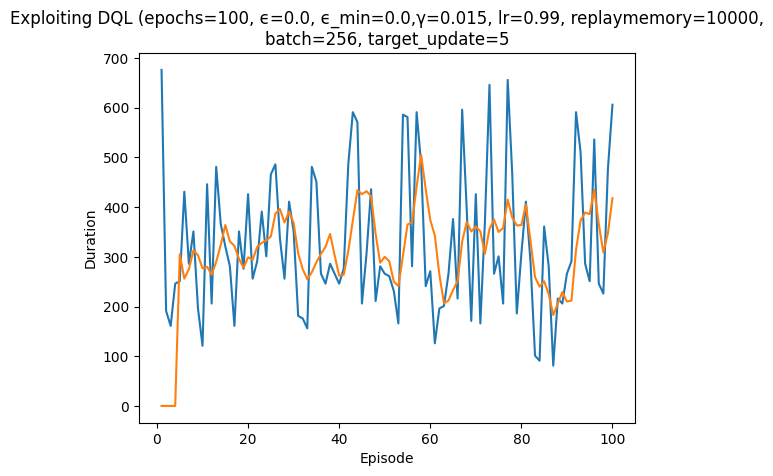

In [19]:
random.seed(120394016)
%matplotlib inline
dql_exploit_run = learner.epsilon_greedy_search(
    cyberbattlechain_defender,
    ep,
    learner=dqn_with_defender['learner'],
    episode_count=training_episode_count,
    iteration_count=iteration_count,
    epsilon=0.0,
    render=False,
    # render_last_episode_rewards_to='images/chain10',
    verbosity=Verbosity.Quiet,
    title="Exploiting DQL"
)

The average overall reward for this simulation is approximately 5731.87.

###### Exploiting Q-matrix
Learning with: episode_count=100,iteration_count=90000,ϵ=0,ϵ_min=0.0, γ=0.0,learning_rate=0.0,Q%=100
  ## Episode: 1/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 1|Iteration 4481|reward: 5511.0|last_reward_at: 4481|Elapsed Time: 0:00:07||


  Episode 1 ended at t=4481 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/14 (0.18)
    explore-remote: 6/27 (0.18)
    explore-connect: 1/35 (0.03)
    exploit-local: 3/0 (1.00)
    exploit-remote: 3/2414 (0.00)
    exploit-connect: 4/1971 (0.00)
  exploit deflected to exploration: 86
  ## Episode: 2/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 2|Iteration 1811|reward: 5604.0|last_reward_at: 1811|Elapsed Time: 0:00:02||


  Episode 2 ended at t=1811 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/10 (0.23)
    explore-remote: 6/14 (0.30)
    explore-connect: 0/11 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 2/1022 (0.00)
    exploit-connect: 5/735 (0.01)
  exploit deflected to exploration: 44
  ## Episode: 3/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 3|Iteration 26|reward: 5464.0|last_reward_at:   26|Elapsed Time: 0:00:00||


  Episode 3 ended at t=26 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/2 (0.33)
    explore-remote: 1/1 (0.50)
    explore-connect: 0/3 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 1/0 (1.00)
    exploit-connect: 5/9 (0.36)
  exploit deflected to exploration: 8
  ## Episode: 4/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 4|Iteration 196|reward: 5708.0|last_reward_at:  196|Elapsed Time: 0:00:00||


  Episode 4 ended at t=196 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/5 (0.38)
    explore-remote: 4/20 (0.17)
    explore-connect: 0/14 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 1/2 (0.33)
    exploit-connect: 7/136 (0.05)
  exploit deflected to exploration: 46
  ## Episode: 5/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 5|Iteration 1051|reward: 5738.0|last_reward_at: 1051|Elapsed Time: 0:00:01||


  Episode 5 ended at t=1051 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 6/11 (0.35)
    explore-remote: 3/10 (0.23)
    explore-connect: 0/15 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 5/506 (0.01)
    exploit-connect: 7/484 (0.01)
  exploit deflected to exploration: 45
  ## Episode: 6/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 6|Iteration 3151|reward: 5508.0|last_reward_at: 3151|Elapsed Time: 0:00:05||


  Episode 6 ended at t=3151 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/30 (0.12)
    explore-remote: 7/52 (0.12)
    explore-connect: 0/49 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 1/1614 (0.00)
    exploit-connect: 5/1386 (0.00)
  exploit deflected to exploration: 142
  ## Episode: 7/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 7|Iteration 891|reward: 5482.0|last_reward_at:  891|Elapsed Time: 0:00:01||


  Episode 7 ended at t=891 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/5 (0.29)
    explore-remote: 3/6 (0.33)
    explore-connect: 0/13 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 2/398 (0.01)
    exploit-connect: 5/454 (0.01)
  exploit deflected to exploration: 29
  ## Episode: 8/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 8|Iteration 231|reward: 5496.0|last_reward_at:  231|Elapsed Time: 0:00:00||


  Episode 8 ended at t=231 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/7 (0.22)
    explore-remote: 8/8 (0.50)
    explore-connect: 0/21 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/177 (0.03)
  exploit deflected to exploration: 46
  ## Episode: 9/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 9|Iteration 176|reward: 5488.0|last_reward_at:  176|Elapsed Time: 0:00:00||


  Episode 9 ended at t=176 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/14 (0.18)
    explore-remote: 7/25 (0.22)
    explore-connect: 0/25 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 4/95 (0.04)
  exploit deflected to exploration: 74
  ## Episode: 10/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 10|Iteration 101|reward: 5590.0|last_reward_at:  101|Elapsed Time: 0:00:00||


  Episode 10 ended at t=101 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/6 (0.40)
    explore-remote: 5/9 (0.36)
    explore-connect: 0/17 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 0/1 (0.00)
    exploit-connect: 5/51 (0.09)
  exploit deflected to exploration: 41
  ## Episode: 11/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 11|Iteration 166|reward: 5728.0|last_reward_at:  166|Elapsed Time: 0:00:00||


  Episode 11 ended at t=166 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/18 (0.18)
    explore-remote: 7/16 (0.30)
    explore-connect: 0/31 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 1/1 (0.50)
    exploit-connect: 7/77 (0.08)
  exploit deflected to exploration: 76
  ## Episode: 12/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 12|Iteration 196|reward: 5960.0|last_reward_at:  196|Elapsed Time: 0:00:00||


  Episode 12 ended at t=196 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/4 (0.56)
    explore-remote: 4/5 (0.44)
    explore-connect: 0/8 (0.00)
    exploit-local: 5/0 (1.00)
    exploit-remote: 7/4 (0.64)
    exploit-connect: 8/146 (0.05)
  exploit deflected to exploration: 26
  ## Episode: 13/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 13|Iteration 171|reward: 5714.0|last_reward_at:  171|Elapsed Time: 0:00:00||


  Episode 13 ended at t=171 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/9 (0.31)
    explore-remote: 3/9 (0.25)
    explore-connect: 0/19 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 2/6 (0.25)
    exploit-connect: 7/108 (0.06)
  exploit deflected to exploration: 44
  ## Episode: 14/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 14|Iteration 171|reward: 5486.0|last_reward_at:  171|Elapsed Time: 0:00:00||


  Episode 14 ended at t=171 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/8 (0.20)
    explore-remote: 6/12 (0.33)
    explore-connect: 0/23 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/112 (0.04)
  exploit deflected to exploration: 51
  ## Episode: 15/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 15|Iteration 3486|reward: 5517.0|last_reward_at: 3486|Elapsed Time: 0:00:05||


  Episode 15 ended at t=3486 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/24 (0.14)
    explore-remote: 8/52 (0.13)
    explore-connect: 0/40 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 2/1751 (0.00)
    exploit-connect: 4/1598 (0.00)
  exploit deflected to exploration: 128
  ## Episode: 16/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 16|Iteration 171|reward: 5612.0|last_reward_at:  171|Elapsed Time: 0:00:00||


  Episode 16 ended at t=171 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/7 (0.36)
    explore-remote: 6/25 (0.19)
    explore-connect: 0/18 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 1/3 (0.25)
    exploit-connect: 6/98 (0.06)
  exploit deflected to exploration: 60
  ## Episode: 17/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 17|Iteration 281|reward: 5499.0|last_reward_at:  281|Elapsed Time: 0:00:00||


  Episode 17 ended at t=281 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/30 (0.09)
    explore-remote: 6/43 (0.12)
    explore-connect: 0/38 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 2/2 (0.50)
    exploit-connect: 4/150 (0.03)
  exploit deflected to exploration: 120
  ## Episode: 18/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 18|Iteration 221|reward: 5482.0|last_reward_at:  221|Elapsed Time: 0:00:00||


  Episode 18 ended at t=221 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/10 (0.17)
    explore-remote: 5/14 (0.26)
    explore-connect: 1/16 (0.06)
    exploit-local: 3/0 (1.00)
    exploit-remote: 1/2 (0.33)
    exploit-connect: 4/163 (0.02)
  exploit deflected to exploration: 48
  ## Episode: 19/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 19|Iteration 336|reward: 5509.0|last_reward_at:  336|Elapsed Time: 0:00:00||


  Episode 19 ended at t=336 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/11 (0.21)
    explore-remote: 7/9 (0.44)
    explore-connect: 0/15 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 2/89 (0.02)
    exploit-connect: 5/192 (0.03)
  exploit deflected to exploration: 45
  ## Episode: 20/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 20|Iteration 216|reward: 5497.0|last_reward_at:  216|Elapsed Time: 0:00:00||


  Episode 20 ended at t=216 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/4 (0.43)
    explore-remote: 3/1 (0.75)
    explore-connect: 1/10 (0.09)
    exploit-local: 3/0 (1.00)
    exploit-remote: 4/29 (0.12)
    exploit-connect: 4/154 (0.03)
  exploit deflected to exploration: 22
  ## Episode: 21/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 21|Iteration 2531|reward: 5614.0|last_reward_at: 2531|Elapsed Time: 0:00:04||


  Episode 21 ended at t=2531 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/6 (0.40)
    explore-remote: 3/13 (0.19)
    explore-connect: 0/21 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 5/1334 (0.00)
    exploit-connect: 6/1136 (0.01)
  exploit deflected to exploration: 47
  ## Episode: 22/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 22|Iteration 211|reward: 5515.0|last_reward_at:  211|Elapsed Time: 0:00:00||


  Episode 22 ended at t=211 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/19 (0.17)
    explore-remote: 8/25 (0.24)
    explore-connect: 0/31 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 1/7 (0.12)
    exploit-connect: 5/108 (0.04)
  exploit deflected to exploration: 87
  ## Episode: 23/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 23|Iteration 66|reward: 5499.0|last_reward_at:   66|Elapsed Time: 0:00:00||


  Episode 23 ended at t=66 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/3 (0.50)
    explore-remote: 3/1 (0.75)
    explore-connect: 0/10 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 3/26 (0.10)
    exploit-connect: 5/9 (0.36)
  exploit deflected to exploration: 20
  ## Episode: 24/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 24|Iteration 41|reward: 5588.0|last_reward_at:   41|Elapsed Time: 0:00:00||


  Episode 24 ended at t=41 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/6 (0.40)
    explore-remote: 3/4 (0.43)
    explore-connect: 0/5 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 1/1 (0.50)
    exploit-connect: 5/9 (0.36)
  exploit deflected to exploration: 22
  ## Episode: 25/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 25|Iteration 376|reward: 5495.0|last_reward_at:  376|Elapsed Time: 0:00:00||


  Episode 25 ended at t=376 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/10 (0.17)
    explore-remote: 5/13 (0.28)
    explore-connect: 0/29 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 2/93 (0.02)
    exploit-connect: 5/214 (0.02)
  exploit deflected to exploration: 59
  ## Episode: 26/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 26|Iteration 2901|reward: 5616.0|last_reward_at: 2901|Elapsed Time: 0:00:04||


  Episode 26 ended at t=2901 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/22 (0.15)
    explore-remote: 7/51 (0.12)
    explore-connect: 0/53 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 1/1426 (0.00)
    exploit-connect: 6/1328 (0.00)
  exploit deflected to exploration: 137
  ## Episode: 27/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 27|Iteration 41|reward: 5466.0|last_reward_at:   41|Elapsed Time: 0:00:00||


  Episode 27 ended at t=41 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/3 (0.40)
    explore-remote: 1/2 (0.33)
    explore-connect: 0/5 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 1/0 (1.00)
    exploit-connect: 5/19 (0.21)
  exploit deflected to exploration: 13
  ## Episode: 28/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 28|Iteration 191|reward: 5358.0|last_reward_at:  191|Elapsed Time: 0:00:00||


  Episode 28 ended at t=191 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/12 (0.08)
    explore-remote: 5/16 (0.24)
    explore-connect: 0/20 (0.00)
    exploit-local: 2/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 3/132 (0.02)
  exploit deflected to exploration: 54
  ## Episode: 29/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 29|Iteration 1926|reward: 5509.0|last_reward_at: 1926|Elapsed Time: 0:00:03||


  Episode 29 ended at t=1926 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/19 (0.17)
    explore-remote: 4/46 (0.08)
    explore-connect: 1/25 (0.04)
    exploit-local: 3/0 (1.00)
    exploit-remote: 3/776 (0.00)
    exploit-connect: 4/1041 (0.00)
  exploit deflected to exploration: 99
  ## Episode: 30/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 30|Iteration 786|reward: 5509.0|last_reward_at:  786|Elapsed Time: 0:00:01||


  Episode 30 ended at t=786 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/3 (0.50)
    explore-remote: 5/9 (0.36)
    explore-connect: 0/7 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 4/417 (0.01)
    exploit-connect: 4/331 (0.01)
  exploit deflected to exploration: 27
  ## Episode: 31/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 31|Iteration 426|reward: 5506.0|last_reward_at:  426|Elapsed Time: 0:00:00||


  Episode 31 ended at t=426 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/37 (0.10)
    explore-remote: 7/47 (0.13)
    explore-connect: 0/60 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 1/3 (0.25)
    exploit-connect: 5/259 (0.02)
  exploit deflected to exploration: 155
  ## Episode: 32/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 32|Iteration 86|reward: 5458.0|last_reward_at:   86|Elapsed Time: 0:00:00||


  Episode 32 ended at t=86 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/2 (0.33)
    explore-remote: 1/2 (0.33)
    explore-connect: 0/1 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/71 (0.07)
  exploit deflected to exploration: 7
  ## Episode: 33/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 33|Iteration 2726|reward: 5517.0|last_reward_at: 2726|Elapsed Time: 0:00:04||


  Episode 33 ended at t=2726 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/21 (0.16)
    explore-remote: 5/31 (0.14)
    explore-connect: 0/21 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 5/1319 (0.00)
    exploit-connect: 4/1313 (0.00)
  exploit deflected to exploration: 82
  ## Episode: 34/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 34|Iteration 296|reward: 5498.0|last_reward_at:  296|Elapsed Time: 0:00:00||


  Episode 34 ended at t=296 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/17 (0.15)
    explore-remote: 7/21 (0.25)
    explore-connect: 0/28 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/212 (0.02)
  exploit deflected to exploration: 76
  ## Episode: 35/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 35|Iteration 1226|reward: 5602.0|last_reward_at: 1226|Elapsed Time: 0:00:01||


  Episode 35 ended at t=1226 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/9 (0.25)
    explore-remote: 5/9 (0.36)
    explore-connect: 0/16 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 1/673 (0.00)
    exploit-connect: 6/501 (0.01)
  exploit deflected to exploration: 42
  ## Episode: 36/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 36|Iteration 131|reward: 5726.0|last_reward_at:  131|Elapsed Time: 0:00:00||


  Episode 36 ended at t=131 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/13 (0.28)
    explore-remote: 6/16 (0.27)
    explore-connect: 0/26 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 0/4 (0.00)
    exploit-connect: 7/50 (0.12)
  exploit deflected to exploration: 66
  ## Episode: 37/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 37|Iteration 6176|reward: 5494.0|last_reward_at: 6176|Elapsed Time: 0:00:10||


  Episode 37 ended at t=6176 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/19 (0.14)
    explore-remote: 5/38 (0.12)
    explore-connect: 1/44 (0.02)
    exploit-local: 3/0 (1.00)
    exploit-remote: 1/3212 (0.00)
    exploit-connect: 4/2846 (0.00)
  exploit deflected to exploration: 110
  ## Episode: 38/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 38|Iteration 396|reward: 5710.0|last_reward_at:  396|Elapsed Time: 0:00:00||


  Episode 38 ended at t=396 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/2 (0.67)
    explore-remote: 2/4 (0.33)
    explore-connect: 0/11 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 2/182 (0.01)
    exploit-connect: 7/178 (0.04)
  exploit deflected to exploration: 23
  ## Episode: 39/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 39|Iteration 241|reward: 5480.0|last_reward_at:  241|Elapsed Time: 0:00:00||


  Episode 39 ended at t=241 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/1 (0.75)
    explore-remote: 1/3 (0.25)
    explore-connect: 0/3 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 2/109 (0.02)
    exploit-connect: 5/111 (0.04)
  exploit deflected to exploration: 11
  ## Episode: 40/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 40|Iteration 901|reward: 5746.0|last_reward_at:  901|Elapsed Time: 0:00:01||


  Episode 40 ended at t=901 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/16 (0.24)
    explore-remote: 6/22 (0.21)
    explore-connect: 0/42 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 5/387 (0.01)
    exploit-connect: 7/407 (0.02)
  exploit deflected to exploration: 91
  ## Episode: 41/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 41|Iteration 891|reward: 5505.0|last_reward_at:  891|Elapsed Time: 0:00:01||


  Episode 41 ended at t=891 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/10 (0.29)
    explore-remote: 4/9 (0.31)
    explore-connect: 0/14 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 4/370 (0.01)
    exploit-connect: 4/469 (0.01)
  exploit deflected to exploration: 41
  ## Episode: 42/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 42|Iteration 1571|reward: 5828.0|last_reward_at: 1571|Elapsed Time: 0:00:02||


  Episode 42 ended at t=1571 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/3 (0.57)
    explore-remote: 4/13 (0.24)
    explore-connect: 0/7 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 1/866 (0.00)
    exploit-connect: 8/661 (0.01)
  exploit deflected to exploration: 31
  ## Episode: 43/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 43|Iteration 211|reward: 5730.0|last_reward_at:  211|Elapsed Time: 0:00:00||


  Episode 43 ended at t=211 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/24 (0.11)
    explore-remote: 7/38 (0.16)
    explore-connect: 0/44 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 4/5 (0.44)
    exploit-connect: 6/76 (0.07)
  exploit deflected to exploration: 116
  ## Episode: 44/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 44|Iteration 126|reward: 5505.0|last_reward_at:  126|Elapsed Time: 0:00:00||


  Episode 44 ended at t=126 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/8 (0.27)
    explore-remote: 5/10 (0.33)
    explore-connect: 0/16 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 2/1 (0.67)
    exploit-connect: 5/73 (0.06)
  exploit deflected to exploration: 42
  ## Episode: 45/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 45|Iteration 1291|reward: 5728.0|last_reward_at: 1291|Elapsed Time: 0:00:02||


  Episode 45 ended at t=1291 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/18 (0.14)
    explore-remote: 8/27 (0.23)
    explore-connect: 0/40 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 2/561 (0.00)
    exploit-connect: 7/621 (0.01)
  exploit deflected to exploration: 96
  ## Episode: 46/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 46|Iteration 3131|reward: 5508.0|last_reward_at: 3131|Elapsed Time: 0:00:04||


  Episode 46 ended at t=3131 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/15 (0.21)
    explore-remote: 8/22 (0.27)
    explore-connect: 0/46 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 1/1548 (0.00)
    exploit-connect: 4/1480 (0.00)
  exploit deflected to exploration: 95
  ## Episode: 47/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 47|Iteration 1196|reward: 5517.0|last_reward_at: 1196|Elapsed Time: 0:00:01||


  Episode 47 ended at t=1196 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/15 (0.21)
    explore-remote: 6/17 (0.26)
    explore-connect: 0/21 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 4/553 (0.01)
    exploit-connect: 4/569 (0.01)
  exploit deflected to exploration: 63
  ## Episode: 48/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 48|Iteration 2431|reward: 5968.0|last_reward_at: 2431|Elapsed Time: 0:00:03||


  Episode 48 ended at t=2431 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/18 (0.22)
    explore-remote: 8/29 (0.22)
    explore-connect: 0/29 (0.00)
    exploit-local: 5/0 (1.00)
    exploit-remote: 3/1382 (0.00)
    exploit-connect: 9/943 (0.01)
  exploit deflected to exploration: 89
  ## Episode: 49/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 49|Iteration 66|reward: 5478.0|last_reward_at:   66|Elapsed Time: 0:00:00||


  Episode 49 ended at t=66 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/8 (0.20)
    explore-remote: 3/7 (0.30)
    explore-connect: 0/14 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 1/0 (1.00)
    exploit-connect: 5/23 (0.18)
  exploit deflected to exploration: 34
  ## Episode: 50/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 50|Iteration 2571|reward: 5722.0|last_reward_at: 2571|Elapsed Time: 0:00:04||


  Episode 50 ended at t=2571 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/15 (0.17)
    explore-remote: 4/17 (0.19)
    explore-connect: 0/22 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 5/1317 (0.00)
    exploit-connect: 7/1177 (0.01)
  exploit deflected to exploration: 61
  ## Episode: 51/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 51|Iteration 241|reward: 5732.0|last_reward_at:  241|Elapsed Time: 0:00:00||


  Episode 51 ended at t=241 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/6 (0.40)
    explore-remote: 3/4 (0.43)
    explore-connect: 0/14 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 5/5 (0.50)
    exploit-connect: 7/189 (0.04)
  exploit deflected to exploration: 31
  ## Episode: 52/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 52|Iteration 1471|reward: 5484.0|last_reward_at: 1471|Elapsed Time: 0:00:02||


  Episode 52 ended at t=1471 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/17 (0.11)
    explore-remote: 4/18 (0.18)
    explore-connect: 0/17 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 2/714 (0.00)
    exploit-connect: 5/689 (0.01)
  exploit deflected to exploration: 58
  ## Episode: 53/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 53|Iteration 421|reward: 5724.0|last_reward_at:  421|Elapsed Time: 0:00:00||


  Episode 53 ended at t=421 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/12 (0.20)
    explore-remote: 3/14 (0.18)
    explore-connect: 0/13 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 5/141 (0.03)
    exploit-connect: 7/219 (0.03)
  exploit deflected to exploration: 45
  ## Episode: 54/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 54|Iteration 481|reward: 5712.0|last_reward_at:  481|Elapsed Time: 0:00:00||


  Episode 54 ended at t=481 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/1 (0.75)
    explore-remote: 3/4 (0.43)
    explore-connect: 0/4 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 3/262 (0.01)
    exploit-connect: 7/190 (0.04)
  exploit deflected to exploration: 15
  ## Episode: 55/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 55|Iteration 386|reward: 5756.0|last_reward_at:  386|Elapsed Time: 0:00:00||


  Episode 55 ended at t=386 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 6/25 (0.19)
    explore-remote: 8/29 (0.22)
    explore-connect: 0/58 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 4/21 (0.16)
    exploit-connect: 7/224 (0.03)
  exploit deflected to exploration: 126
  ## Episode: 56/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 56|Iteration 881|reward: 5730.0|last_reward_at:  881|Elapsed Time: 0:00:01||


  Episode 56 ended at t=881 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/8 (0.27)
    explore-remote: 4/10 (0.29)
    explore-connect: 0/12 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 5/403 (0.01)
    exploit-connect: 7/425 (0.02)
  exploit deflected to exploration: 37
  ## Episode: 57/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 57|Iteration 8336|reward: 5488.0|last_reward_at: 8336|Elapsed Time: 0:00:14||


  Episode 57 ended at t=8336 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/29 (0.06)
    explore-remote: 4/58 (0.06)
    explore-connect: 1/54 (0.02)
    exploit-local: 3/0 (1.00)
    exploit-remote: 2/4789 (0.00)
    exploit-connect: 4/3390 (0.00)
  exploit deflected to exploration: 148
  ## Episode: 58/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 58|Iteration 266|reward: 5478.0|last_reward_at:  266|Elapsed Time: 0:00:00||


  Episode 58 ended at t=266 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/27 (0.07)
    explore-remote: 4/41 (0.09)
    explore-connect: 0/62 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 0/2 (0.00)
    exploit-connect: 5/120 (0.04)
  exploit deflected to exploration: 136
  ## Episode: 59/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 59|Iteration 91|reward: 5470.0|last_reward_at:   91|Elapsed Time: 0:00:00||


  Episode 59 ended at t=91 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/0 (1.00)
    explore-remote: 3/6 (0.33)
    explore-connect: 0/4 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 4/69 (0.05)
  exploit deflected to exploration: 15
  ## Episode: 60/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 60|Iteration 96|reward: 5714.0|last_reward_at:   96|Elapsed Time: 0:00:00||


  Episode 60 ended at t=96 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/10 (0.29)
    explore-remote: 4/11 (0.27)
    explore-connect: 0/16 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 1/3 (0.25)
    exploit-connect: 7/36 (0.16)
  exploit deflected to exploration: 45
  ## Episode: 61/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 61|Iteration 346|reward: 5489.0|last_reward_at:  346|Elapsed Time: 0:00:00||


  Episode 61 ended at t=346 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/4 (0.33)
    explore-remote: 3/8 (0.27)
    explore-connect: 0/12 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 4/81 (0.05)
    exploit-connect: 4/225 (0.02)
  exploit deflected to exploration: 29
  ## Episode: 62/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 62|Iteration 351|reward: 5480.0|last_reward_at:  351|Elapsed Time: 0:00:00||


  Episode 62 ended at t=351 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/5 (0.29)
    explore-remote: 3/9 (0.25)
    explore-connect: 0/11 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 1/85 (0.01)
    exploit-connect: 5/227 (0.02)
  exploit deflected to exploration: 30
  ## Episode: 63/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 63|Iteration 146|reward: 5702.0|last_reward_at:  146|Elapsed Time: 0:00:00||


  Episode 63 ended at t=146 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/4 (0.33)
    explore-remote: 4/2 (0.67)
    explore-connect: 0/13 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 1/5 (0.17)
    exploit-connect: 7/104 (0.06)
  exploit deflected to exploration: 25
  ## Episode: 64/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 64|Iteration 266|reward: 5501.0|last_reward_at:  266|Elapsed Time: 0:00:00||


  Episode 64 ended at t=266 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/11 (0.21)
    explore-remote: 5/9 (0.36)
    explore-connect: 0/19 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 2/19 (0.10)
    exploit-connect: 5/190 (0.03)
  exploit deflected to exploration: 47
  ## Episode: 65/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 65|Iteration 1446|reward: 5502.0|last_reward_at: 1446|Elapsed Time: 0:00:02||


  Episode 65 ended at t=1446 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/19 (0.17)
    explore-remote: 5/30 (0.14)
    explore-connect: 0/39 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 2/735 (0.00)
    exploit-connect: 5/604 (0.01)
  exploit deflected to exploration: 97
  ## Episode: 66/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 66|Iteration 751|reward: 5513.0|last_reward_at:  751|Elapsed Time: 0:00:01||


  Episode 66 ended at t=751 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/28 (0.12)
    explore-remote: 5/48 (0.09)
    explore-connect: 0/55 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 4/144 (0.03)
    exploit-connect: 4/456 (0.01)
  exploit deflected to exploration: 140
  ## Episode: 67/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 67|Iteration 156|reward: 5493.0|last_reward_at:  156|Elapsed Time: 0:00:00||


  Episode 67 ended at t=156 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/9 (0.18)
    explore-remote: 3/10 (0.23)
    explore-connect: 0/13 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 4/25 (0.14)
    exploit-connect: 4/83 (0.05)
  exploit deflected to exploration: 37
  ## Episode: 68/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 68|Iteration 66|reward: 5472.0|last_reward_at:   66|Elapsed Time: 0:00:00||


  Episode 68 ended at t=66 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/8 (0.11)
    explore-remote: 4/10 (0.29)
    explore-connect: 0/15 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/20 (0.20)
  exploit deflected to exploration: 38
  ## Episode: 69/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 69|Iteration 316|reward: 5509.0|last_reward_at:  316|Elapsed Time: 0:00:00||


  Episode 69 ended at t=316 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/4 (0.50)
    explore-remote: 5/7 (0.42)
    explore-connect: 0/10 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 4/76 (0.05)
    exploit-connect: 4/199 (0.02)
  exploit deflected to exploration: 30
  ## Episode: 70/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 70|Iteration 91|reward: 5714.0|last_reward_at:   91|Elapsed Time: 0:00:00||


  Episode 70 ended at t=91 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/6 (0.33)
    explore-remote: 5/9 (0.36)
    explore-connect: 0/18 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 1/0 (1.00)
    exploit-connect: 7/38 (0.16)
  exploit deflected to exploration: 41
  ## Episode: 71/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 71|Iteration 71|reward: 5466.0|last_reward_at:   71|Elapsed Time: 0:00:00||


  Episode 71 ended at t=71 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/2 (0.50)
    explore-remote: 2/5 (0.29)
    explore-connect: 0/10 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 0/2 (0.00)
    exploit-connect: 5/40 (0.11)
  exploit deflected to exploration: 21
  ## Episode: 72/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 72|Iteration 311|reward: 5519.0|last_reward_at:  311|Elapsed Time: 0:00:00||


  Episode 72 ended at t=311 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/15 (0.25)
    explore-remote: 6/9 (0.40)
    explore-connect: 0/11 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 3/42 (0.07)
    exploit-connect: 4/213 (0.02)
  exploit deflected to exploration: 46
  ## Episode: 73/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 73|Iteration 21|reward: 5458.0|last_reward_at:   21|Elapsed Time: 0:00:00||


  Episode 73 ended at t=21 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/1 (0.67)
    explore-remote: 1/0 (1.00)
    explore-connect: 0/1 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 4/9 (0.31)
  exploit deflected to exploration: 5
  ## Episode: 74/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 74|Iteration 251|reward: 5724.0|last_reward_at:  251|Elapsed Time: 0:00:00||


  Episode 74 ended at t=251 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/12 (0.25)
    explore-remote: 3/14 (0.18)
    explore-connect: 0/21 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 4/49 (0.08)
    exploit-connect: 7/133 (0.05)
  exploit deflected to exploration: 54
  ## Episode: 75/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 75|Iteration 231|reward: 5495.0|last_reward_at:  231|Elapsed Time: 0:00:00||


  Episode 75 ended at t=231 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/2 (0.50)
    explore-remote: 3/1 (0.75)
    explore-connect: 0/6 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 4/51 (0.07)
    exploit-connect: 5/154 (0.03)
  exploit deflected to exploration: 14
  ## Episode: 76/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 76|Iteration 3796|reward: 5484.0|last_reward_at: 3796|Elapsed Time: 0:00:06||


  Episode 76 ended at t=3796 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/7 (0.22)
    explore-remote: 5/15 (0.25)
    explore-connect: 0/32 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 1/2196 (0.00)
    exploit-connect: 5/1530 (0.00)
  exploit deflected to exploration: 61
  ## Episode: 77/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 77|Iteration 131|reward: 5492.0|last_reward_at:  131|Elapsed Time: 0:00:00||


  Episode 77 ended at t=131 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/12 (0.14)
    explore-remote: 6/23 (0.21)
    explore-connect: 0/33 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 1/2 (0.33)
    exploit-connect: 5/44 (0.10)
  exploit deflected to exploration: 76
  ## Episode: 78/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 78|Iteration 271|reward: 5515.0|last_reward_at:  271|Elapsed Time: 0:00:00||


  Episode 78 ended at t=271 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/12 (0.25)
    explore-remote: 7/24 (0.23)
    explore-connect: 0/25 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 2/6 (0.25)
    exploit-connect: 5/183 (0.03)
  exploit deflected to exploration: 72
  ## Episode: 79/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 79|Iteration 3936|reward: 5738.0|last_reward_at: 3936|Elapsed Time: 0:00:06||


  Episode 79 ended at t=3936 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/14 (0.26)
    explore-remote: 7/42 (0.14)
    explore-connect: 0/53 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 2/1972 (0.00)
    exploit-connect: 7/1830 (0.00)
  exploit deflected to exploration: 121
  ## Episode: 80/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 80|Iteration 186|reward: 5620.0|last_reward_at:  186|Elapsed Time: 0:00:00||


  Episode 80 ended at t=186 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/15 (0.25)
    explore-remote: 8/38 (0.17)
    explore-connect: 0/40 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/71 (0.08)
  exploit deflected to exploration: 106
  ## Episode: 81/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 81|Iteration 241|reward: 5730.0|last_reward_at:  241|Elapsed Time: 0:00:00||


  Episode 81 ended at t=241 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/11 (0.27)
    explore-remote: 6/11 (0.35)
    explore-connect: 0/20 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 3/2 (0.60)
    exploit-connect: 7/173 (0.04)
  exploit deflected to exploration: 52
  ## Episode: 82/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 82|Iteration 271|reward: 5732.0|last_reward_at:  271|Elapsed Time: 0:00:00||


  Episode 82 ended at t=271 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/0 (1.00)
    explore-remote: 3/8 (0.27)
    explore-connect: 1/12 (0.08)
    exploit-local: 4/0 (1.00)
    exploit-remote: 6/73 (0.08)
    exploit-connect: 6/154 (0.04)
  exploit deflected to exploration: 28
  ## Episode: 83/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 83|Iteration 3116|reward: 5496.0|last_reward_at: 3116|Elapsed Time: 0:00:05||


  Episode 83 ended at t=3116 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/27 (0.10)
    explore-remote: 6/37 (0.14)
    explore-connect: 0/33 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 1/1600 (0.00)
    exploit-connect: 5/1401 (0.00)
  exploit deflected to exploration: 106
  ## Episode: 84/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 84|Iteration 651|reward: 5724.0|last_reward_at:  651|Elapsed Time: 0:00:01||


  Episode 84 ended at t=651 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/15 (0.21)
    explore-remote: 5/31 (0.14)
    explore-connect: 0/36 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 2/229 (0.01)
    exploit-connect: 7/318 (0.02)
  exploit deflected to exploration: 91
  ## Episode: 85/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 85|Iteration 1491|reward: 5509.0|last_reward_at: 1491|Elapsed Time: 0:00:02||


  Episode 85 ended at t=1491 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/12 (0.20)
    explore-remote: 5/13 (0.28)
    explore-connect: 0/23 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 3/693 (0.00)
    exploit-connect: 5/731 (0.01)
  exploit deflected to exploration: 56
  ## Episode: 86/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 86|Iteration 26|reward: 5466.0|last_reward_at:   26|Elapsed Time: 0:00:00||


  Episode 86 ended at t=26 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/3 (0.40)
    explore-remote: 3/1 (0.75)
    explore-connect: 0/2 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 4/8 (0.33)
  exploit deflected to exploration: 11
  ## Episode: 87/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 87|Iteration 81|reward: 5584.0|last_reward_at:   81|Elapsed Time: 0:00:00||


  Episode 87 ended at t=81 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/0 (1.00)
    explore-remote: 0/0 (NaN)
    explore-connect: 0/0 (NaN)
    exploit-local: 3/0 (1.00)
    exploit-remote: 4/4 (0.50)
    exploit-connect: 5/63 (0.07)
  exploit deflected to exploration: 2
  ## Episode: 88/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 88|Iteration 1966|reward: 5499.0|last_reward_at: 1966|Elapsed Time: 0:00:03||


  Episode 88 ended at t=1966 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/19 (0.17)
    explore-remote: 4/29 (0.12)
    explore-connect: 0/40 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 1/964 (0.00)
    exploit-connect: 5/897 (0.01)
  exploit deflected to exploration: 96
  ## Episode: 89/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 89|Iteration 2356|reward: 5730.0|last_reward_at: 2356|Elapsed Time: 0:00:03||


  Episode 89 ended at t=2356 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/19 (0.17)
    explore-remote: 5/40 (0.11)
    explore-connect: 0/50 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 3/1147 (0.00)
    exploit-connect: 7/1077 (0.01)
  exploit deflected to exploration: 118
  ## Episode: 90/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 90|Iteration 1036|reward: 5724.0|last_reward_at: 1036|Elapsed Time: 0:00:01||


  Episode 90 ended at t=1036 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/12 (0.25)
    explore-remote: 5/14 (0.26)
    explore-connect: 0/24 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 2/418 (0.00)
    exploit-connect: 7/546 (0.01)
  exploit deflected to exploration: 59
  ## Episode: 91/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 91|Iteration 256|reward: 5503.0|last_reward_at:  256|Elapsed Time: 0:00:00||


  Episode 91 ended at t=256 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/4 (0.43)
    explore-remote: 5/3 (0.62)
    explore-connect: 0/9 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 3/95 (0.03)
    exploit-connect: 5/126 (0.04)
  exploit deflected to exploration: 24
  ## Episode: 92/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 92|Iteration 4336|reward: 5496.0|last_reward_at: 4336|Elapsed Time: 0:00:07||


  Episode 92 ended at t=4336 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/32 (0.09)
    explore-remote: 6/64 (0.09)
    explore-connect: 0/51 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 1/2295 (0.00)
    exploit-connect: 5/1876 (0.00)
  exploit deflected to exploration: 156
  ## Episode: 93/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 93|Iteration 516|reward: 5503.0|last_reward_at:  516|Elapsed Time: 0:00:00||


  Episode 93 ended at t=516 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/12 (0.20)
    explore-remote: 5/8 (0.38)
    explore-connect: 0/14 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 2/234 (0.01)
    exploit-connect: 5/230 (0.02)
  exploit deflected to exploration: 42
  ## Episode: 94/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 94|Iteration 1686|reward: 5872.0|last_reward_at: 1686|Elapsed Time: 0:00:02||


  Episode 94 ended at t=1686 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 7/10 (0.41)
    explore-remote: 8/16 (0.33)
    explore-connect: 0/20 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 6/957 (0.01)
    exploit-connect: 7/651 (0.01)
  exploit deflected to exploration: 61
  ## Episode: 95/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 95|Iteration 271|reward: 5722.0|last_reward_at:  271|Elapsed Time: 0:00:00||


  Episode 95 ended at t=271 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/4 (0.50)
    explore-remote: 5/9 (0.36)
    explore-connect: 0/12 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 1/127 (0.01)
    exploit-connect: 7/98 (0.07)
  exploit deflected to exploration: 34
  ## Episode: 96/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 96|Iteration 1721|reward: 5734.0|last_reward_at: 1721|Elapsed Time: 0:00:02||


  Episode 96 ended at t=1721 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/20 (0.20)
    explore-remote: 5/11 (0.31)
    explore-connect: 0/25 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 2/899 (0.00)
    exploit-connect: 7/743 (0.01)
  exploit deflected to exploration: 66
  ## Episode: 97/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 97|Iteration 381|reward: 5730.0|last_reward_at:  381|Elapsed Time: 0:00:00||


  Episode 97 ended at t=381 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/7 (0.42)
    explore-remote: 4/8 (0.33)
    explore-connect: 0/13 (0.00)
    exploit-local: 4/0 (1.00)
    exploit-remote: 3/125 (0.02)
    exploit-connect: 7/205 (0.03)
  exploit deflected to exploration: 37
  ## Episode: 98/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 98|Iteration 101|reward: 5493.0|last_reward_at:  101|Elapsed Time: 0:00:00||


  Episode 98 ended at t=101 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/9 (0.25)
    explore-remote: 6/11 (0.35)
    explore-connect: 0/18 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 0/5 (0.00)
    exploit-connect: 5/41 (0.11)
  exploit deflected to exploration: 47
  ## Episode: 99/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 99|Iteration 116|reward: 5501.0|last_reward_at:  116|Elapsed Time: 0:00:00||


  Episode 99 ended at t=116 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/6 (0.33)
    explore-remote: 3/3 (0.50)
    explore-connect: 0/8 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 5/25 (0.17)
    exploit-connect: 4/56 (0.07)
  exploit deflected to exploration: 23
  ## Episode: 100/100 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=100


Episode 100|Iteration 91|reward: 5484.0|last_reward_at:   91|Elapsed Time: 0:00:00||


  Episode 100 ended at t=91 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/4 (0.33)
    explore-remote: 5/7 (0.42)
    explore-connect: 0/16 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/49 (0.09)
  exploit deflected to exploration: 34
simulation ended


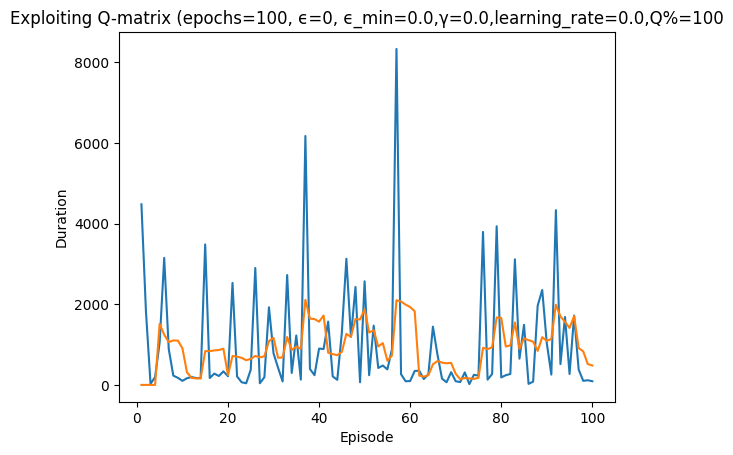

In [20]:
random.seed(120394016)
%matplotlib inline
ql_exploit_run = learner.epsilon_greedy_search(
    cyberbattlechain_defender,
    ep,
    learner=a.QTabularLearner(ep, trained=qlearning_bestrun_10['learner'],
                              gamma=0.0, learning_rate=0.0, exploit_percentile=100),
    episode_count=eval_episode_count,
    iteration_count=iteration_count,
    epsilon=0,
    render=False,
    title="Exploiting Q-matrix",
    verbosity=Verbosity.Quiet
)

The average overall reward for this simulation across 100 episodes is approximately 5583.94

###### Random+CredLookup
Learning with: episode_count=100,iteration_count=90000,ϵ=0.9,ϵ_min=0.1, ϵ_multdecay=0.75,ϵ_expdecay=5000,
  ## Episode: 1/100 'Random+CredLookup' ϵ=0.9000, 


Episode 1|Iteration 606|reward: 5774.0|last_reward_at:  606|Elapsed Time: 0:00:00||


  Episode 1 ended at t=606 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 11/198 (0.05)
    explore-remote: 13/312 (0.04)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/66 (0.08)
  exploit deflected to exploration: 24
  ## Episode: 2/100 'Random+CredLookup' ϵ=0.6066, 


Episode 2|Iteration 411|reward: 6012.0|last_reward_at:  411|Elapsed Time: 0:00:00||


  Episode 2 ended at t=411 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 13/119 (0.10)
    explore-remote: 16/200 (0.07)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 9/54 (0.14)
  exploit deflected to exploration: 25
  ## Episode: 3/100 'Random+CredLookup' ϵ=0.5647, 


Episode 3|Iteration 216|reward: 5888.0|last_reward_at:  216|Elapsed Time: 0:00:00||


  Episode 3 ended at t=216 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 14/52 (0.21)
    explore-remote: 13/92 (0.12)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 7/38 (0.16)
  exploit deflected to exploration: 17
  ## Episode: 4/100 'Random+CredLookup' ϵ=0.5440, 


Episode 4|Iteration 281|reward: 5512.0|last_reward_at:  281|Elapsed Time: 0:00:00||


  Episode 4 ended at t=281 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 8/89 (0.08)
    explore-remote: 8/127 (0.06)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 4/45 (0.08)
  exploit deflected to exploration: 24
  ## Episode: 5/100 'Random+CredLookup' ϵ=0.5183, 


Episode 5|Iteration 281|reward: 5878.0|last_reward_at:  281|Elapsed Time: 0:00:00||


  Episode 5 ended at t=281 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 13/88 (0.13)
    explore-remote: 11/100 (0.10)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 7/62 (0.10)
  exploit deflected to exploration: 16
  ## Episode: 6/100 'Random+CredLookup' ϵ=0.4941, 


Episode 6|Iteration 446|reward: 5766.0|last_reward_at:  446|Elapsed Time: 0:00:00||


  Episode 6 ended at t=446 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 12/117 (0.09)
    explore-remote: 12/207 (0.05)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/92 (0.06)
  exploit deflected to exploration: 50
  ## Episode: 7/100 'Random+CredLookup' ϵ=0.4583, 


Episode 7|Iteration 61|reward: 5372.0|last_reward_at:   61|Elapsed Time: 0:00:00||


  Episode 7 ended at t=61 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/12 (0.29)
    explore-remote: 6/25 (0.19)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 3/10 (0.23)
  exploit deflected to exploration: 13
  ## Episode: 8/100 'Random+CredLookup' ϵ=0.4537, 


Episode 8|Iteration 196|reward: 5760.0|last_reward_at:  196|Elapsed Time: 0:00:00||


  Episode 8 ended at t=196 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 11/55 (0.17)
    explore-remote: 11/75 (0.13)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/38 (0.14)
  exploit deflected to exploration: 41
  ## Episode: 9/100 'Random+CredLookup' ϵ=0.4391, 


Episode 9|Iteration 261|reward: 5764.0|last_reward_at:  261|Elapsed Time: 0:00:00||


  Episode 9 ended at t=261 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 11/65 (0.14)
    explore-remote: 12/126 (0.09)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 7/40 (0.15)
  exploit deflected to exploration: 73
  ## Episode: 10/100 'Random+CredLookup' ϵ=0.4206, 


Episode 10|Iteration 546|reward: 6006.0|last_reward_at:  546|Elapsed Time: 0:00:00||


  Episode 10 ended at t=546 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 13/139 (0.09)
    explore-remote: 16/199 (0.07)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 8/171 (0.04)
  exploit deflected to exploration: 67
  ## Episode: 11/100 'Random+CredLookup' ϵ=0.3849, 


Episode 11|Iteration 46|reward: 5478.0|last_reward_at:   46|Elapsed Time: 0:00:00||


  Episode 11 ended at t=46 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/8 (0.33)
    explore-remote: 6/14 (0.30)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 4/10 (0.29)
  exploit deflected to exploration: 12
  ## Episode: 12/100 'Random+CredLookup' ϵ=0.3820, 


Episode 12|Iteration 181|reward: 5632.0|last_reward_at:  181|Elapsed Time: 0:00:00||


  Episode 12 ended at t=181 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/44 (0.17)
    explore-remote: 10/54 (0.16)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/58 (0.09)
  exploit deflected to exploration: 45
  ## Episode: 13/100 'Random+CredLookup' ϵ=0.3711, 


Episode 13|Iteration 101|reward: 5612.0|last_reward_at:  101|Elapsed Time: 0:00:00||


  Episode 13 ended at t=101 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 7/16 (0.30)
    explore-remote: 9/34 (0.21)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/30 (0.14)
  exploit deflected to exploration: 18
  ## Episode: 14/100 'Random+CredLookup' ϵ=0.3652, 


Episode 14|Iteration 221|reward: 5639.0|last_reward_at:  221|Elapsed Time: 0:00:00||


  Episode 14 ended at t=221 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 10/43 (0.19)
    explore-remote: 9/98 (0.08)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/56 (0.08)
  exploit deflected to exploration: 40
  ## Episode: 15/100 'Random+CredLookup' ϵ=0.3526, 


Episode 15|Iteration 431|reward: 5746.0|last_reward_at:  431|Elapsed Time: 0:00:00||


  Episode 15 ended at t=431 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 10/90 (0.10)
    explore-remote: 10/160 (0.06)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 7/154 (0.04)
  exploit deflected to exploration: 91
  ## Episode: 16/100 'Random+CredLookup' ϵ=0.3297, 


Episode 16|Iteration 406|reward: 5762.0|last_reward_at:  406|Elapsed Time: 0:00:00||


  Episode 16 ended at t=406 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 11/76 (0.13)
    explore-remote: 11/151 (0.07)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 7/150 (0.04)
  exploit deflected to exploration: 84
  ## Episode: 17/100 'Random+CredLookup' ϵ=0.3098, 


Episode 17|Iteration 91|reward: 5838.0|last_reward_at:   91|Elapsed Time: 0:00:00||


  Episode 17 ended at t=91 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/16 (0.36)
    explore-remote: 9/23 (0.28)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 7/27 (0.21)
  exploit deflected to exploration: 17
  ## Episode: 18/100 'Random+CredLookup' ϵ=0.3056, 


Episode 18|Iteration 91|reward: 5494.0|last_reward_at:   91|Elapsed Time: 0:00:00||


  Episode 18 ended at t=91 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 6/14 (0.30)
    explore-remote: 7/26 (0.21)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/33 (0.13)
  exploit deflected to exploration: 26
  ## Episode: 19/100 'Random+CredLookup' ϵ=0.3015, 


Episode 19|Iteration 261|reward: 5750.0|last_reward_at:  261|Elapsed Time: 0:00:00||


  Episode 19 ended at t=261 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 11/35 (0.24)
    explore-remote: 10/72 (0.12)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 7/126 (0.05)
  exploit deflected to exploration: 29
  ## Episode: 20/100 'Random+CredLookup' ϵ=0.2899, 


Episode 20|Iteration 141|reward: 5506.0|last_reward_at:  141|Elapsed Time: 0:00:00||


  Episode 20 ended at t=141 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 8/25 (0.24)
    explore-remote: 8/37 (0.18)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 4/59 (0.06)
  exploit deflected to exploration: 29
  ## Episode: 21/100 'Random+CredLookup' ϵ=0.2840, 


Episode 21|Iteration 171|reward: 5517.0|last_reward_at:  171|Elapsed Time: 0:00:00||


  Episode 21 ended at t=171 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 8/24 (0.25)
    explore-remote: 9/78 (0.10)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 4/48 (0.08)
  exploit deflected to exploration: 56
  ## Episode: 22/100 'Random+CredLookup' ϵ=0.2769, 


Episode 22|Iteration 206|reward: 5761.0|last_reward_at:  206|Elapsed Time: 0:00:00||


  Episode 22 ended at t=206 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 11/44 (0.20)
    explore-remote: 10/78 (0.11)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 7/56 (0.11)
  exploit deflected to exploration: 54
  ## Episode: 23/100 'Random+CredLookup' ϵ=0.2688, 


Episode 23|Iteration 371|reward: 5868.0|last_reward_at:  371|Elapsed Time: 0:00:00||


  Episode 23 ended at t=371 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 11/64 (0.15)
    explore-remote: 11/115 (0.09)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 7/163 (0.04)
  exploit deflected to exploration: 63
  ## Episode: 24/100 'Random+CredLookup' ϵ=0.2549, 


Episode 24|Iteration 291|reward: 5773.0|last_reward_at:  291|Elapsed Time: 0:00:00||


  Episode 24 ended at t=291 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 12/54 (0.18)
    explore-remote: 12/73 (0.14)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/134 (0.04)
  exploit deflected to exploration: 62
  ## Episode: 25/100 'Random+CredLookup' ϵ=0.2448, 


Episode 25|Iteration 511|reward: 5768.0|last_reward_at:  511|Elapsed Time: 0:00:00||


  Episode 25 ended at t=511 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 12/107 (0.10)
    explore-remote: 12/174 (0.06)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/200 (0.03)
  exploit deflected to exploration: 137
  ## Episode: 26/100 'Random+CredLookup' ϵ=0.2283, 


Episode 26|Iteration 361|reward: 5527.0|last_reward_at:  361|Elapsed Time: 0:00:00||


  Episode 26 ended at t=361 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/76 (0.11)
    explore-remote: 10/122 (0.08)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 4/140 (0.03)
  exploit deflected to exploration: 111
  ## Episode: 27/100 'Random+CredLookup' ϵ=0.2176, 


Episode 27|Iteration 336|reward: 5777.0|last_reward_at:  336|Elapsed Time: 0:00:00||


  Episode 27 ended at t=336 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 13/66 (0.16)
    explore-remote: 12/91 (0.12)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/148 (0.04)
  exploit deflected to exploration: 79
  ## Episode: 28/100 'Random+CredLookup' ϵ=0.2083, 


Episode 28|Iteration 66|reward: 5493.0|last_reward_at:   66|Elapsed Time: 0:00:00||


  Episode 28 ended at t=66 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 6/14 (0.30)
    explore-remote: 5/29 (0.15)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/7 (0.42)
  exploit deflected to exploration: 42
  ## Episode: 29/100 'Random+CredLookup' ϵ=0.2066, 


Episode 29|Iteration 266|reward: 5632.0|last_reward_at:  266|Elapsed Time: 0:00:00||


  Episode 29 ended at t=266 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/52 (0.15)
    explore-remote: 10/50 (0.17)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/139 (0.04)
  exploit deflected to exploration: 57
  ## Episode: 30/100 'Random+CredLookup' ϵ=0.1998, 


Episode 30|Iteration 156|reward: 5754.0|last_reward_at:  156|Elapsed Time: 0:00:00||


  Episode 30 ended at t=156 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 11/28 (0.28)
    explore-remote: 11/50 (0.18)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/50 (0.11)
  exploit deflected to exploration: 48
  ## Episode: 31/100 'Random+CredLookup' ϵ=0.1959, 


Episode 31|Iteration 501|reward: 5630.0|last_reward_at:  501|Elapsed Time: 0:00:00||


  Episode 31 ended at t=501 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/109 (0.08)
    explore-remote: 9/153 (0.06)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/216 (0.02)
  exploit deflected to exploration: 150
  ## Episode: 32/100 'Random+CredLookup' ϵ=0.1844, 


Episode 32|Iteration 396|reward: 5781.0|last_reward_at:  396|Elapsed Time: 0:00:00||


  Episode 32 ended at t=396 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 13/52 (0.20)
    explore-remote: 14/96 (0.13)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/215 (0.03)
  exploit deflected to exploration: 78
  ## Episode: 33/100 'Random+CredLookup' ϵ=0.1761, 


Episode 33|Iteration 136|reward: 5610.0|last_reward_at:  136|Elapsed Time: 0:00:00||


  Episode 33 ended at t=136 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 8/19 (0.30)
    explore-remote: 8/40 (0.17)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/56 (0.08)
  exploit deflected to exploration: 37
  ## Episode: 34/100 'Random+CredLookup' ϵ=0.1733, 


Episode 34|Iteration 626|reward: 5779.0|last_reward_at:  626|Elapsed Time: 0:00:00||


  Episode 34 ended at t=626 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 12/137 (0.08)
    explore-remote: 14/160 (0.08)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/297 (0.02)
  exploit deflected to exploration: 182
  ## Episode: 35/100 'Random+CredLookup' ϵ=0.1618, 


Episode 35|Iteration 296|reward: 5632.0|last_reward_at:  296|Elapsed Time: 0:00:00||


  Episode 35 ended at t=296 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/53 (0.15)
    explore-remote: 10/86 (0.10)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/132 (0.04)
  exploit deflected to exploration: 92
  ## Episode: 36/100 'Random+CredLookup' ϵ=0.1568, 


Episode 36|Iteration 266|reward: 5653.0|last_reward_at:  266|Elapsed Time: 0:00:00||


  Episode 36 ended at t=266 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 10/61 (0.14)
    explore-remote: 12/69 (0.15)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/109 (0.04)
  exploit deflected to exploration: 104
  ## Episode: 37/100 'Random+CredLookup' ϵ=0.1526, 


Episode 37|Iteration 241|reward: 5638.0|last_reward_at:  241|Elapsed Time: 0:00:00||


  Episode 37 ended at t=241 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 10/52 (0.16)
    explore-remote: 8/96 (0.08)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/69 (0.08)
  exploit deflected to exploration: 112
  ## Episode: 38/100 'Random+CredLookup' ϵ=0.1489, 


Episode 38|Iteration 161|reward: 5517.0|last_reward_at:  161|Elapsed Time: 0:00:00||


  Episode 38 ended at t=161 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 7/24 (0.23)
    explore-remote: 10/32 (0.24)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/83 (0.06)
  exploit deflected to exploration: 41
  ## Episode: 39/100 'Random+CredLookup' ϵ=0.1466, 


Episode 39|Iteration 256|reward: 5630.0|last_reward_at:  256|Elapsed Time: 0:00:00||


  Episode 39 ended at t=256 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/49 (0.16)
    explore-remote: 9/81 (0.10)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/102 (0.06)
  exploit deflected to exploration: 99
  ## Episode: 40/100 'Random+CredLookup' ϵ=0.1430, 


Episode 40|Iteration 56|reward: 5480.0|last_reward_at:   56|Elapsed Time: 0:00:00||


  Episode 40 ended at t=56 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 6/5 (0.55)
    explore-remote: 5/15 (0.25)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 4/21 (0.16)
  exploit deflected to exploration: 23
  ## Episode: 41/100 'Random+CredLookup' ϵ=0.1422, 


Episode 41|Iteration 261|reward: 5508.0|last_reward_at:  261|Elapsed Time: 0:00:00||


  Episode 41 ended at t=261 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 7/51 (0.12)
    explore-remote: 8/81 (0.09)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/109 (0.04)
  exploit deflected to exploration: 95
  ## Episode: 42/100 'Random+CredLookup' ϵ=0.1388, 


Episode 42|Iteration 351|reward: 5766.0|last_reward_at:  351|Elapsed Time: 0:00:00||


  Episode 42 ended at t=351 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 11/69 (0.14)
    explore-remote: 12/97 (0.11)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/156 (0.04)
  exploit deflected to exploration: 123
  ## Episode: 43/100 'Random+CredLookup' ϵ=0.1345, 


Episode 43|Iteration 316|reward: 5639.0|last_reward_at:  316|Elapsed Time: 0:00:00||


  Episode 43 ended at t=316 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 10/45 (0.18)
    explore-remote: 9/90 (0.09)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/156 (0.04)
  exploit deflected to exploration: 103
  ## Episode: 44/100 'Random+CredLookup' ϵ=0.1308, 


Episode 44|Iteration 301|reward: 5628.0|last_reward_at:  301|Elapsed Time: 0:00:00||


  Episode 44 ended at t=301 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/46 (0.16)
    explore-remote: 9/74 (0.11)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/158 (0.03)
  exploit deflected to exploration: 83
  ## Episode: 45/100 'Random+CredLookup' ϵ=0.1276, 


Episode 45|Iteration 621|reward: 5897.0|last_reward_at:  621|Elapsed Time: 0:00:00||


  Episode 45 ended at t=621 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 14/104 (0.12)
    explore-remote: 13/169 (0.07)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 7/314 (0.02)
  exploit deflected to exploration: 194
  ## Episode: 46/100 'Random+CredLookup' ϵ=0.1214, 


Episode 46|Iteration 241|reward: 5508.0|last_reward_at:  241|Elapsed Time: 0:00:00||


  Episode 46 ended at t=241 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 8/47 (0.15)
    explore-remote: 8/65 (0.11)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 4/109 (0.04)
  exploit deflected to exploration: 94
  ## Episode: 47/100 'Random+CredLookup' ϵ=0.1193, 


Episode 47|Iteration 131|reward: 5612.0|last_reward_at:  131|Elapsed Time: 0:00:00||


  Episode 47 ended at t=131 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 7/22 (0.24)
    explore-remote: 6/46 (0.12)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/44 (0.12)
  exploit deflected to exploration: 66
  ## Episode: 48/100 'Random+CredLookup' ϵ=0.1181, 


Episode 48|Iteration 416|reward: 5651.0|last_reward_at:  416|Elapsed Time: 0:00:00||


  Episode 48 ended at t=416 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/75 (0.11)
    explore-remote: 12/115 (0.09)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/199 (0.03)
  exploit deflected to exploration: 141
  ## Episode: 49/100 'Random+CredLookup' ϵ=0.1147, 


Episode 49|Iteration 136|reward: 5502.0|last_reward_at:  136|Elapsed Time: 0:00:00||


  Episode 49 ended at t=136 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 7/18 (0.28)
    explore-remote: 7/26 (0.21)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/73 (0.06)
  exploit deflected to exploration: 44
  ## Episode: 50/100 'Random+CredLookup' ϵ=0.1136, 


Episode 50|Iteration 636|reward: 5760.0|last_reward_at:  636|Elapsed Time: 0:00:00||


  Episode 50 ended at t=636 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 11/80 (0.12)
    explore-remote: 12/144 (0.08)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/383 (0.02)
  exploit deflected to exploration: 150
  ## Episode: 51/100 'Random+CredLookup' ϵ=0.1090, 


Episode 51|Iteration 131|reward: 5374.0|last_reward_at:  131|Elapsed Time: 0:00:00||


  Episode 51 ended at t=131 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/18 (0.22)
    explore-remote: 7/38 (0.16)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 3/60 (0.05)
  exploit deflected to exploration: 46
  ## Episode: 52/100 'Random+CredLookup' ϵ=0.1081, 


Episode 52|Iteration 141|reward: 5502.0|last_reward_at:  141|Elapsed Time: 0:00:00||


  Episode 52 ended at t=141 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 7/16 (0.30)
    explore-remote: 8/41 (0.16)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 4/65 (0.06)
  exploit deflected to exploration: 51
  ## Episode: 53/100 'Random+CredLookup' ϵ=0.1072, 


Episode 53|Iteration 156|reward: 5740.0|last_reward_at:  156|Elapsed Time: 0:00:00||


  Episode 53 ended at t=156 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/32 (0.22)
    explore-remote: 10/54 (0.16)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 7/44 (0.14)
  exploit deflected to exploration: 75
  ## Episode: 54/100 'Random+CredLookup' ϵ=0.1062, 


Episode 54|Iteration 361|reward: 5762.0|last_reward_at:  361|Elapsed Time: 0:00:00||


  Episode 54 ended at t=361 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 10/60 (0.14)
    explore-remote: 12/97 (0.11)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 7/175 (0.04)
  exploit deflected to exploration: 119
  ## Episode: 55/100 'Random+CredLookup' ϵ=0.1040, 


Episode 55|Iteration 191|reward: 5515.0|last_reward_at:  191|Elapsed Time: 0:00:00||


  Episode 55 ended at t=191 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 8/21 (0.28)
    explore-remote: 9/50 (0.15)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 4/99 (0.04)
  exploit deflected to exploration: 58
  ## Episode: 56/100 'Random+CredLookup' ϵ=0.1029, 


Episode 56|Iteration 281|reward: 5632.0|last_reward_at:  281|Elapsed Time: 0:00:00||


  Episode 56 ended at t=281 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/33 (0.21)
    explore-remote: 10/66 (0.13)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/157 (0.04)
  exploit deflected to exploration: 80
  ## Episode: 57/100 'Random+CredLookup' ϵ=0.1014, 


Episode 57|Iteration 151|reward: 5632.0|last_reward_at:  151|Elapsed Time: 0:00:00||


  Episode 57 ended at t=151 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 10/30 (0.25)
    explore-remote: 9/43 (0.17)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/54 (0.08)
  exploit deflected to exploration: 71
  ## Episode: 58/100 'Random+CredLookup' ϵ=0.1006, 


Episode 58|Iteration 211|reward: 5622.0|last_reward_at:  211|Elapsed Time: 0:00:00||


  Episode 58 ended at t=211 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/38 (0.19)
    explore-remote: 8/60 (0.12)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/91 (0.05)
  exploit deflected to exploration: 90
  ## Episode: 59/100 'Random+CredLookup' ϵ=0.1000, 


Episode 59|Iteration 356|reward: 5626.0|last_reward_at:  356|Elapsed Time: 0:00:00||


  Episode 59 ended at t=356 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 8/64 (0.11)
    explore-remote: 10/101 (0.09)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/168 (0.03)
  exploit deflected to exploration: 134
  ## Episode: 60/100 'Random+CredLookup' ϵ=0.1000, 


Episode 60|Iteration 651|reward: 5876.0|last_reward_at:  651|Elapsed Time: 0:00:00||


  Episode 60 ended at t=651 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 12/123 (0.09)
    explore-remote: 11/178 (0.06)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 8/319 (0.02)
  exploit deflected to exploration: 247
  ## Episode: 61/100 'Random+CredLookup' ϵ=0.1000, 


Episode 61|Iteration 226|reward: 5744.0|last_reward_at:  226|Elapsed Time: 0:00:00||


  Episode 61 ended at t=226 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 10/28 (0.26)
    explore-remote: 10/42 (0.19)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 7/129 (0.05)
  exploit deflected to exploration: 61
  ## Episode: 62/100 'Random+CredLookup' ϵ=0.1000, 


Episode 62|Iteration 211|reward: 5496.0|last_reward_at:  211|Elapsed Time: 0:00:00||


  Episode 62 ended at t=211 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 7/38 (0.16)
    explore-remote: 7/69 (0.09)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 4/86 (0.04)
  exploit deflected to exploration: 94
  ## Episode: 63/100 'Random+CredLookup' ϵ=0.1000, 


Episode 63|Iteration 151|reward: 5506.0|last_reward_at:  151|Elapsed Time: 0:00:00||


  Episode 63 ended at t=151 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 8/24 (0.25)
    explore-remote: 8/52 (0.13)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 4/55 (0.07)
  exploit deflected to exploration: 77
  ## Episode: 64/100 'Random+CredLookup' ϵ=0.1000, 


Episode 64|Iteration 221|reward: 5624.0|last_reward_at:  221|Elapsed Time: 0:00:00||


  Episode 64 ended at t=221 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 8/40 (0.17)
    explore-remote: 10/54 (0.16)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/104 (0.05)
  exploit deflected to exploration: 84
  ## Episode: 65/100 'Random+CredLookup' ϵ=0.1000, 


Episode 65|Iteration 201|reward: 5738.0|last_reward_at:  201|Elapsed Time: 0:00:00||


  Episode 65 ended at t=201 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/41 (0.18)
    explore-remote: 10/63 (0.14)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/72 (0.08)
  exploit deflected to exploration: 97
  ## Episode: 66/100 'Random+CredLookup' ϵ=0.1000, 


Episode 66|Iteration 196|reward: 5622.0|last_reward_at:  196|Elapsed Time: 0:00:00||


  Episode 66 ended at t=196 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 8/43 (0.16)
    explore-remote: 9/36 (0.20)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/94 (0.06)
  exploit deflected to exploration: 76
  ## Episode: 67/100 'Random+CredLookup' ϵ=0.1000, 


Episode 67|Iteration 206|reward: 5490.0|last_reward_at:  206|Elapsed Time: 0:00:00||


  Episode 67 ended at t=206 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 6/28 (0.18)
    explore-remote: 6/80 (0.07)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/81 (0.06)
  exploit deflected to exploration: 99
  ## Episode: 68/100 'Random+CredLookup' ϵ=0.1000, 


Episode 68|Iteration 201|reward: 5393.0|last_reward_at:  201|Elapsed Time: 0:00:00||


  Episode 68 ended at t=201 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/33 (0.13)
    explore-remote: 8/62 (0.11)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 4/89 (0.04)
  exploit deflected to exploration: 74
  ## Episode: 69/100 'Random+CredLookup' ϵ=0.1000, 


Episode 69|Iteration 481|reward: 5527.0|last_reward_at:  481|Elapsed Time: 0:00:00||


  Episode 69 ended at t=481 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 8/69 (0.10)
    explore-remote: 9/147 (0.06)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/243 (0.02)
  exploit deflected to exploration: 169
  ## Episode: 70/100 'Random+CredLookup' ϵ=0.1000, 


Episode 70|Iteration 231|reward: 5504.0|last_reward_at:  231|Elapsed Time: 0:00:00||


  Episode 70 ended at t=231 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 8/50 (0.14)
    explore-remote: 7/82 (0.08)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 4/80 (0.05)
  exploit deflected to exploration: 123
  ## Episode: 71/100 'Random+CredLookup' ϵ=0.1000, 


Episode 71|Iteration 351|reward: 5775.0|last_reward_at:  351|Elapsed Time: 0:00:00||


  Episode 71 ended at t=351 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 11/52 (0.17)
    explore-remote: 14/102 (0.12)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 7/165 (0.04)
  exploit deflected to exploration: 148
  ## Episode: 72/100 'Random+CredLookup' ϵ=0.1000, 


Episode 72|Iteration 481|reward: 5746.0|last_reward_at:  481|Elapsed Time: 0:00:00||


  Episode 72 ended at t=481 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 10/44 (0.19)
    explore-remote: 10/71 (0.12)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 7/339 (0.02)
  exploit deflected to exploration: 72
  ## Episode: 73/100 'Random+CredLookup' ϵ=0.1000, 


Episode 73|Iteration 256|reward: 5638.0|last_reward_at:  256|Elapsed Time: 0:00:00||


  Episode 73 ended at t=256 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 10/31 (0.24)
    explore-remote: 10/73 (0.12)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/127 (0.04)
  exploit deflected to exploration: 90
  ## Episode: 74/100 'Random+CredLookup' ϵ=0.1000, 


Episode 74|Iteration 531|reward: 5632.0|last_reward_at:  531|Elapsed Time: 0:00:00||


  Episode 74 ended at t=531 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/74 (0.11)
    explore-remote: 10/118 (0.08)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/314 (0.02)
  exploit deflected to exploration: 153
  ## Episode: 75/100 'Random+CredLookup' ϵ=0.1000, 


Episode 75|Iteration 301|reward: 5628.0|last_reward_at:  301|Elapsed Time: 0:00:00||


  Episode 75 ended at t=301 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/52 (0.15)
    explore-remote: 9/86 (0.09)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/139 (0.04)
  exploit deflected to exploration: 128
  ## Episode: 76/100 'Random+CredLookup' ϵ=0.1000, 


Episode 76|Iteration 321|reward: 5641.0|last_reward_at:  321|Elapsed Time: 0:00:00||


  Episode 76 ended at t=321 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/52 (0.15)
    explore-remote: 10/78 (0.11)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/166 (0.03)
  exploit deflected to exploration: 115
  ## Episode: 77/100 'Random+CredLookup' ϵ=0.1000, 


Episode 77|Iteration 261|reward: 5631.0|last_reward_at:  261|Elapsed Time: 0:00:00||


  Episode 77 ended at t=261 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/44 (0.17)
    explore-remote: 10/97 (0.09)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/96 (0.05)
  exploit deflected to exploration: 133
  ## Episode: 78/100 'Random+CredLookup' ϵ=0.1000, 


Episode 78|Iteration 156|reward: 5507.0|last_reward_at:  156|Elapsed Time: 0:00:00||


  Episode 78 ended at t=156 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 7/27 (0.21)
    explore-remote: 7/51 (0.12)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/59 (0.08)
  exploit deflected to exploration: 74
  ## Episode: 79/100 'Random+CredLookup' ϵ=0.1000, 


Episode 79|Iteration 391|reward: 5740.0|last_reward_at:  391|Elapsed Time: 0:00:00||


  Episode 79 ended at t=391 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/65 (0.12)
    explore-remote: 10/133 (0.07)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 7/167 (0.04)
  exploit deflected to exploration: 179
  ## Episode: 80/100 'Random+CredLookup' ϵ=0.1000, 


Episode 80|Iteration 401|reward: 5880.0|last_reward_at:  401|Elapsed Time: 0:00:00||


  Episode 80 ended at t=401 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 12/59 (0.17)
    explore-remote: 12/72 (0.14)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 8/238 (0.03)
  exploit deflected to exploration: 106
  ## Episode: 81/100 'Random+CredLookup' ϵ=0.1000, 


Episode 81|Iteration 291|reward: 5620.0|last_reward_at:  291|Elapsed Time: 0:00:00||


  Episode 81 ended at t=291 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 7/41 (0.15)
    explore-remote: 10/87 (0.10)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/140 (0.04)
  exploit deflected to exploration: 115
  ## Episode: 82/100 'Random+CredLookup' ϵ=0.1000, 


Episode 82|Iteration 121|reward: 5498.0|last_reward_at:  121|Elapsed Time: 0:00:00||


  Episode 82 ended at t=121 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 7/24 (0.23)
    explore-remote: 7/55 (0.11)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 4/24 (0.14)
  exploit deflected to exploration: 81
  ## Episode: 83/100 'Random+CredLookup' ϵ=0.1000, 


Episode 83|Iteration 226|reward: 5527.0|last_reward_at:  226|Elapsed Time: 0:00:00||


  Episode 83 ended at t=226 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/37 (0.20)
    explore-remote: 10/70 (0.12)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 4/96 (0.04)
  exploit deflected to exploration: 98
  ## Episode: 84/100 'Random+CredLookup' ϵ=0.1000, 


Episode 84|Iteration 351|reward: 5519.0|last_reward_at:  351|Elapsed Time: 0:00:00||


  Episode 84 ended at t=351 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 8/57 (0.12)
    explore-remote: 8/123 (0.06)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/150 (0.03)
  exploit deflected to exploration: 146
  ## Episode: 85/100 'Random+CredLookup' ϵ=0.1000, 


Episode 85|Iteration 196|reward: 5503.0|last_reward_at:  196|Elapsed Time: 0:00:00||


  Episode 85 ended at t=196 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 6/41 (0.13)
    explore-remote: 7/63 (0.10)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/74 (0.06)
  exploit deflected to exploration: 97
  ## Episode: 86/100 'Random+CredLookup' ϵ=0.1000, 


Episode 86|Iteration 141|reward: 5500.0|last_reward_at:  141|Elapsed Time: 0:00:00||


  Episode 86 ended at t=141 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 7/19 (0.27)
    explore-remote: 8/27 (0.23)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 4/76 (0.05)
  exploit deflected to exploration: 38
  ## Episode: 87/100 'Random+CredLookup' ϵ=0.1000, 


Episode 87|Iteration 331|reward: 5653.0|last_reward_at:  331|Elapsed Time: 0:00:00||


  Episode 87 ended at t=331 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 10/64 (0.14)
    explore-remote: 12/89 (0.12)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/151 (0.03)
  exploit deflected to exploration: 138
  ## Episode: 88/100 'Random+CredLookup' ϵ=0.1000, 


Episode 88|Iteration 256|reward: 5766.0|last_reward_at:  256|Elapsed Time: 0:00:00||


  Episode 88 ended at t=256 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 12/31 (0.28)
    explore-remote: 12/49 (0.20)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/146 (0.04)
  exploit deflected to exploration: 64
  ## Episode: 89/100 'Random+CredLookup' ϵ=0.1000, 


Episode 89|Iteration 411|reward: 5746.0|last_reward_at:  411|Elapsed Time: 0:00:00||


  Episode 89 ended at t=411 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 10/67 (0.13)
    explore-remote: 10/103 (0.09)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 7/214 (0.03)
  exploit deflected to exploration: 148
  ## Episode: 90/100 'Random+CredLookup' ϵ=0.1000, 


Episode 90|Iteration 251|reward: 5759.0|last_reward_at:  251|Elapsed Time: 0:00:00||


  Episode 90 ended at t=251 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 11/42 (0.21)
    explore-remote: 9/77 (0.10)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 7/105 (0.06)
  exploit deflected to exploration: 111
  ## Episode: 91/100 'Random+CredLookup' ϵ=0.1000, 


Episode 91|Iteration 321|reward: 5641.0|last_reward_at:  321|Elapsed Time: 0:00:00||


  Episode 91 ended at t=321 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 10/56 (0.15)
    explore-remote: 8/96 (0.08)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/145 (0.04)
  exploit deflected to exploration: 145
  ## Episode: 92/100 'Random+CredLookup' ϵ=0.1000, 


Episode 92|Iteration 181|reward: 5608.0|last_reward_at:  181|Elapsed Time: 0:00:00||


  Episode 92 ended at t=181 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 6/17 (0.26)
    explore-remote: 9/39 (0.19)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/104 (0.05)
  exploit deflected to exploration: 52
  ## Episode: 93/100 'Random+CredLookup' ϵ=0.1000, 


Episode 93|Iteration 406|reward: 5657.0|last_reward_at:  406|Elapsed Time: 0:00:00||


  Episode 93 ended at t=406 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 10/66 (0.13)
    explore-remote: 12/115 (0.09)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/197 (0.03)
  exploit deflected to exploration: 165
  ## Episode: 94/100 'Random+CredLookup' ϵ=0.1000, 


Episode 94|Iteration 141|reward: 5519.0|last_reward_at:  141|Elapsed Time: 0:00:00||


  Episode 94 ended at t=141 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 9/36 (0.20)
    explore-remote: 8/38 (0.17)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 4/46 (0.08)
  exploit deflected to exploration: 71
  ## Episode: 95/100 'Random+CredLookup' ϵ=0.1000, 


Episode 95|Iteration 446|reward: 5756.0|last_reward_at:  446|Elapsed Time: 0:00:00||


  Episode 95 ended at t=446 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 10/61 (0.14)
    explore-remote: 11/103 (0.10)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 7/254 (0.03)
  exploit deflected to exploration: 153
  ## Episode: 96/100 'Random+CredLookup' ϵ=0.1000, 


Episode 96|Iteration 261|reward: 5769.0|last_reward_at:  261|Elapsed Time: 0:00:00||


  Episode 96 ended at t=261 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 12/38 (0.24)
    explore-remote: 11/60 (0.15)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 7/133 (0.05)
  exploit deflected to exploration: 99
  ## Episode: 97/100 'Random+CredLookup' ϵ=0.1000, 


Episode 97|Iteration 636|reward: 5756.0|last_reward_at:  636|Elapsed Time: 0:00:00||


  Episode 97 ended at t=636 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 10/98 (0.09)
    explore-remote: 12/157 (0.07)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 6/353 (0.02)
  exploit deflected to exploration: 207
  ## Episode: 98/100 'Random+CredLookup' ϵ=0.1000, 


Episode 98|Iteration 111|reward: 5399.0|last_reward_at:  111|Elapsed Time: 0:00:00||


  Episode 98 ended at t=111 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 6/16 (0.27)
    explore-remote: 9/35 (0.20)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 3/42 (0.07)
  exploit deflected to exploration: 53
  ## Episode: 99/100 'Random+CredLookup' ϵ=0.1000, 


Episode 99|Iteration 266|reward: 5506.0|last_reward_at:  266|Elapsed Time: 0:00:00||


  Episode 99 ended at t=266 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 7/41 (0.15)
    explore-remote: 8/89 (0.08)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 5/116 (0.04)
  exploit deflected to exploration: 128
  ## Episode: 100/100 'Random+CredLookup' ϵ=0.1000, 


Episode 100|Iteration 181|reward: 5506.0|last_reward_at:  181|Elapsed Time: 0:00:00||


  Episode 100 ended at t=181 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 7/19 (0.27)
    explore-remote: 9/36 (0.20)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 4/106 (0.04)
  exploit deflected to exploration: 53
simulation ended


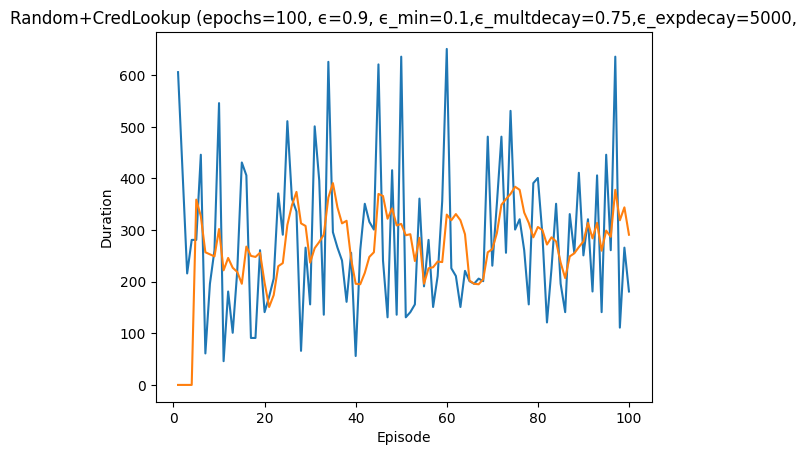

In [21]:
'''reinforcement learning experiment where an agent 
interacts with a cybersecurity environment, trying to maximize rewards 
by performing actions that could potentially exploit credentials'''

%matplotlib inline
random.seed(120394016)
credexplot = learner.epsilon_greedy_search(
    cyberbattlechain_defender,
    learner=rca.CredentialCacheExploiter(),
    environment_properties=ep,
    episode_count=training_episode_count,
    iteration_count=iteration_count,
    epsilon=0.90,
    render=False,
    epsilon_multdecay=0.75,  # 0.999,
    epsilon_exponential_decay=5000,
    epsilon_minimum=0.1,
    verbosity=Verbosity.Quiet,
    title="Random+CredLookup"
)

The average overall reward for this simulation is approximately 5648.31.

In [22]:
#takes 40 minutes to run so not using it
#%matplotlib inline
#randomlearning_results = learner.epsilon_greedy_search(
#    cyberbattlechain_defender,
 #   learner=rca.CredentialCacheExploiter(),
  #  environment_properties=ep,
   # episode_count=eval_episode_count,
    #iteration_count=iteration_count,
    #epsilon=1.0,  # purely random
    #render=False,
    #verbosity=Verbosity.Quiet,
    #title="Random search"
#)

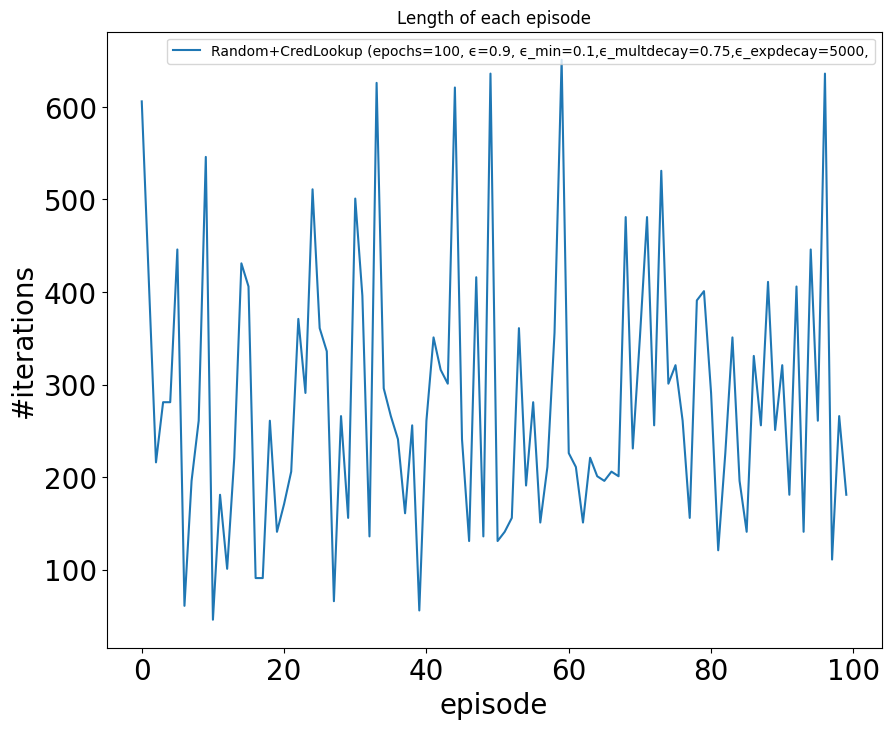

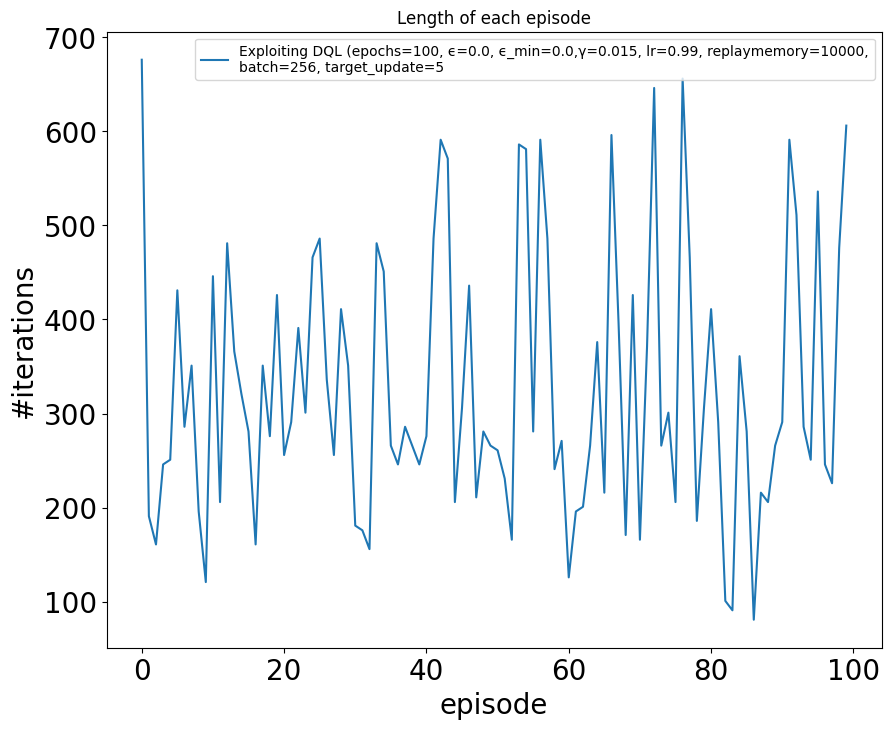

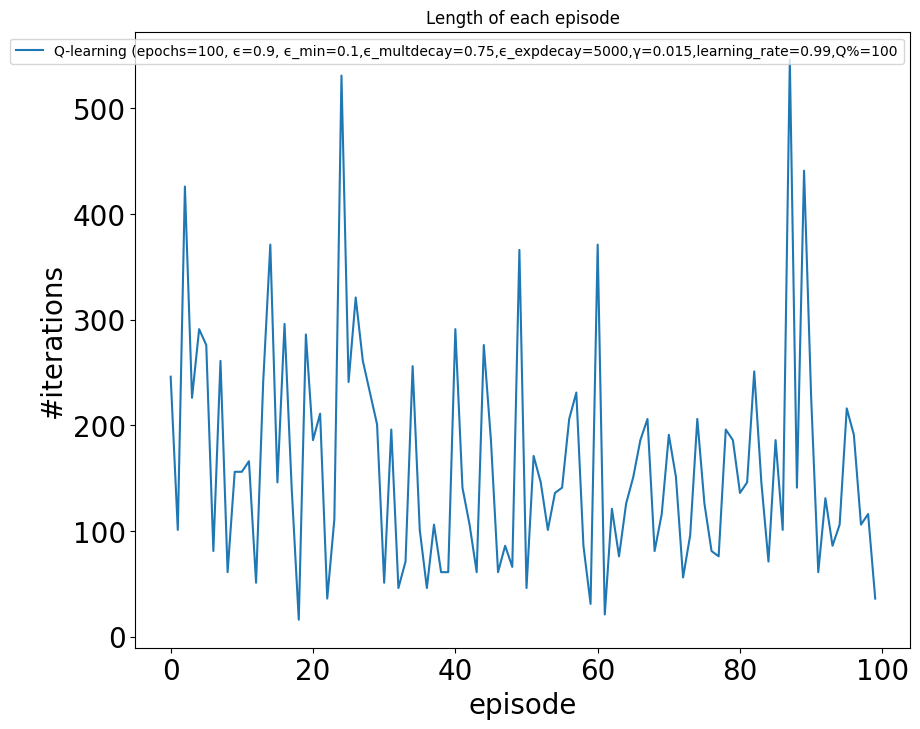

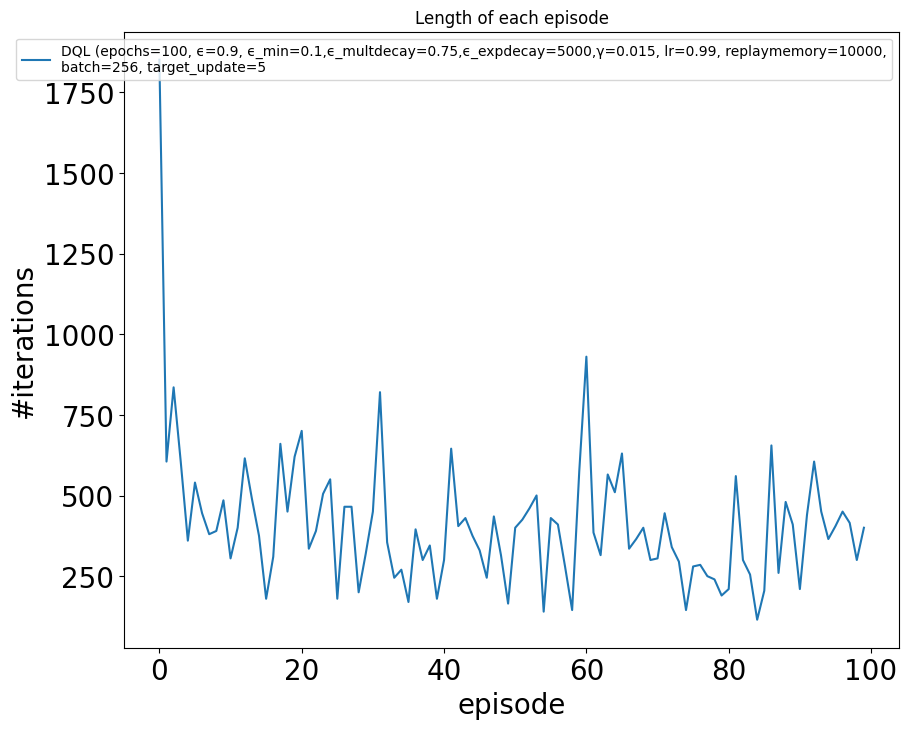

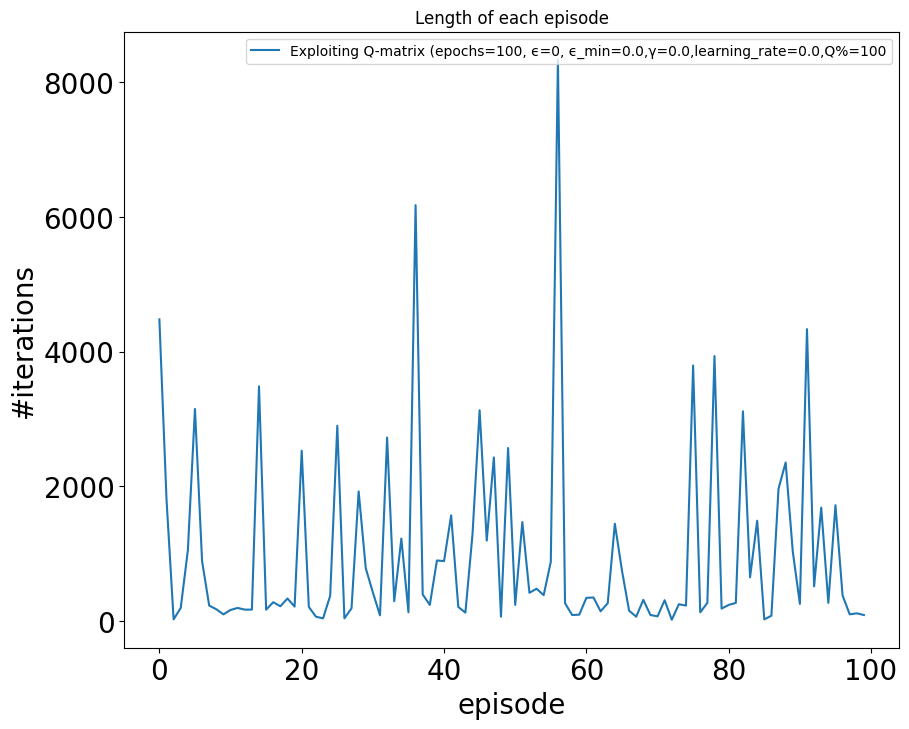

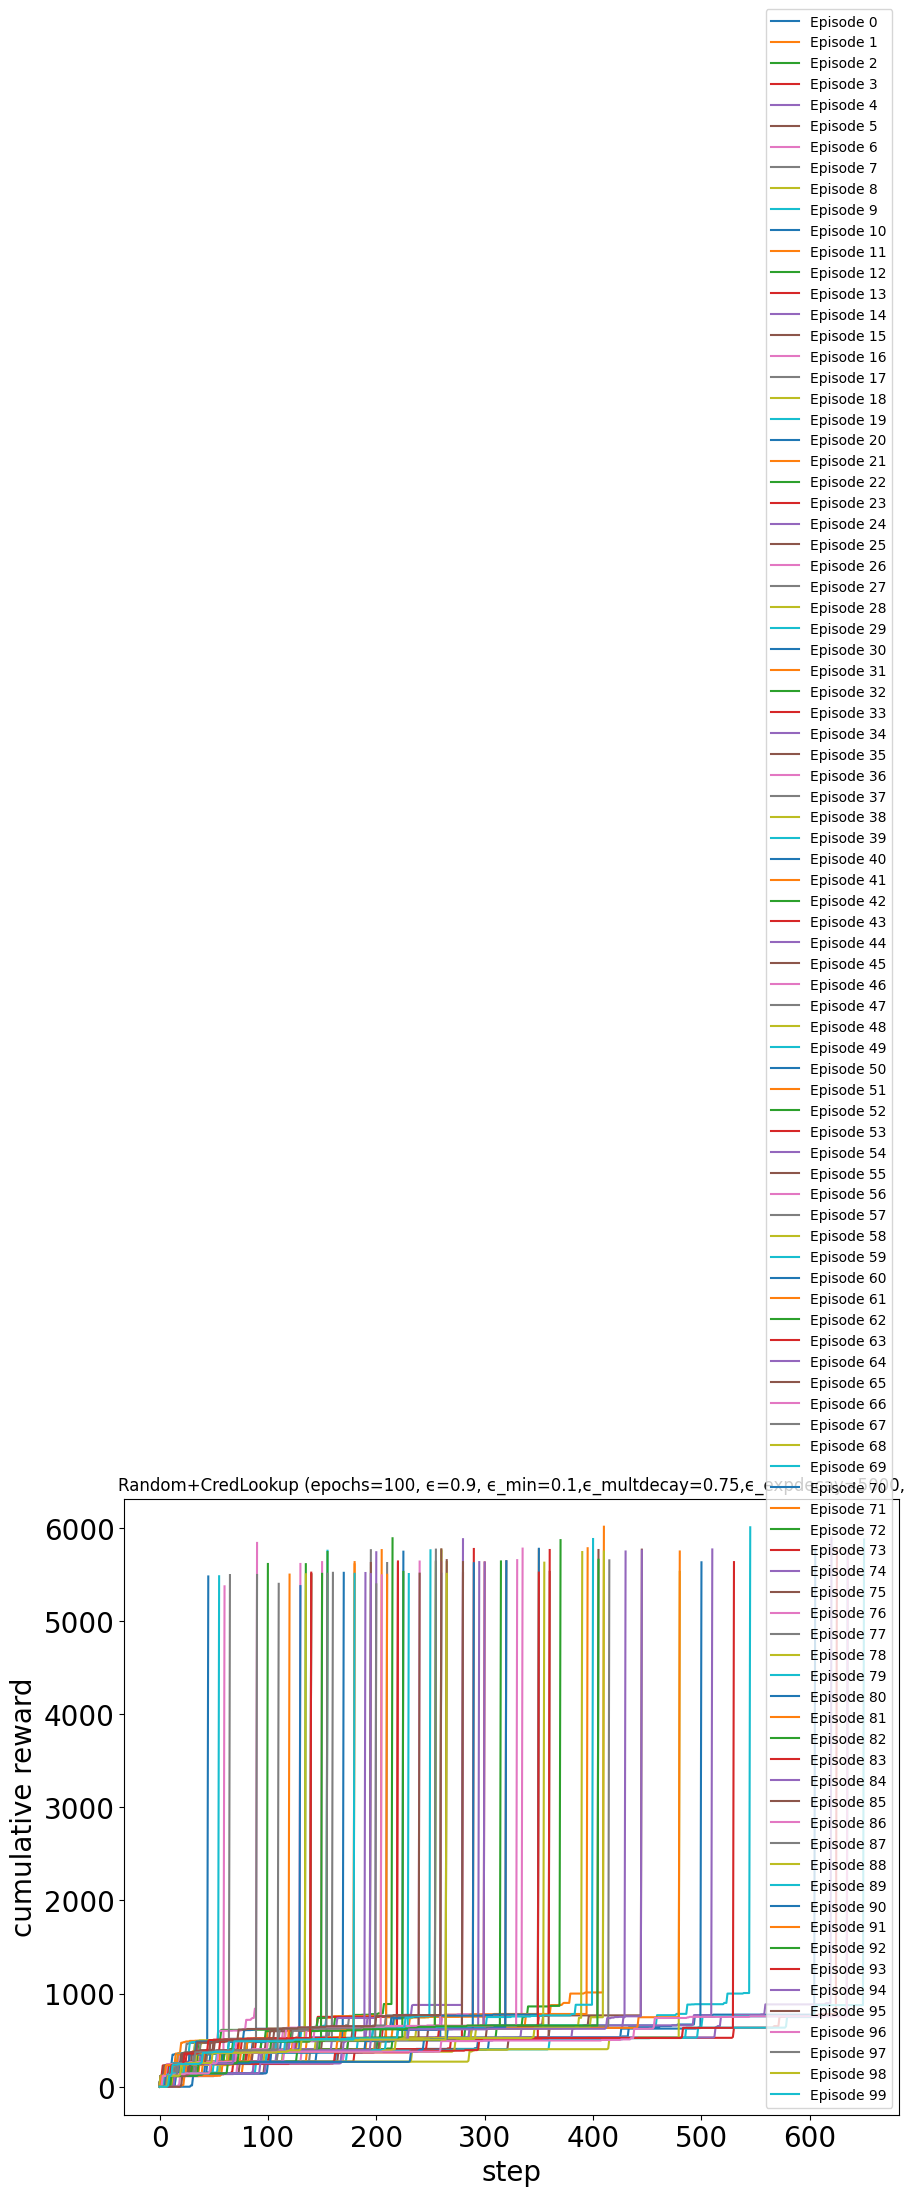

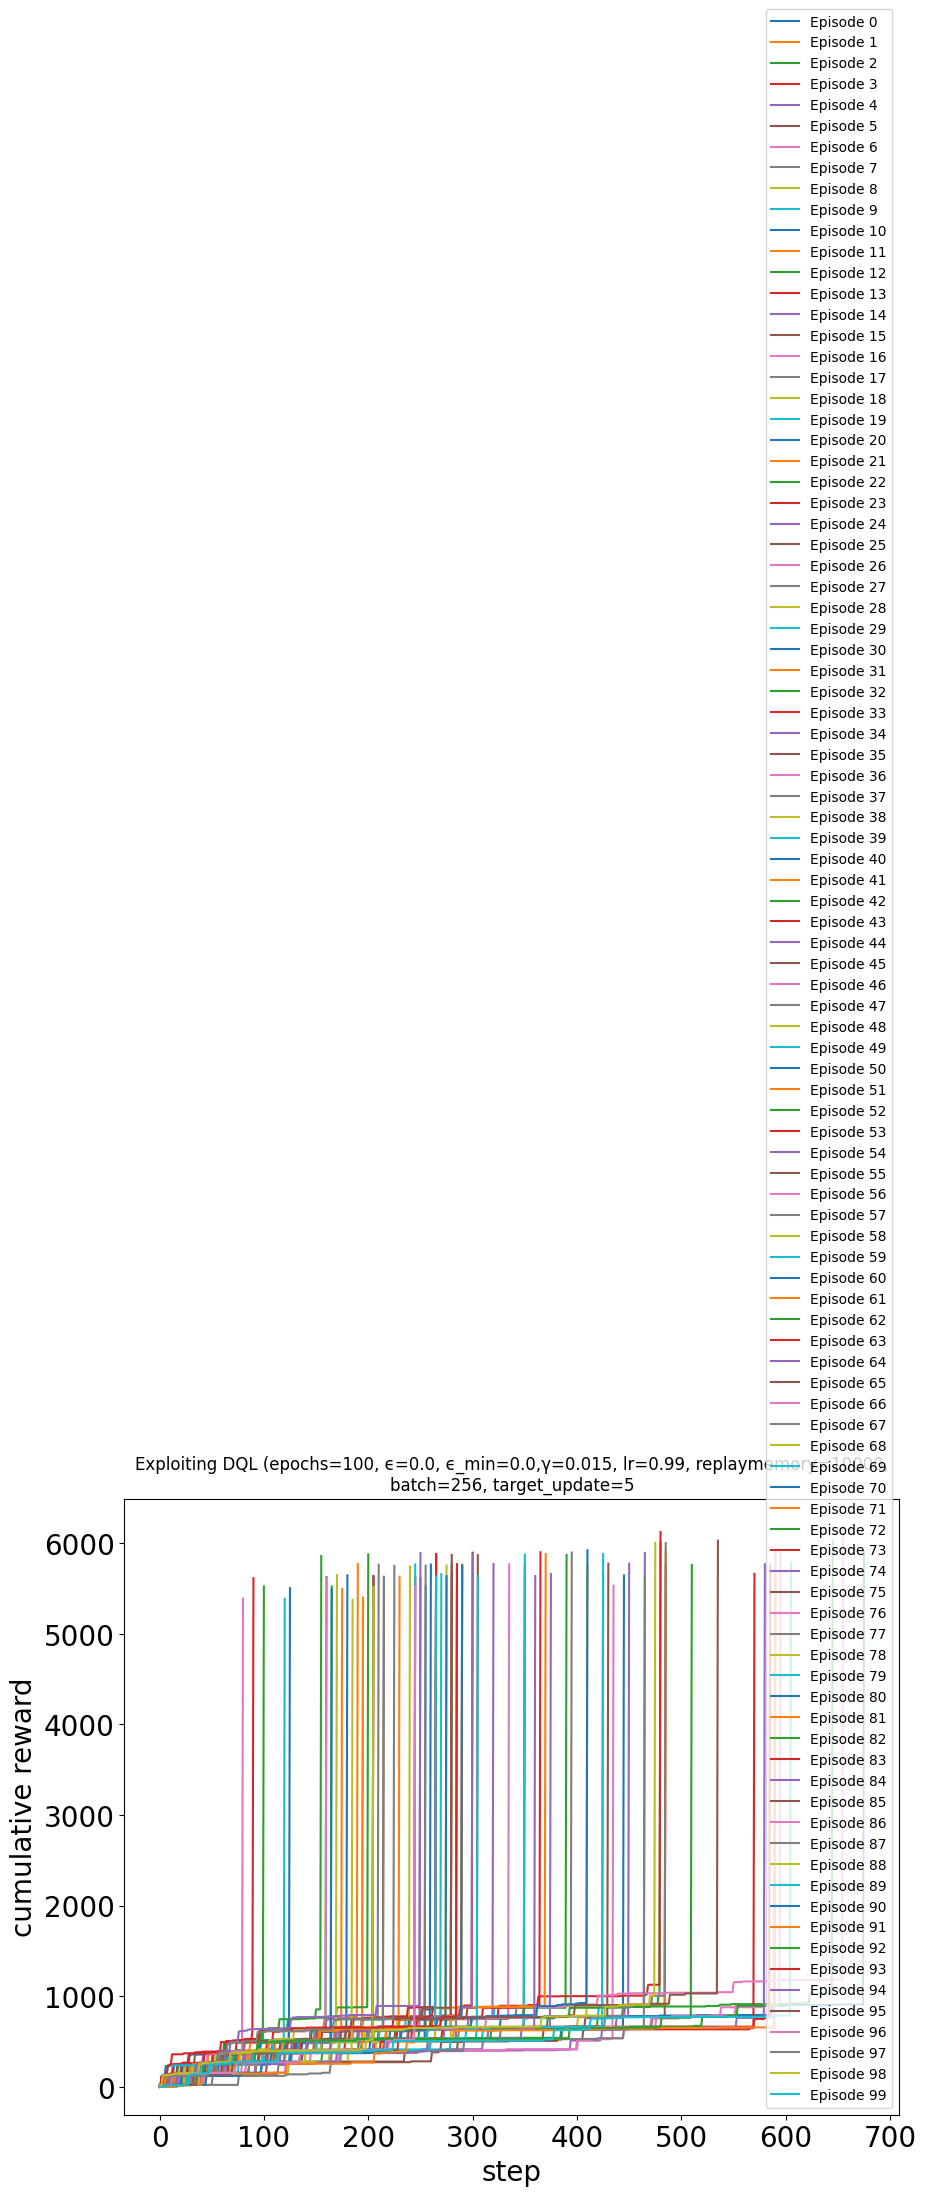

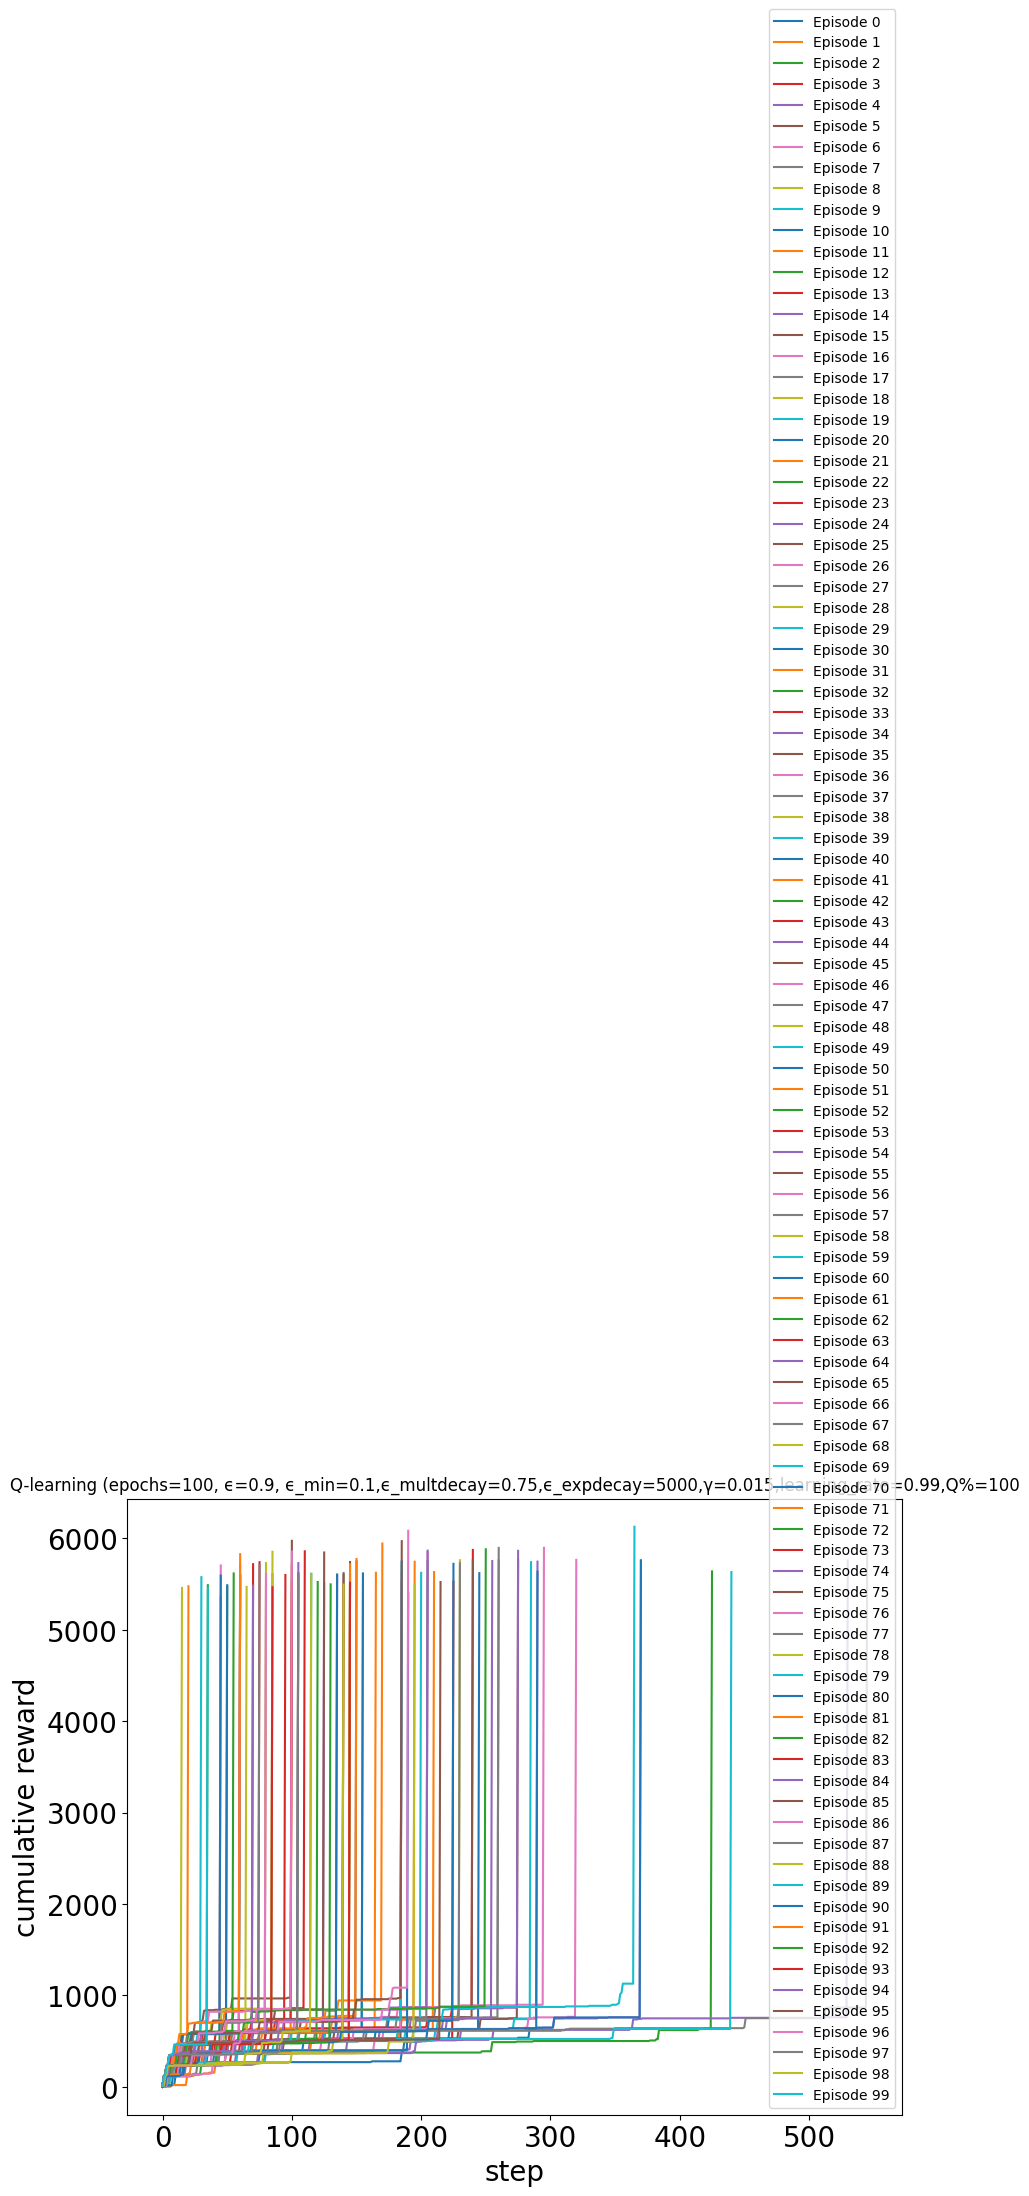

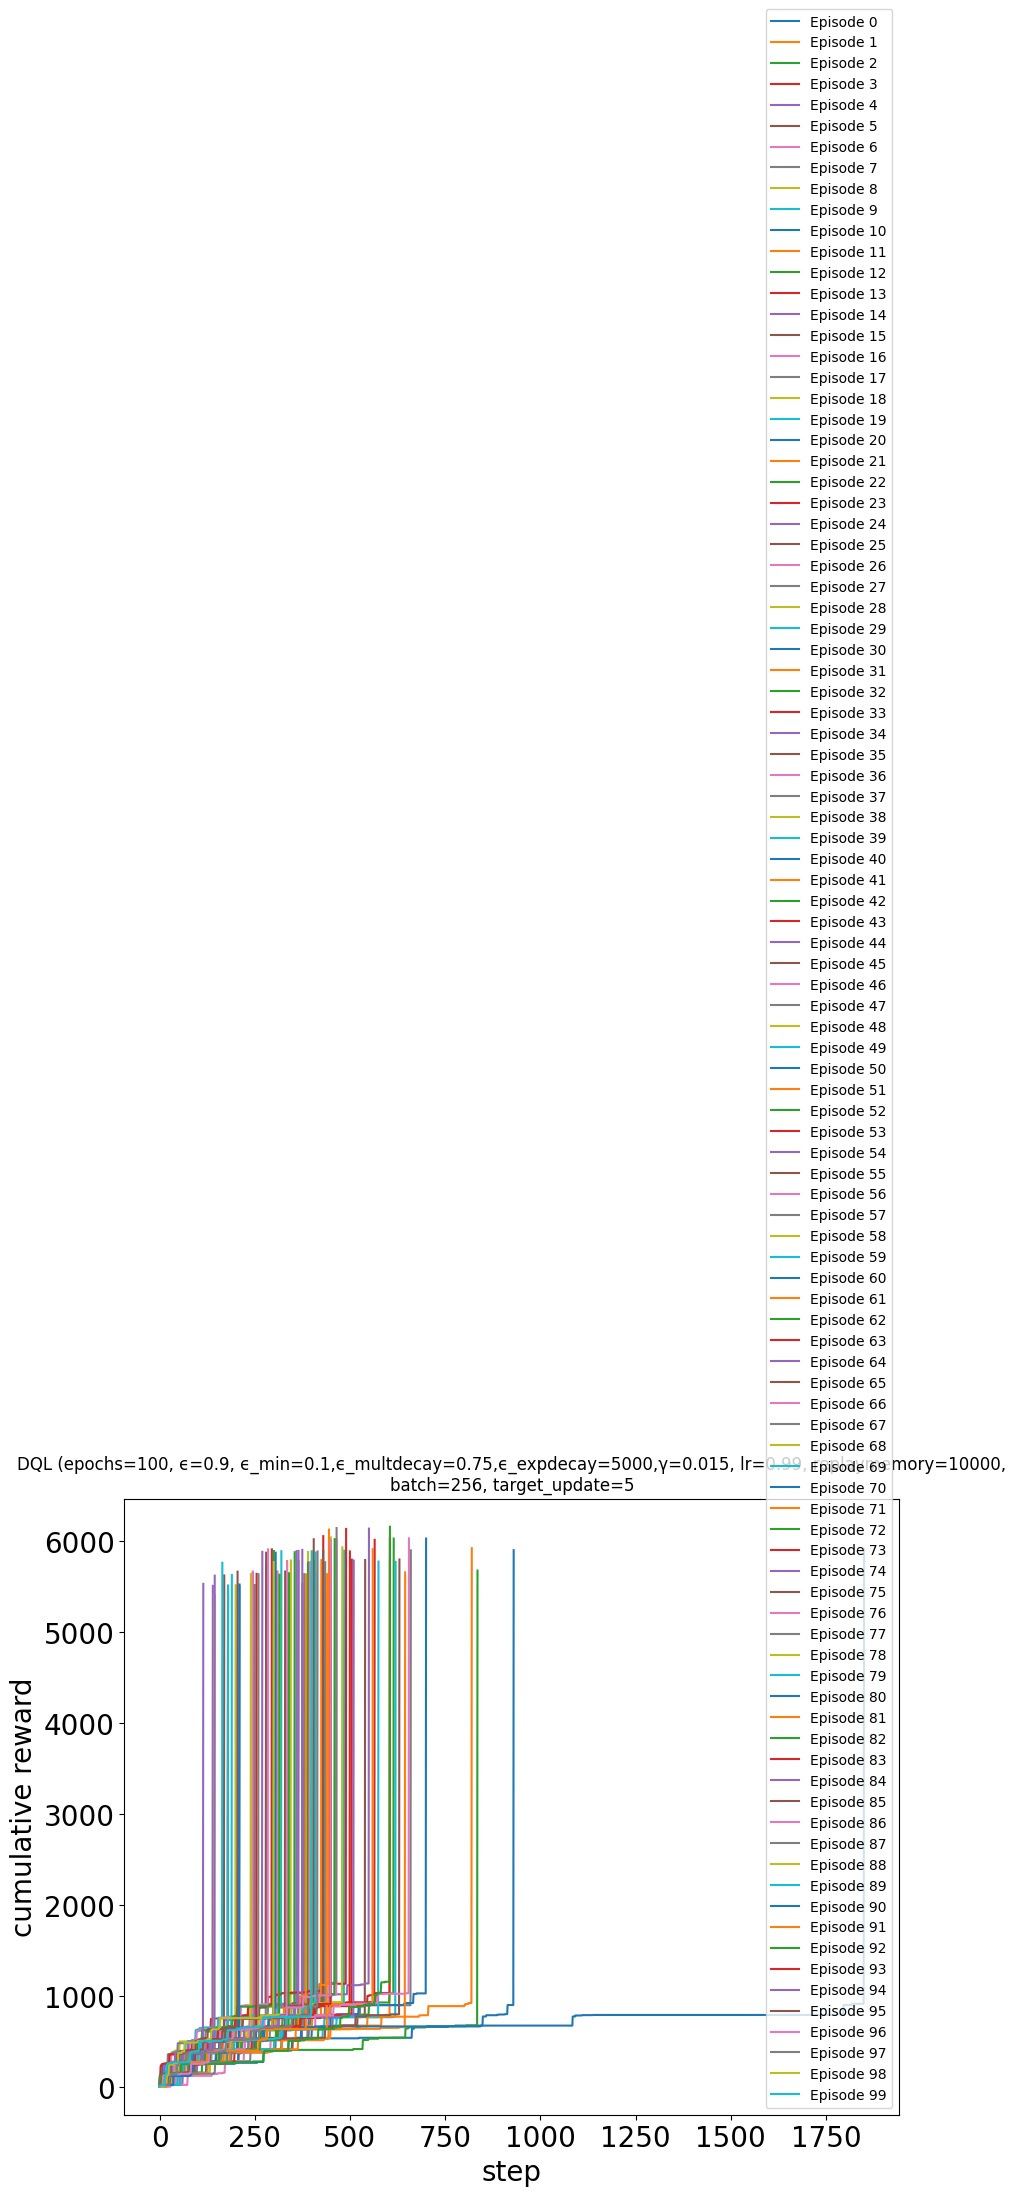

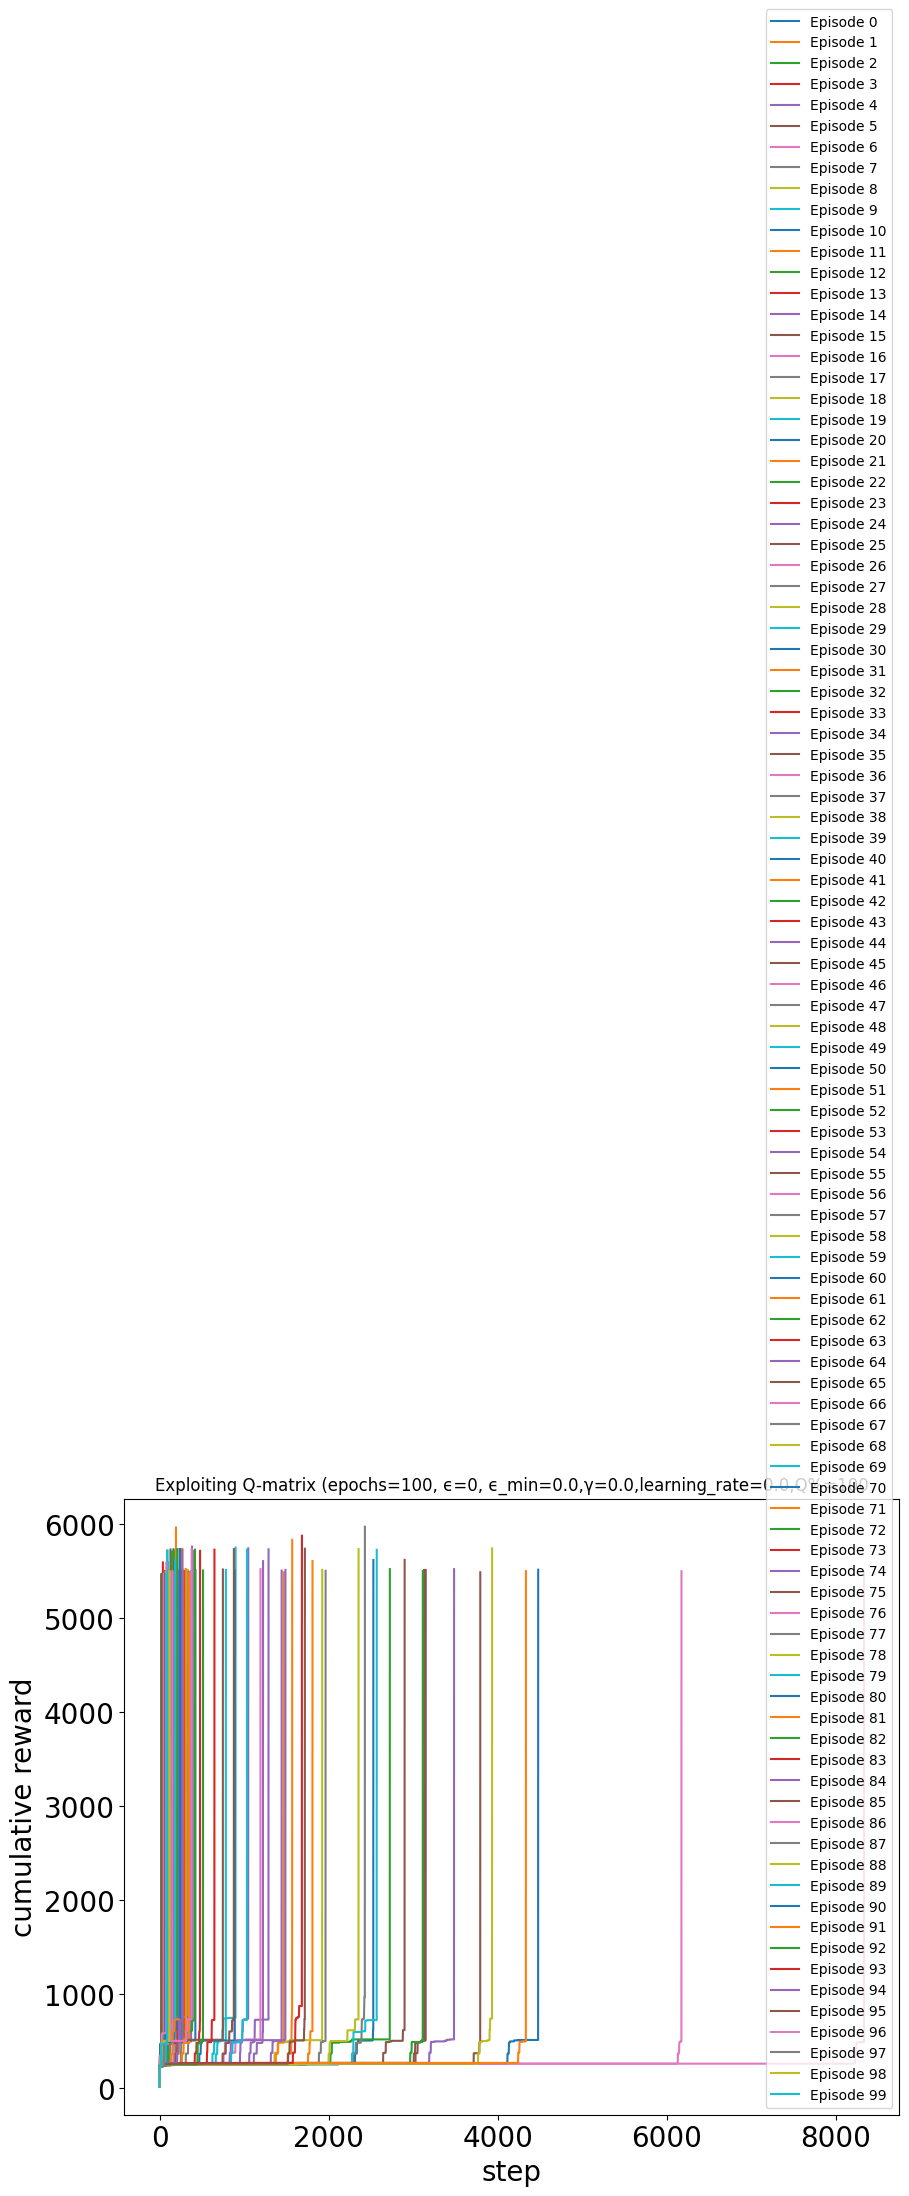

In [23]:
%matplotlib inline
random.seed(120394016)
p.plot_episodes_length([credexplot])
#p.plot_episodes_length([randomlearning_results])
p.plot_episodes_length([dql_exploit_run])
p.plot_episodes_length([qlearning_bestrun_10])
p.plot_episodes_length([dqn_with_defender])
p.plot_episodes_length([ql_exploit_run])
p.plot_all_episodes(credexplot)
#p.plot_all_episodes(randomlearning_results)
p.plot_all_episodes(dql_exploit_run)
p.plot_all_episodes(qlearning_bestrun_10)
p.plot_all_episodes(dqn_with_defender)
p.plot_all_episodes(ql_exploit_run)

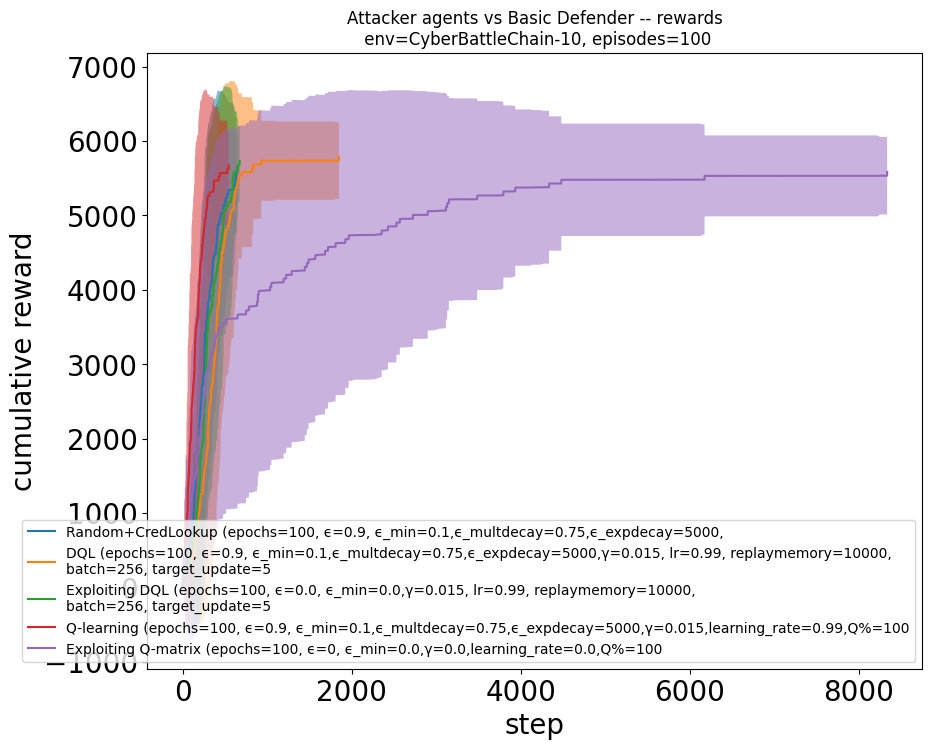

In [24]:
%matplotlib inline
random.seed(120394016)
# Plots
all_runs = [
    credexplot,
    dqn_with_defender,
    dql_exploit_run,
    qlearning_bestrun_10,
    ql_exploit_run
]
#randomlearning_results,
#    qlearning_bestrun_10,
 #   ql_exploit_run
p.plot_averaged_cummulative_rewards(
    all_runs=all_runs,
    title=f'Attacker agents vs Basic Defender -- rewards\n env={cyberbattlechain_defender.name}, episodes={training_episode_count}',
    show=False
)

Highest average rewards:
1. DQL
2. exploiting dql
3. qmatrrix
4. randomcredlookup
5. exploiting qmatrix

In [25]:
from stable_baselines3.common.env_util import make_vec_env
import gym
from cyberbattle._env.cyberbattle_env import AttackerGoal, DefenderConstraint
from cyberbattle._env.defender import ScanAndReimageCompromisedMachines
from cyberbattle._env.flatten_wrapper import FlattenObservationWrapper, FlattenActionWrapper
env1 = FlattenActionWrapper(cyberbattlechain_defender)
ignore_fields = [
    # DummySpace
    '_credential_cache',
    '_discovered_nodes',
    '_explored_network',
]
#env2 = FlattenObservationWrapper(cast(CyberBattleEnv, env1), ignore_fields=ignore_fields)
#model_a2c = A2C("MultiInputPolicy", env2).learn(10)
#model_a2c  #keeps breaking kernel

Filtering out field _credential_cache

Filtering out field _discovered_nodes

Filtering out field _explored_network

// MultiBinary flattened from [100, 100, 8, 1000] -> 80000000

// MultiBinary flattened from [100, 5] -> 500

// MultiBinary flattened from [100, 100, 2] -> 20000

// MultiBinary already flat: 1